Research questions 

What factors impact Rating ?
-  Machine learning to classify reviews 
     what are key words that determines ratings?
     
        use logit regression to determine relationship between key words from ratings and wine type, price, region, seller 
        
 There is a correlation between Ratings and Price ?
 - Correlation analysis


The higher the Rating and Price the higher the consumption of the wine variety
- Multiple Regression 


Does wine sales/consumption have a bearing with grape , price , rating ?

In [3]:
import numpy as np

import csv
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn import svm, linear_model, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

C:\Users\bless\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# path='C:/Users/bless/Documents/GitHub/projects/project-capstone/Capstone project data'
# alternate file winemag-data-130k-v2.csv

wine = pd.read_csv('C:/Users/bless/Documents/GitHub/projects/project-capstone/Wine/wine-reviews/winemag-data_first150k - Copy.csv',\
                   index_col=0,parse_dates=True,   dayfirst=True,encoding='utf-8')


In [5]:
wine.head(5)

country                                        description  \
0      US  This tremendous 100% varietal wine hails from ...   
1   Spain  Ripe aromas of fig, blackberry and cassis are ...   
2      US  Mac Watson honors the memory of a wine once ma...   
3      US  This spent 20 months in 30% new French oak, an...   
4  France  This is the top wine from La Bégude, named aft...   

                            designation  points  price        province  \
0                     Martha's Vineyard      96  235.0      California   
1  Carodorum Selección Especial Reserva      96  110.0  Northern Spain   
2         Special Selected Late Harvest      96   90.0      California   
3                               Reserve      96   65.0          Oregon   
4                            La Brûlade      95   66.0        Provence   

            region_1           region_2             variety  \
0        Napa Valley               Napa  Cabernet Sauvignon   
1               Toro                NaN       Tinta de Toro   
2     Knights Valley             Sonoma     Sauvignon Blanc   
3  Willamette Valley  Willamette Valley          Pinot Noir   
4             Bandol                NaN  Provence red blend   

                    winery  
0                    Heitz  
1  Bodega Carmen Rodríguez  
2                 Macauley  
3                    Ponzi  
4     Domaine de la Bégude

In [6]:
# Do some preprocessing to limit the # of wine varities in the dataset
wine = wine[pd.notnull(wine['country'])]
wine = wine[pd.notnull(wine['price'])]
# wine = wine.drop(wine.columns[0], axis=1) 

variety_threshold = 500 # Anything that occurs less than this will be removed.
value_counts = wine['variety'].value_counts()
to_remove = value_counts[value_counts <= variety_threshold].index
wine.replace(to_remove, np.nan, inplace=True)
wine = wine[pd.notnull(wine['variety'])]

In [8]:
# remove all nan prices rows 
newwine=wine[~wine['price'].isnull()]

# remove all nan rating rows 
newwine=newwine[~newwine['points'].isnull()]

newwine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119559 entries, 0 to 150929
Data columns (total 10 columns):
country        119559 non-null object
description    119559 non-null object
designation    82321 non-null object
points         119559 non-null int64
price          119559 non-null float64
province       119558 non-null object
region_1       100044 non-null object
region_2       57200 non-null object
variety        119559 non-null object
winery         119517 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 10.0+ MB


In [9]:
# # get a smaller subset of newwine to reduce memory requirements
newwine=newwine[0:20000]

In [10]:
# reduce the records to top 16 varieties  as this counts for 16991 records or 85%
# varieties are :
# Pinot Noir,Chardonnay,Cabernet Sauvignon,Red Blend,Bordeaux-style Red Blend,Sauvignon Blanc,Riesling
# Syrah,Merlot,Rosé,Malbec,Zinfandel,Nebbiolo,Portuguese Red,Sangiovese,Sparkling Blend,White Blend,
# Tempranillo,Rhône-style Red Blend,Cabernet Franc,Champagne Blend,Grüner Veltliner,Pinot Gris,Gamay,Portuguese White
# Viognier,Gewurztraminer,Pinot Grigio,Petite Sirah,Bordeaux-style White Blend,Carmenère,Barbera,Shiraz,
# Grenache,Sangiovese Grosso,Tempranillo Blend,Chenin Blanc

# df.loc[(df["B"] > 50) & (df["C"] == 900), "A"].values
winesub=newwine.loc[(newwine['variety'] == u'Pinot Noir') | (newwine['variety'] == u'Chardonnay') \
   | (newwine['variety'] == u'Cabernet Sauvignon') | (newwine['variety'] == u'Red Blend')  \
   | (newwine['variety'] == u'Bordeaux-style Red Blend') | (newwine['variety'] == u'Sauvignon Blanc') \
   | (newwine['variety'] == u'Riesling') | (newwine['variety'] == u'Syrah')                                   
   | (newwine['variety'] == u'Merlot') | (newwine['variety'] == u'Rosé')
   | (newwine['variety'] == u'Malbec') | (newwine['variety'] == u'Zinfandel') 
   | (newwine['variety'] == u'Nebbiolo') | (newwine['variety'] == u'Portuguese Red')   
   | (newwine['variety'] == u'Sangiovese') | (newwine['variety'] == u'Sparkling Blend')                                         
   | (newwine['variety'] == u'Rhône-style Red Blend') | (newwine['variety'] == u'Cabernet Franc') 
   | (newwine['variety'] == u'Champagne Blend') | (newwine['variety'] == u'Grüner Veltliner') 
   | (newwine['variety'] == u'Pinot Gris') | (newwine['variety'] == u'Gamay')                 
   | (newwine['variety'] == u'Portuguese White') | (newwine['variety'] == u'Viognier')                                          
   | (newwine['variety'] == u'Gewurztraminer') | (newwine['variety'] == u'Pinot Grigio') 
   | (newwine['variety'] == u'Petite Sirah') | (newwine['variety'] == u'Bordeaux-style White Blend') 
   | (newwine['variety'] == u'Carmenère') | (newwine['variety'] == u'Barbera')   
   | (newwine['variety'] == u'Shiraz') | (newwine['variety'] == u'Grenache') 
   | (newwine['variety'] == u'Sangiovese Grosso') | (newwine['variety'] == u'Tempranillo Blend')   
   | (newwine['variety'] == u'Chenin Blanc') ] 

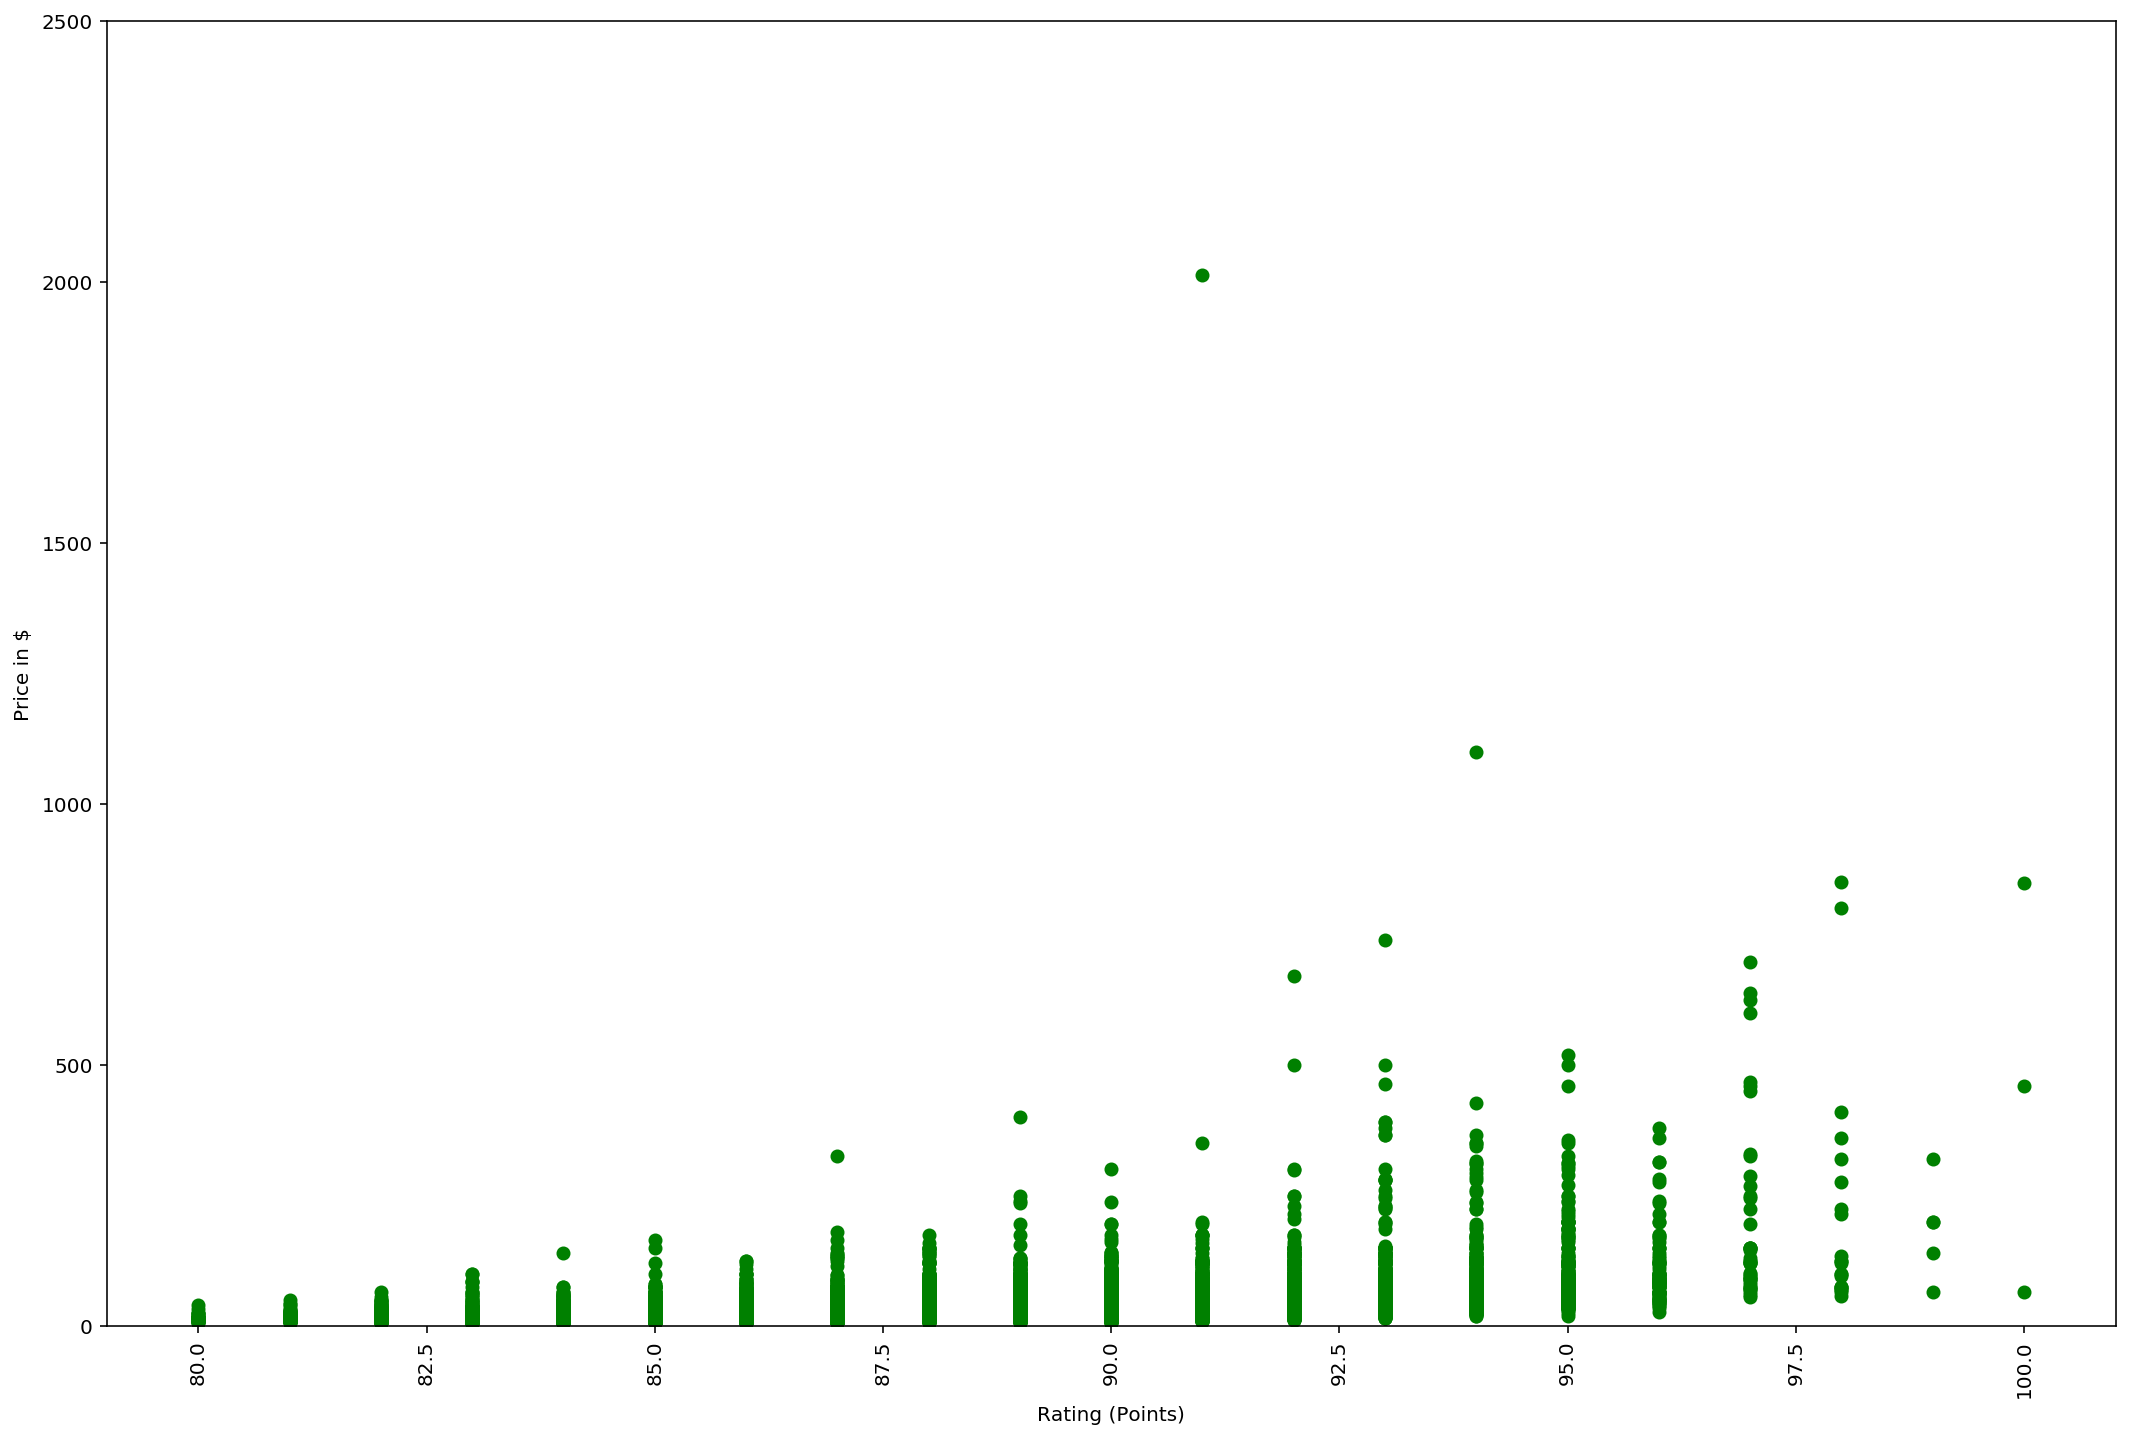

In [11]:
# Plot scatter plots
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,12))
ax = fig.gca()

plt.ylim(0, 2500)
plt.xlabel(r'Rating (Points)')
plt.ylabel(r'Price in $')
# plt.legend(loc='upper left')
# actual known points
plt.scatter(x = winesub['points'] ,y=winesub['price'],c='g')
plt.xticks(rotation=90)
plt.show()

C:\Users\bless\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


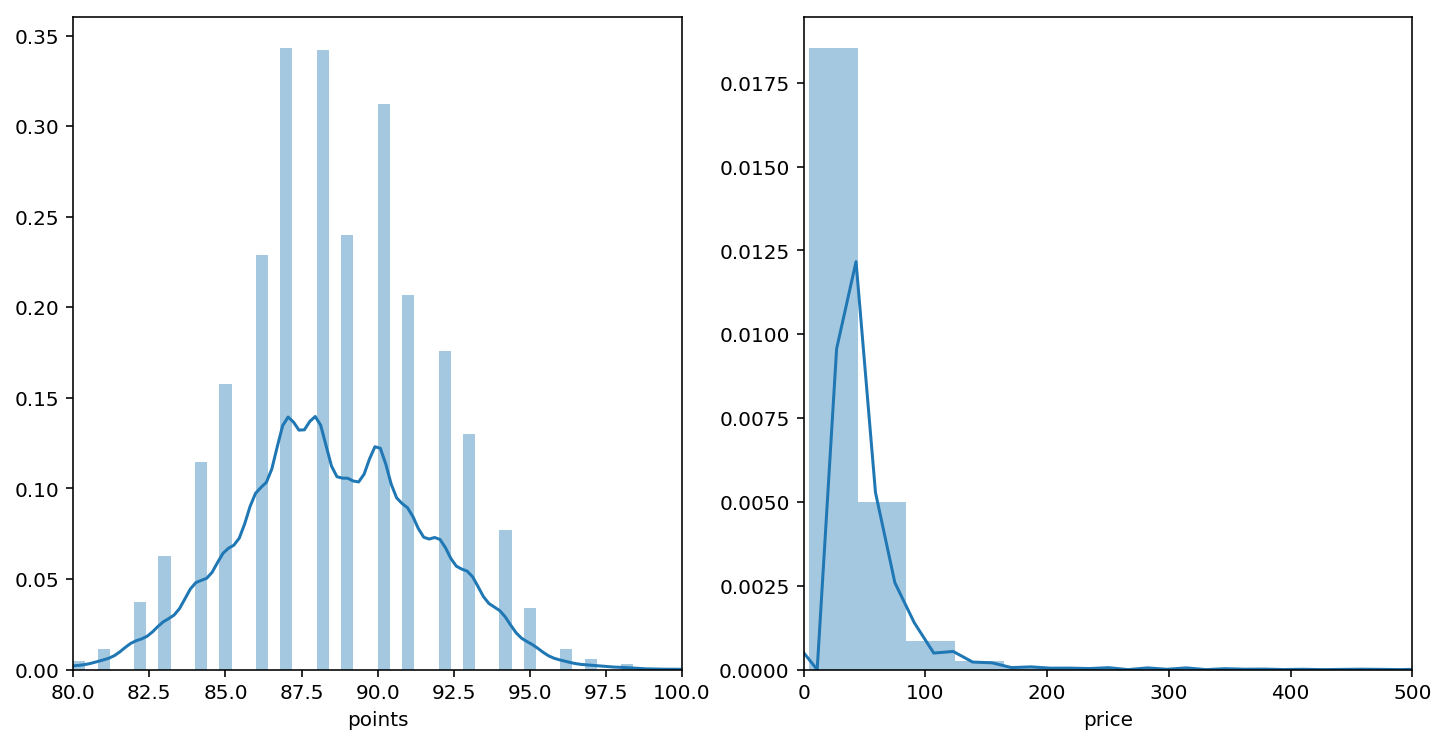

In [30]:
# Plot distributions of points and price  
fig, ax =plt.subplots(1,2,figsize=(12,6))

sns.distplot(winesub['points'],ax=ax[0]).set(xlim=(80,100))

sns.distplot(winesub['price'],ax=ax[1]).set(xlim=(0, 500))

fig.show()

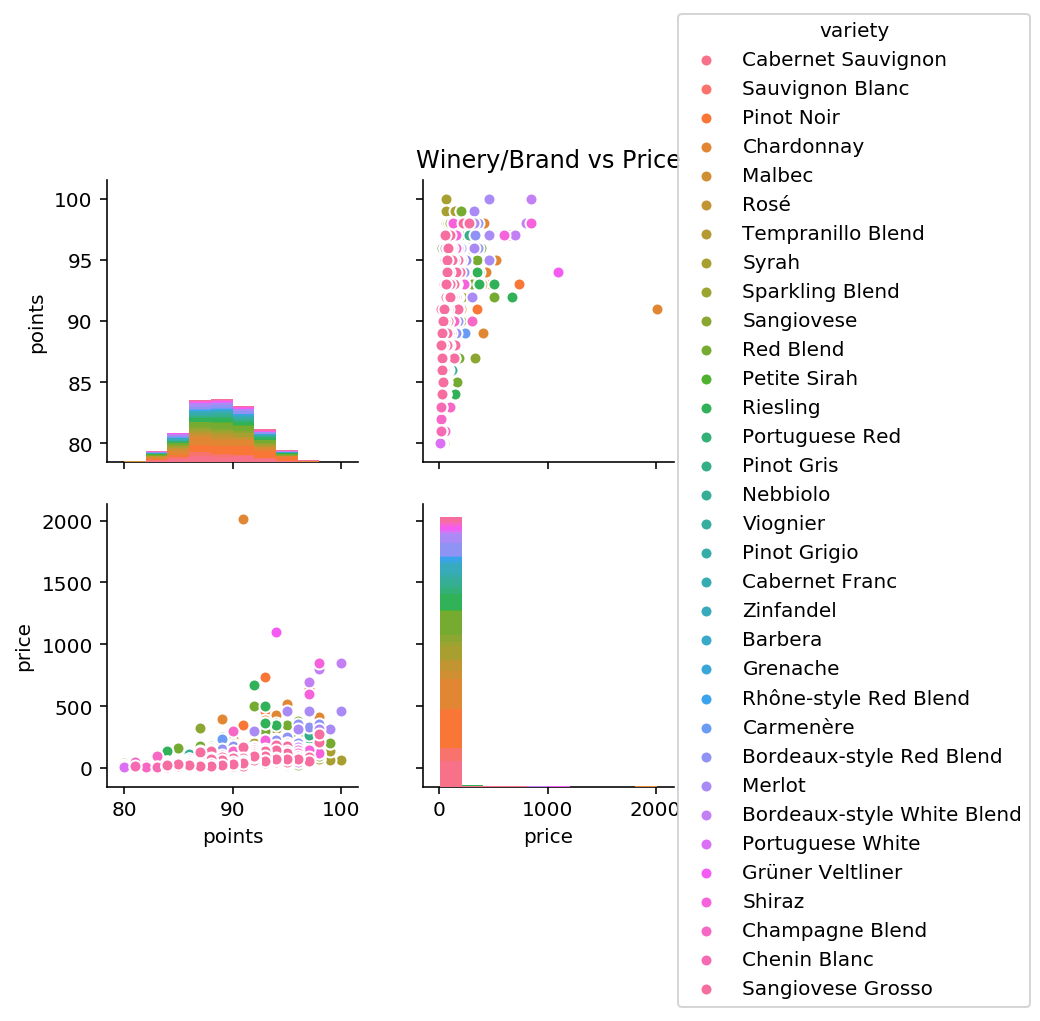

In [31]:
# Look at the wine variety and distribution

g = sns.pairplot(data=winesub, hue='variety')
# g = (g.set(xlim=(80,101),ylim=(0,2500)))
plt.title("Winery/Brand vs Price")
plt.show(g)


No handles with labels found to put in legend.


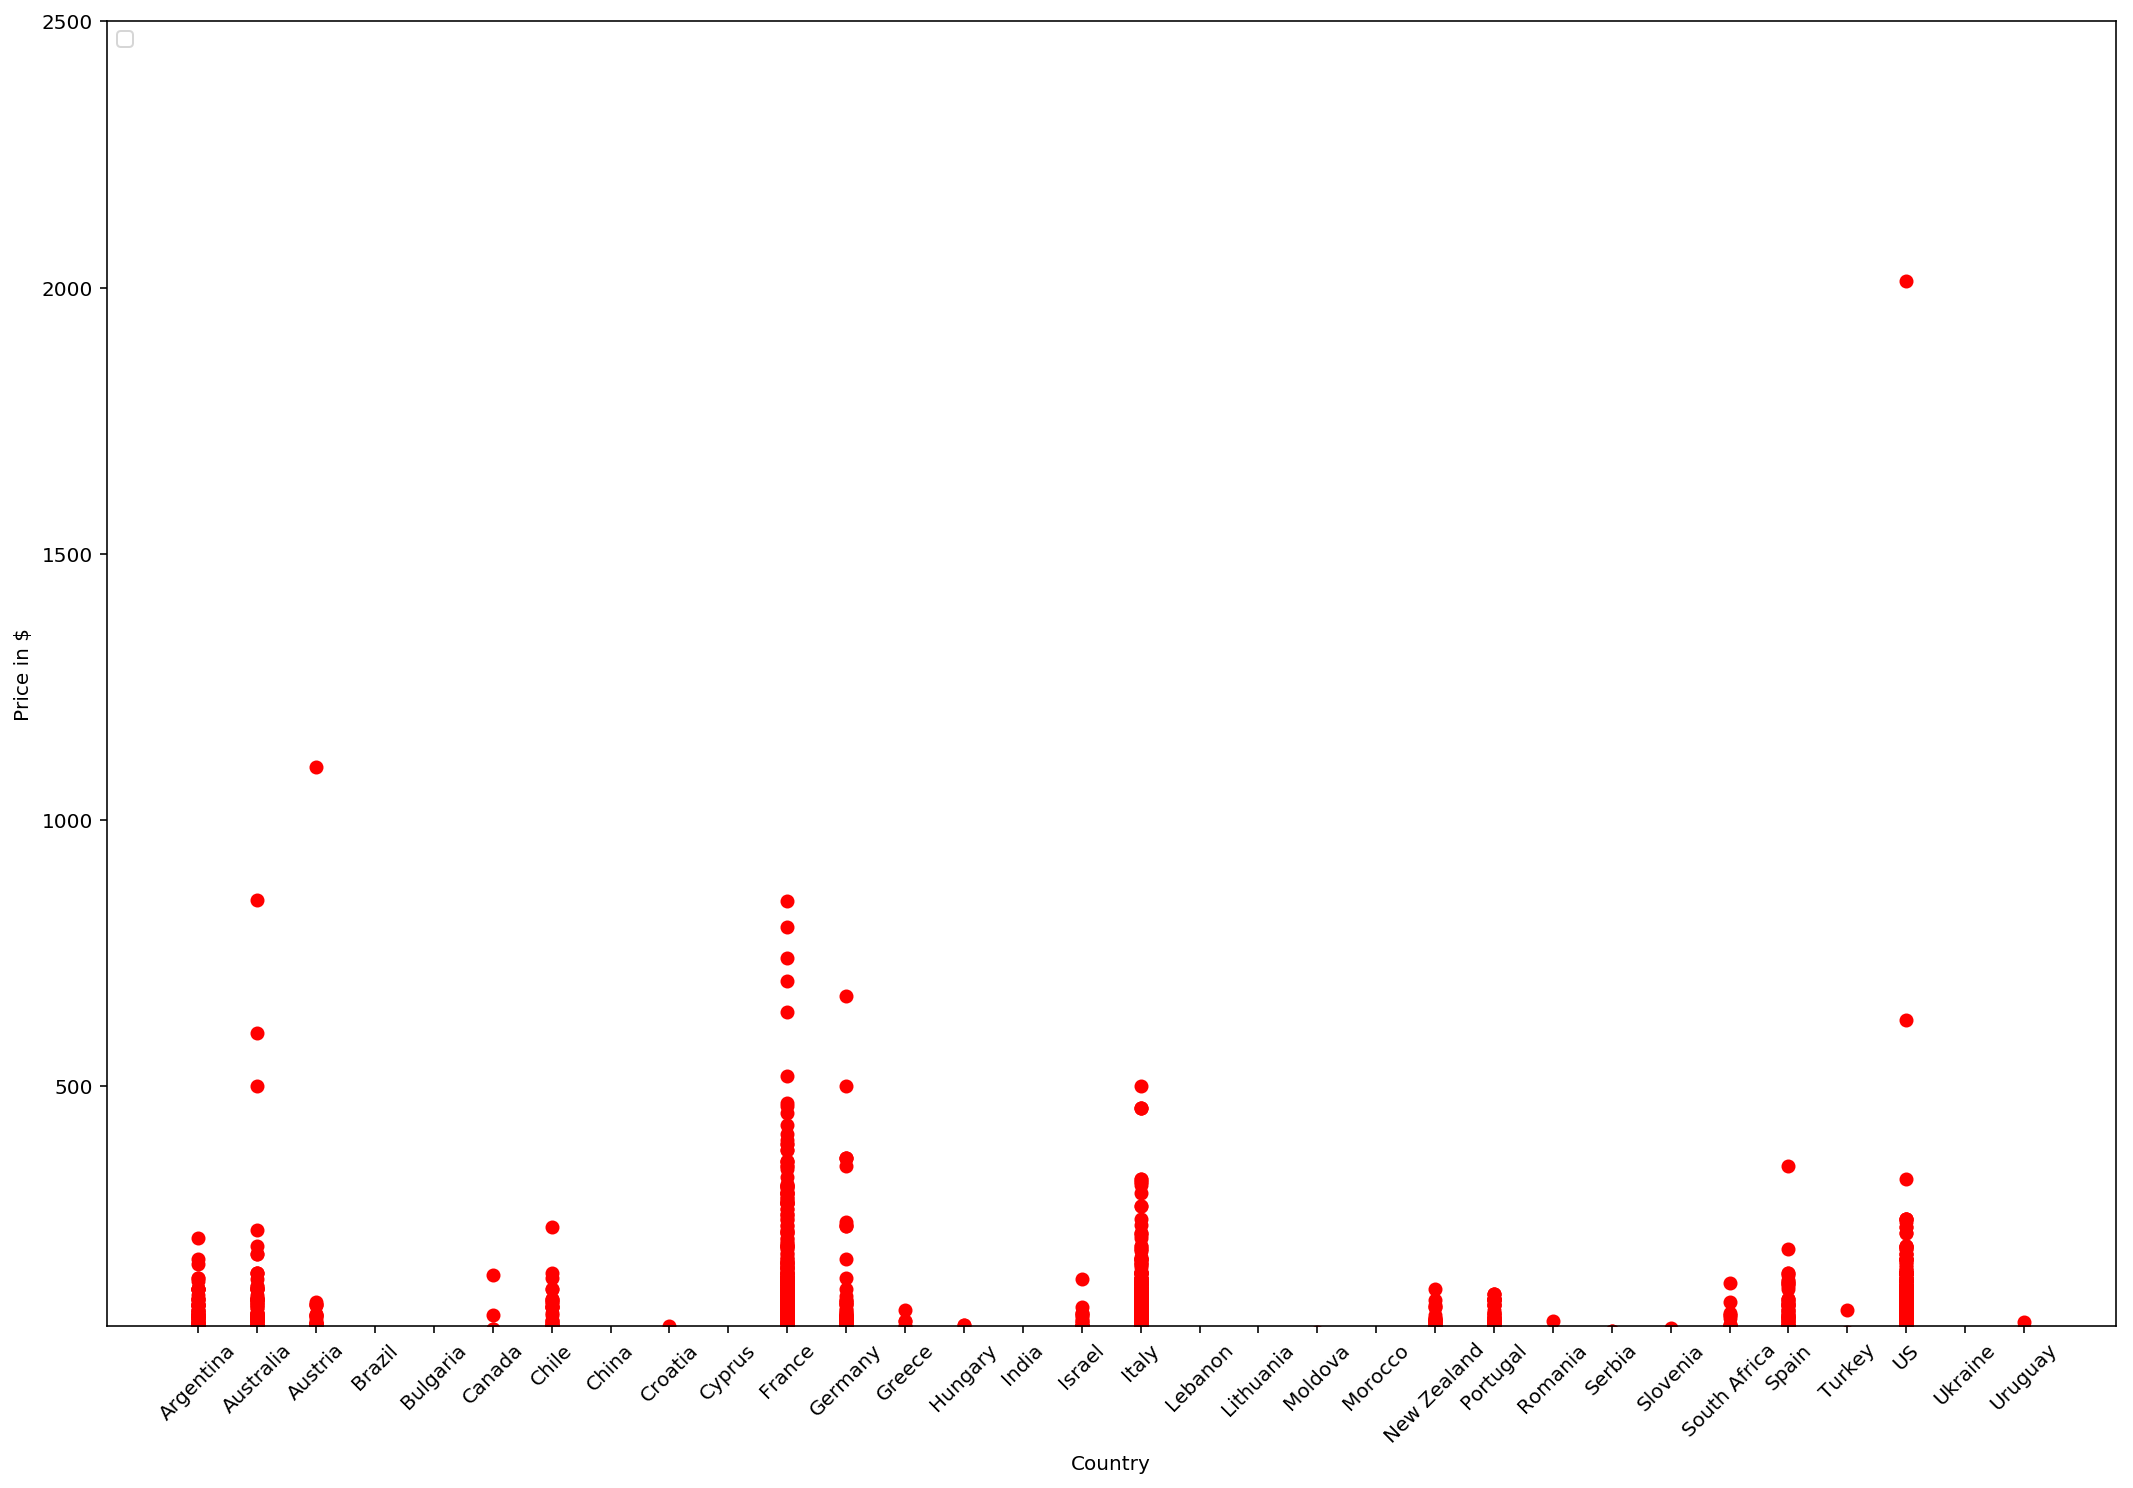

In [32]:
# Plot scatter plots
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,12))
ax = fig.gca()

plt.ylim(50, 2500)
plt.xlabel(r'Country')
plt.ylabel(r'Price in $')
plt.legend(loc='upper left')
# actual known points
plt.scatter(x = winesub['country'] ,y=winesub['price'],c='r')
plt.xticks(rotation=45)
plt.show()

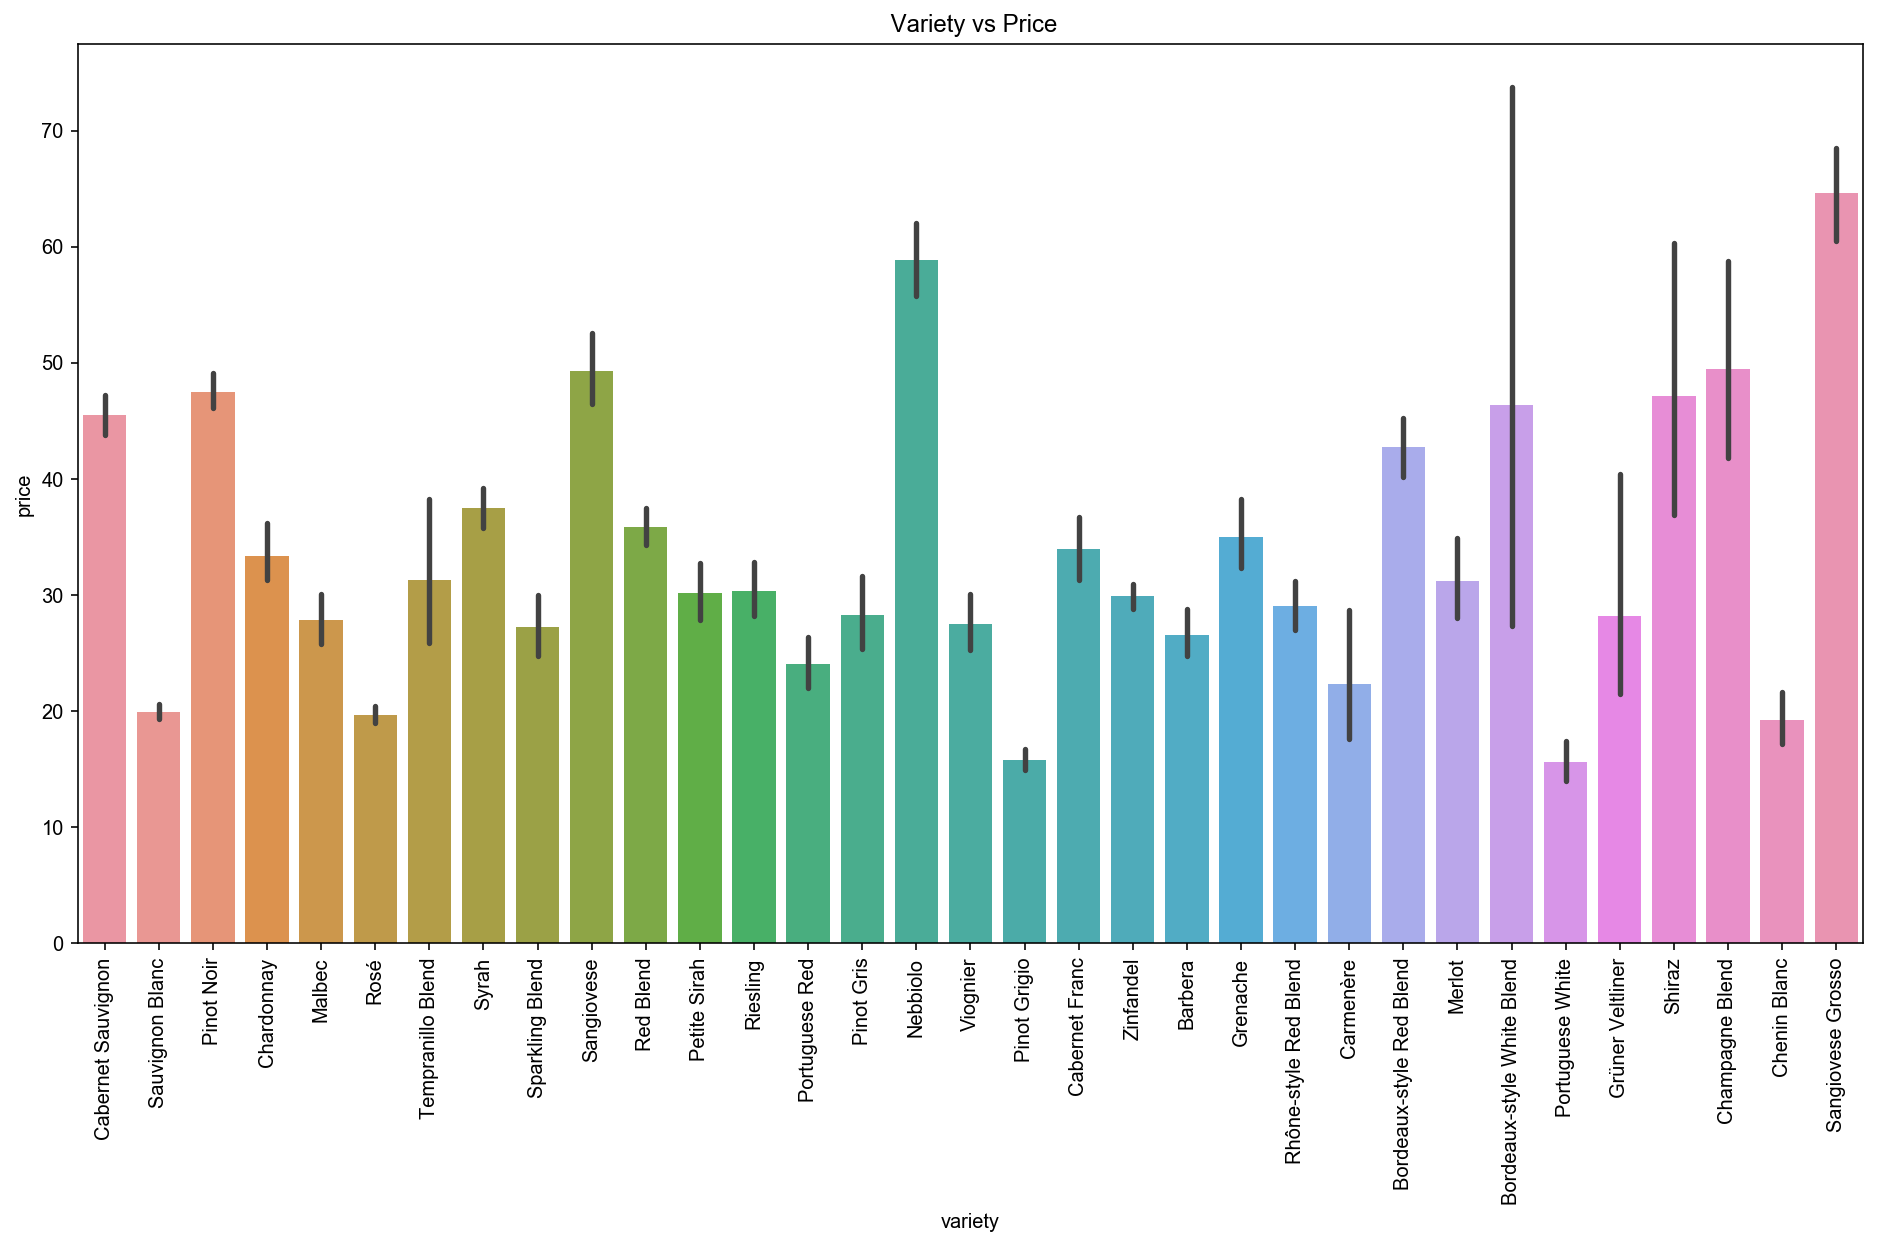

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

a4_dims = (16, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.set_style("whitegrid")
sns.barplot(x="variety", y="price", data=winesub,ax=ax)
# g = sns.lmplot(x="Segment", y="Revenue", data=winesales, aspect=2)

# g = (g.set_axis_labels("Returns","Revenue").set(xlim=(70,101),ylim=(0,120000)))
     
plt.title(" Variety vs Price")
plt.xticks(rotation=90)
 
plt.show(g)

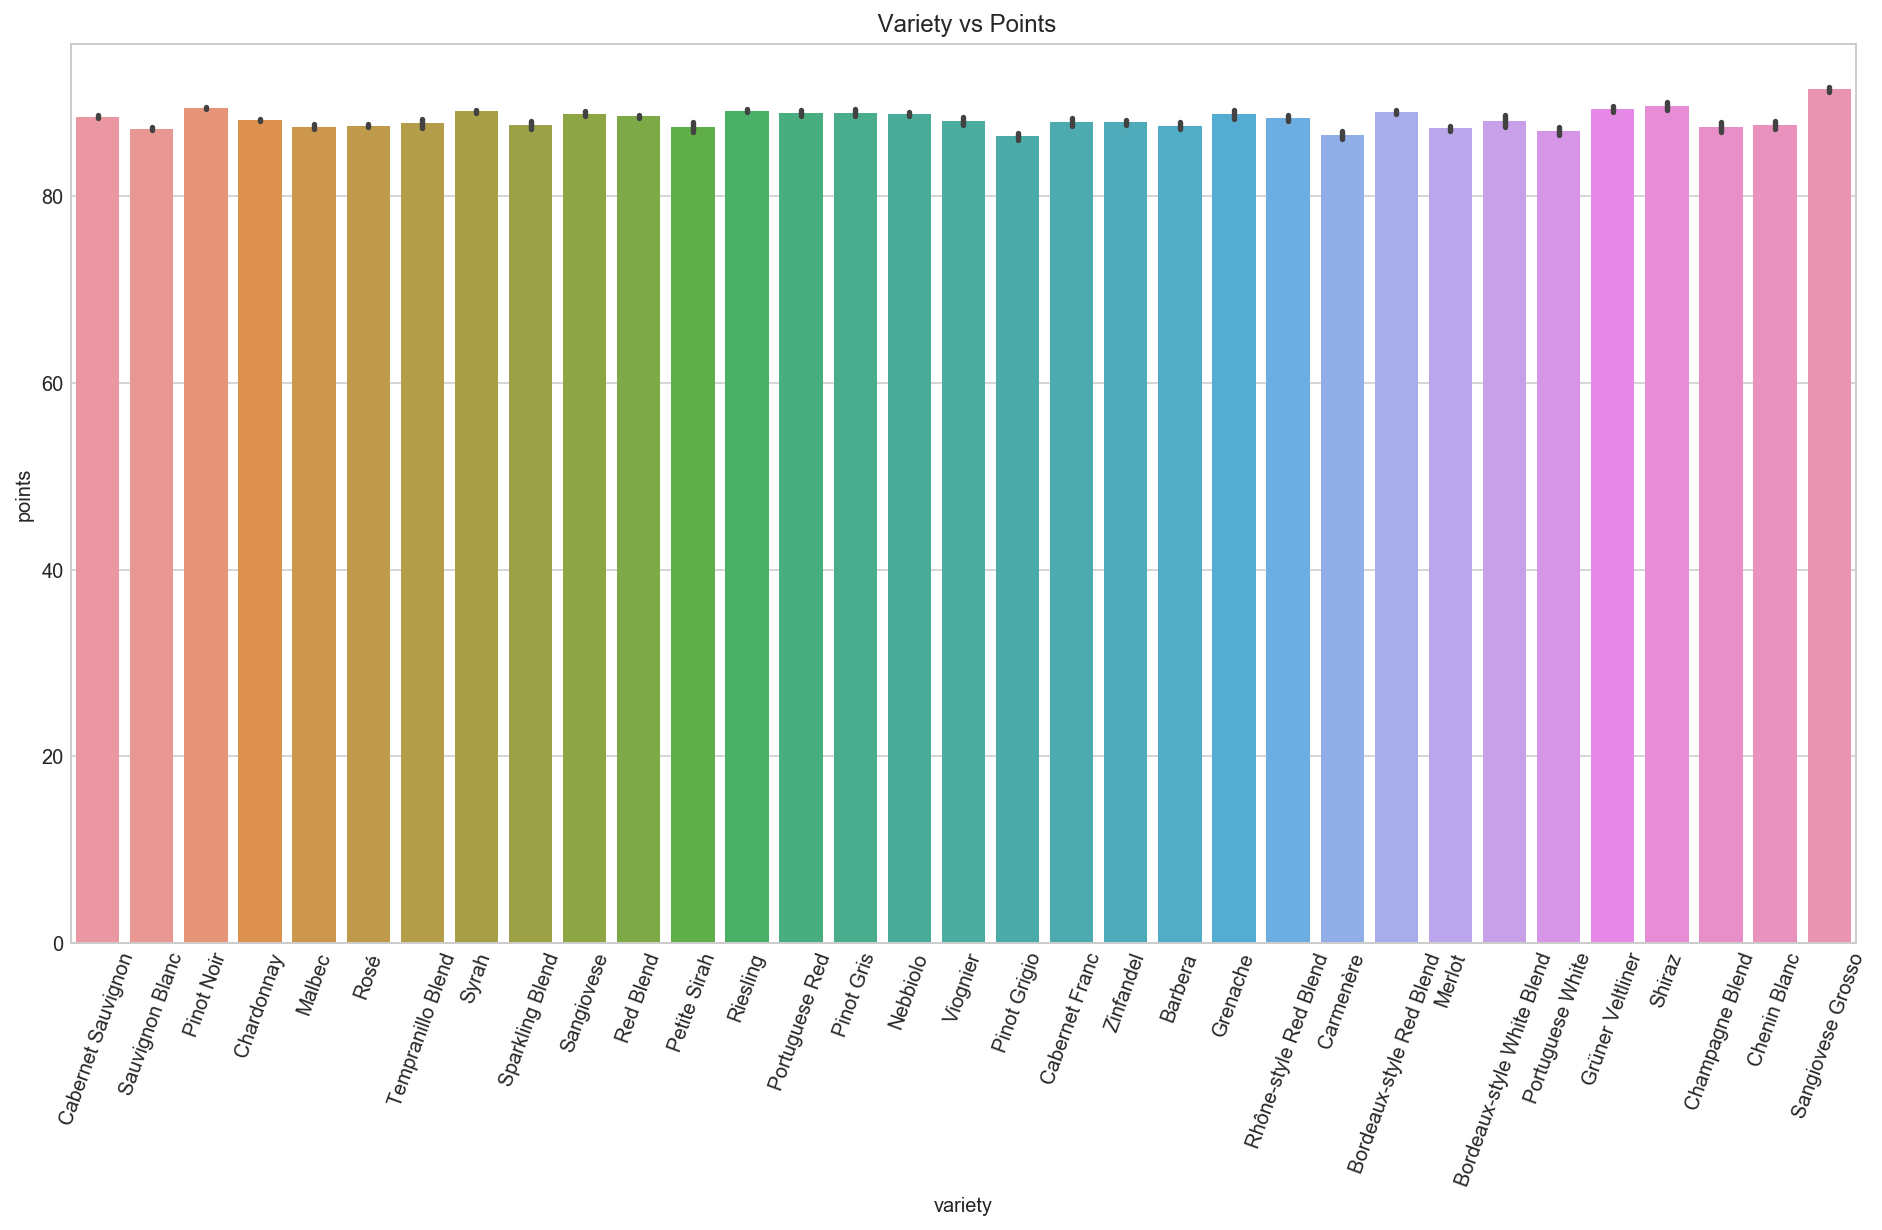

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

a4_dims = (16, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.set_style("whitegrid")
sns.barplot(x="variety", y="points", data=winesub,ax=ax)
# g = sns.lmplot(x="Segment", y="Revenue", data=winesales, aspect=2)

# g = (g.set_axis_labels("Returns","Revenue").set(xlim=(70,101),ylim=(0,120000)))
     
plt.title(" Variety vs Points")
plt.xticks(rotation=70)
 
plt.show(g)

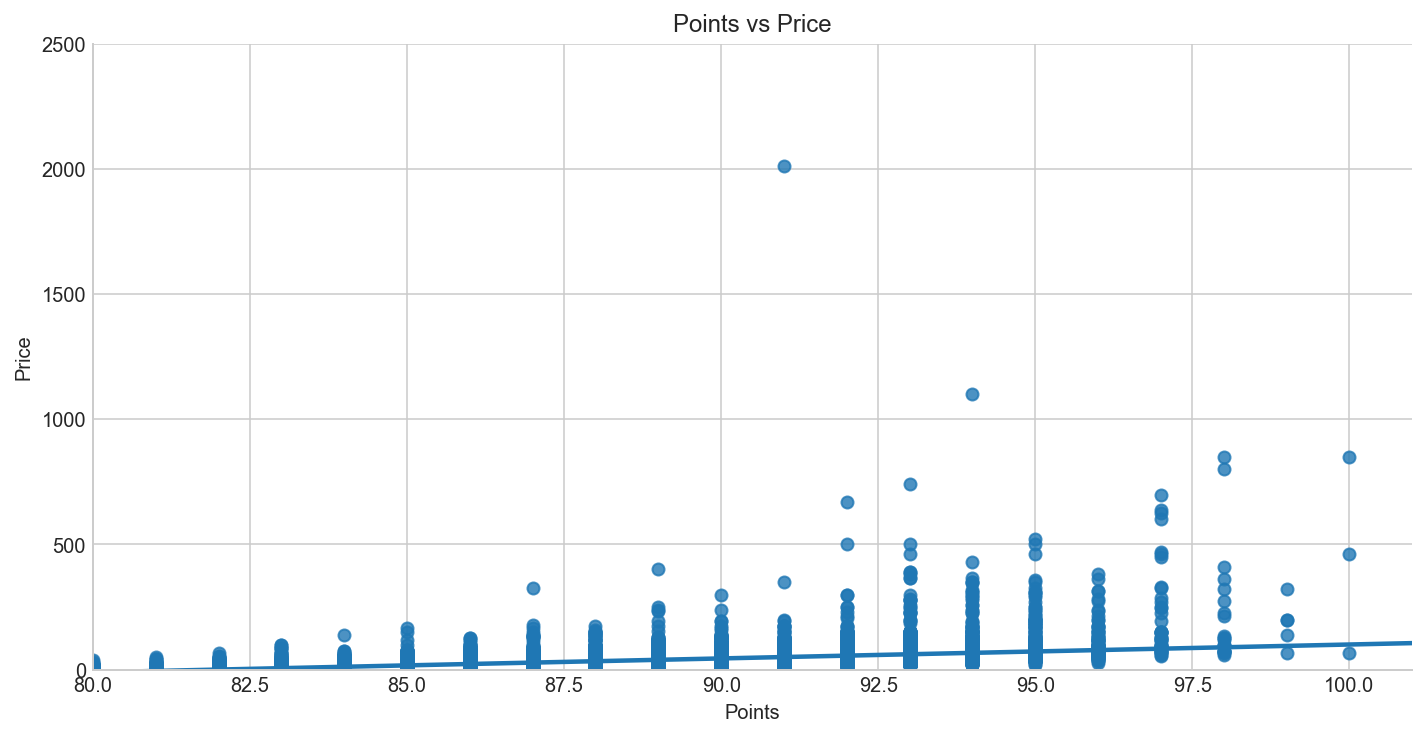

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# a4_dims = (11.7, 8.27)
# fig, ax = plt.subplots(figsize=a4_dims)
sns.set_style("whitegrid")
g = sns.lmplot(x="points", y="price", data=winesub, aspect=2,size=5)
g = (g.set_axis_labels("Points","Price").set(xlim=(80,101),ylim=(0,2500)))
plt.title("Points vs Price")
plt.show(g)


In [36]:
# Remove all the 5 outliers in price ie > $1000
winetrim=winesub[winesub['price']  <= 1000]
# winetrim.describe(include='all')

In [37]:
winetrim.corr()

points     price
points  1.000000  0.467143
price   0.467143  1.000000

In [38]:
winetrim=winetrim.reset_index(drop=True)

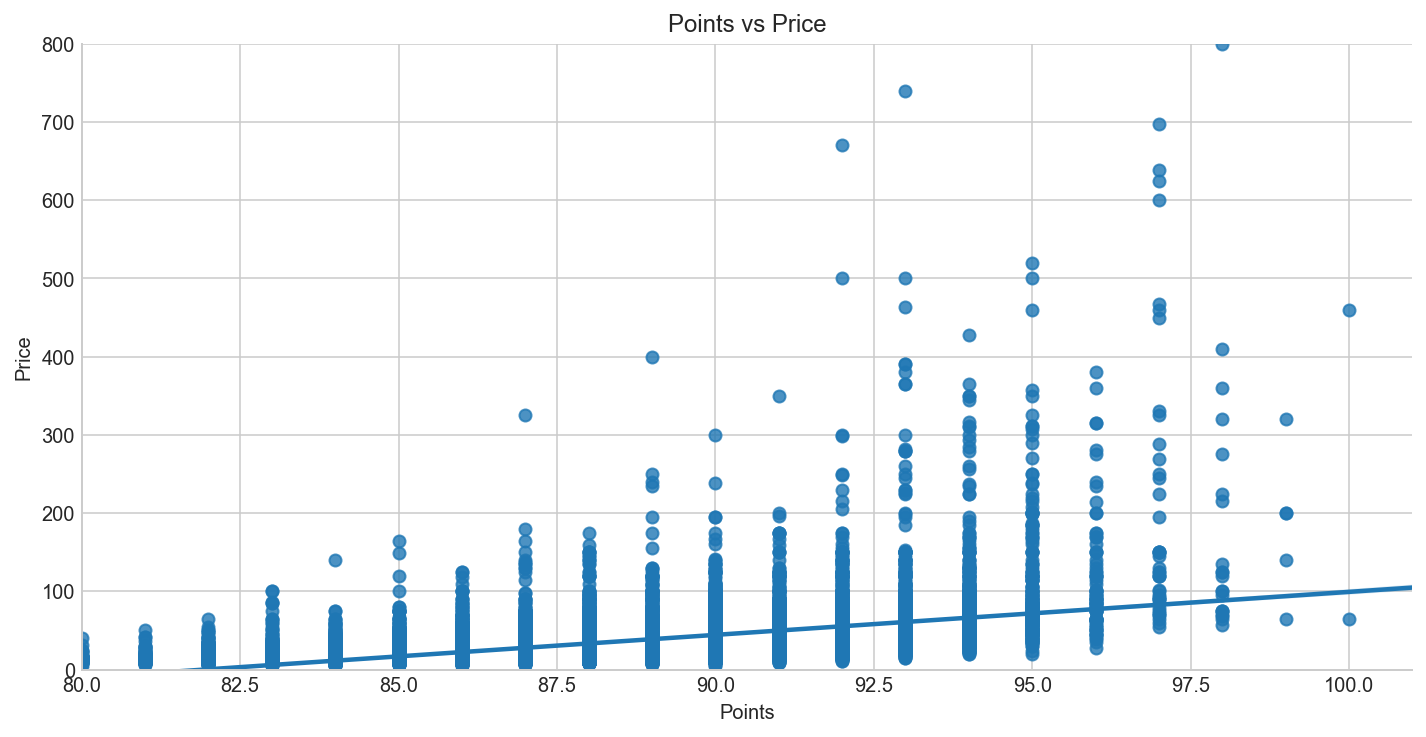

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# a4_dims = (11.7, 8.27)
# fig, ax = plt.subplots(figsize=a4_dims)
sns.set_style("whitegrid")
g = sns.lmplot(x="points", y="price", data=winetrim, aspect=2,size=5)
g = (g.set_axis_labels("Points","Price").set(xlim=(80,101),ylim=(0,800)))
plt.title("Points vs Price")
plt.show(g)

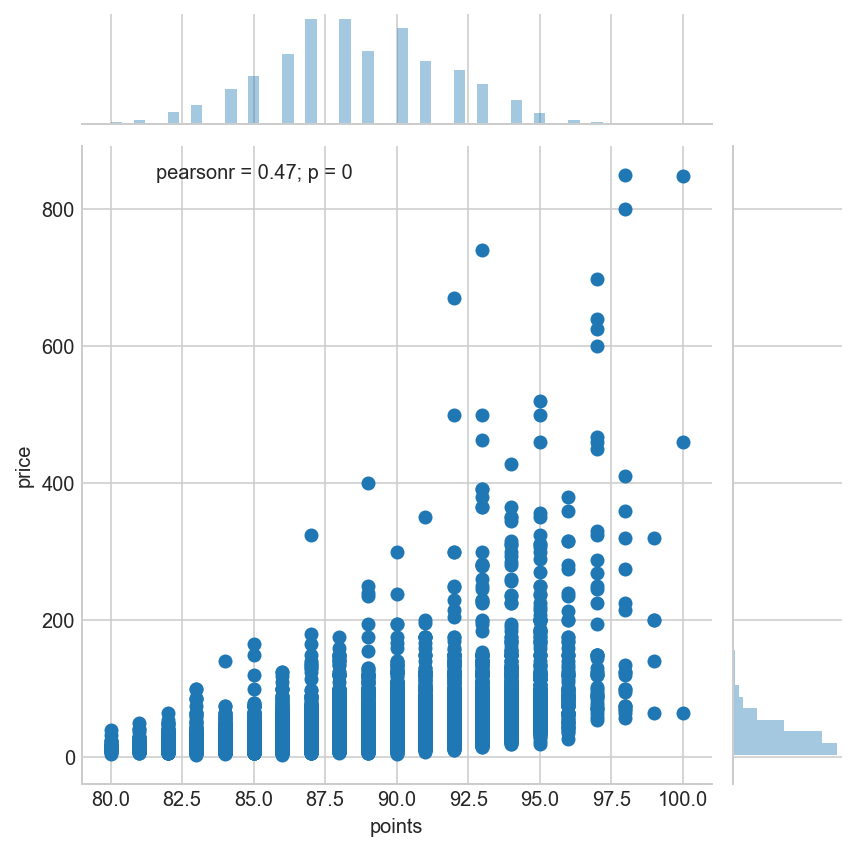

In [40]:
sns.jointplot(x="points", y="price", data=winetrim)

In [41]:
# transform Variety data using dummy variables 

winesubext = pd.concat([winetrim, pd.get_dummies(winetrim['variety'],prefix='grapevar_')], axis=1)

In [42]:
winesubext.variety.value_counts()

Pinot Noir                    2697
Chardonnay                    2014
Cabernet Sauvignon            1755
Red Blend                     1624
Riesling                      1051
Bordeaux-style Red Blend       911
Syrah                          896
Sauvignon Blanc                877
Rosé                           666
Merlot                         601
Malbec                         558
Zinfandel                      508
Sangiovese                     495
Portuguese Red                 379
Nebbiolo                       303
Sangiovese Grosso              291
Pinot Gris                     283
Rhône-style Red Blend          279
Sparkling Blend                236
Cabernet Franc                 201
Viognier                       200
Grüner Veltliner               194
Shiraz                         178
Portuguese White               145
Pinot Grigio                   132
Tempranillo Blend              131
Grenache                       130
Bordeaux-style White Blend     122
Chenin Blanc        

In [43]:
# Determine the Varieties as features 
# missing varieties - u'grapevar__Gamay',u'grapevar__Gewurztraminer'

variety=[u'grapevar__Barbera',u'grapevar__Bordeaux-style Red Blend',u'grapevar__Bordeaux-style White Blend',
              u'grapevar__Cabernet Franc',u'grapevar__Cabernet Sauvignon',u'grapevar__Carmenère',u'grapevar__Champagne Blend',
              u'grapevar__Chardonnay',u'grapevar__Chenin Blanc',
              u'grapevar__Grenache',u'grapevar__Grüner Veltliner',u'grapevar__Malbec',u'grapevar__Merlot',u'grapevar__Nebbiolo',
              u'grapevar__Petite Sirah',u'grapevar__Pinot Grigio',u'grapevar__Pinot Gris',u'grapevar__Pinot Noir',
              u'grapevar__Portuguese Red',u'grapevar__Portuguese White',u'grapevar__Red Blend',u'grapevar__Rhône-style Red Blend',
              u'grapevar__Riesling',u'grapevar__Rosé',u'grapevar__Sangiovese',u'grapevar__Sangiovese Grosso',u'grapevar__Sauvignon Blanc',
              u'grapevar__Shiraz',u'grapevar__Sparkling Blend',u'grapevar__Syrah',u'grapevar__Tempranillo Blend',
              u'grapevar__Viognier',u'grapevar__Zinfandel']
winevariety=winesubext[variety]
# winevariety.describe()

In [44]:
# Linear regression to determine relationships beteen X and Y 
# choose X and Y 

def lregress (X,y,labelX,labely):

    # split data into test and train and then apply cross validation 

    from sklearn.cross_validation import train_test_split
    # split the data with 50% in each set

    X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                      train_size=0.50)
    # OLS regression 

    X = sm.add_constant(X)
    # Note the difference in argument order
    model = sm.OLS(y1, X1).fit()
    # model.summary()
    # predictions = model.predict(X) # make the predictions by the model

    y2_predicted = model.predict(X2)
    model.summary()
    # y2_model
    
    prediction_error = y2 - y2_predicted
    prediction_error

    df1 = pd.DataFrame()
    df1[labely]  = y2
#     df1[labelX] = X2
    df1['predicted y']=y2_predicted
    df1['Residuals'] = df1[labely] -df1['predicted y']
    df1[labely].dropna
    df1['predicted y'].dropna()
    df1['Residuals'].dropna()
    
   
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
  
    sns.distplot(df1['Residuals']) 
    return model.summary() ,sns.lmplot(x=labely, y='predicted y', data=df1)
         

X feature eg points: points
y to be predicted eg price: price


C:\Users\bless\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                  price   R-squared:                       0.522
 Model:                            OLS   Adj. R-squared:                  0.522
 Method:                 Least Squares   F-statistic:                 1.004e+04
 Date:                Sun, 27 May 2018   Prob (F-statistic):               0.00
 Time:                        18:23:16   Log-Likelihood:                -45692.
 No. Observations:                9178   AIC:                         9.139e+04
 Df Residuals:                    9177   BIC:                         9.139e+04
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

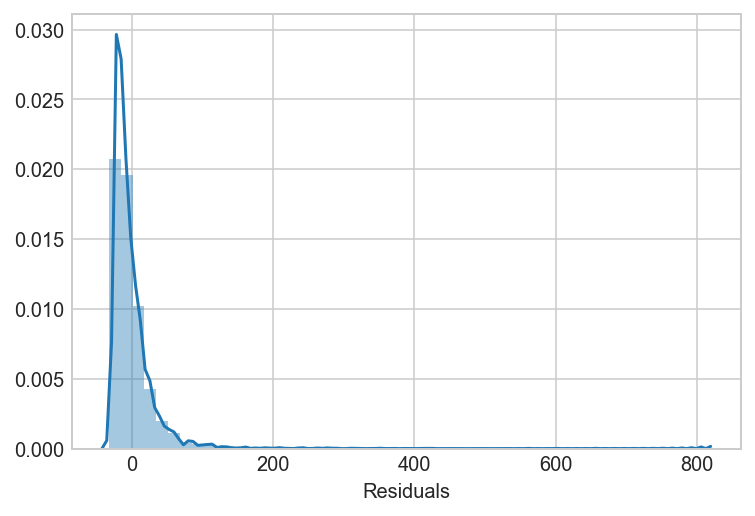

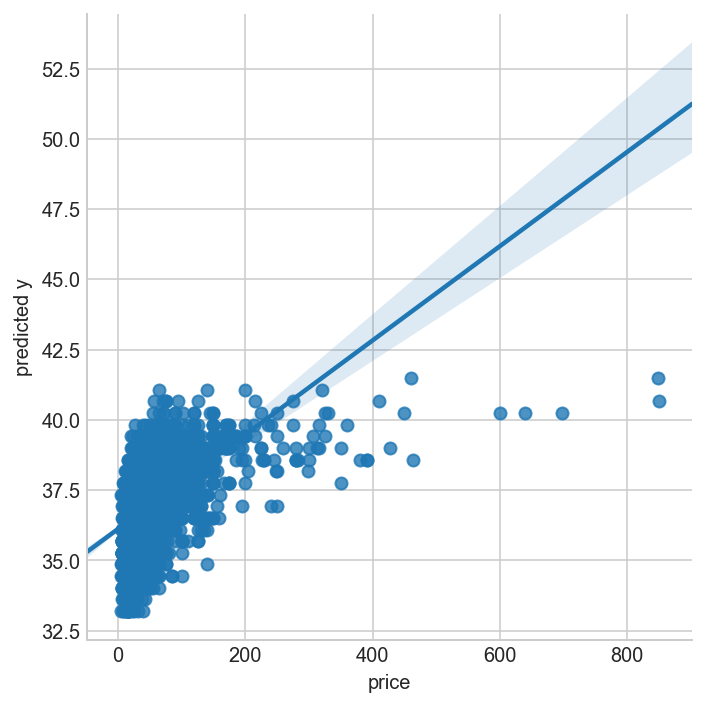

In [45]:
# choose X and Y for linear regression eg Points vs Price

nameX=input("X feature eg points: ")
namey = input('y to be predicted eg price: ')

dataX = winetrim[nameX]
datay = winetrim[namey]

lregress(dataX,datay,nameX,namey)

In [46]:
# setup tokennizer NLP for wine reviews description 
from collections import defaultdict
from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
%matplotlib inline
# define X and y
XX = winetrim['description'].values
yy = winetrim['points'].values
zz = winetrim['price'].values

In [47]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stop_words = list(ENGLISH_STOP_WORDS)

# You can of course add your own custom stopwords
custom_stop_words.append('wine')
custom_stop_words.append('bordeaux')

In [48]:
# use the count vectorizer to compare results 
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 5),max_features=500,stop_words='english')
X_train_dtm = vect.fit_transform(XX)
countfeatures=vect.get_feature_names()
X_train_dtm.shape
len(countfeatures)
# # last 50 features
print (countfeatures[-50:])

['tight', 'tightly', 'time', 'toast', 'toasted', 'toasty', 'tobacco', 'tomato', 'tones', 'touch', 'touches', 'tropical', 'tropical fruit', 'valley', 'value', 'vanilla', 'varietal', 'variety', 'velvety', 'verdot', 'vibrant', 'vines', 'vineyard', 'vineyards', 'vintage', 'violet', 'warm', 'way', 'weight', 'wet', 'whiff', 'white', 'white pepper', 'wild', 'wine', 'wine offers', 'wine shows', 'winemaker', 'winery', 'wines', 'wood', 'wood aging', 'wrapped', 'year', 'years', 'yellow', 'young', 'zest', 'zesty', 'zinfandel']


In [49]:
# # create a DF based on the combined vectors outputs from the count vectorizer
dfwinerate2=pd.DataFrame(data=X_train_dtm.todense(),columns=countfeatures)
# dfwinerate2.head(4)

In [50]:
dfwinerate2.head(5)

10  100  20  2015  2016  2017  2018  2019  2020  accented  accents  acid  \
0   0    1   0     0     0     0     0     0     0         0        0     0   
1   0    0   0     0     0     0     0     0     0         0        0     0   
2   0    0   1     0     0     0     0     0     0         0        0     0   
3   0    0   0     0     0     0     0     0     0         0        1     0   
4   0    0   0     0     0     0     0     0     0         0        0     0   

   acidic  acidity  acids  add  adds  aftertaste  age  aged  aging  alcohol  \
0       0        0      0    0     0           0    0     1      0        0   
1       0        0      0    0     0           0    0     0      0        0   
2       0        0      0    0     0           0    0     0      0        0   
3       0        0      0    0     0           0    0     0      0        0   
4       0        1      0    0     0           0    0     0      0        0   

   almond  alongside  ample  anise  appealing  appellation  apple  apple pear  \
0       0          0      0      0          0            0      0           0   
1       0          0      0      0          0            0      0           0   
2       0          0      0      0          0            0      0           0   
3       0          0      0      0          0            0      0           0   
4       0          0      0      0          0            0      0           0   

   apples  approachable  apricot  aroma  aromas  aromas flavors  aromatic  \
0       0             0        0      0       0               0         0   
1       0             0        0      0       0               0         0   
2       0             0        0      0       1               1         1   
3       0             0        0      0       0               0         0   
4       0             0        0      0       0               0         0   

   astringent  attractive  bacon  baked  baking  baking spice  balance  \
0           0           0      0      0       0             0        0   
1           0           0      0      0       0             0        0   
2           0           0      0      0       0             0        0   
3           0           0      0      0       0             0        0   
4           0           0      0      0       0             0        0   

   balanced  barrel  based  beautiful  beautifully  beef  berries  berry  \
0         1       0      0          0            0     0        0      0   
1         1       0      0          0            0     0        0      0   
2         0       0      0          0            0     0        0      0   
3         0       0      0          0            0     0        0      0   
4         0       0      0          0            0     0        0      0   

   berry flavors  berry fruit  berry fruits  best  better  big  bit  bitter  \
0              0            0             0     0       0    0    0       0   
1              0            0             0     0       0    0    0       0   
2              0            0             0     0       0    0    0       0   
3              0            0             0     0       0    0    0       0   
4              0            0             0     0       0    0    0       0   

   black  black cherry  black currant  black fruit  black fruits  \
0      0             0              0            0             0   
1      0             0              0            0             0   
2      1             1              0            0             0   
3      1             0              0            0             1   
4      0             0              0            0             0   

   black pepper  black plum  blackberries  blackberry  blackberry cherry  \
0             0           0             0           0                  0   
1             0           0             0           0                  0   
2             0           0             0           1                  0   
3            

X feature eg bag of words from vectorizer: words
y to be predicted eg points : points


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.955
 Model:                            OLS   Adj. R-squared:                  0.952
 Method:                 Least Squares   F-statistic:                     366.3
 Date:                Sun, 27 May 2018   Prob (F-statistic):               0.00
 Time:                        18:24:31   Log-Likelihood:                -39971.
 No. Observations:                9178   AIC:                         8.094e+04
 Df Residuals:                    8678   BIC:                         8.451e+04
 Df Model:                         500                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

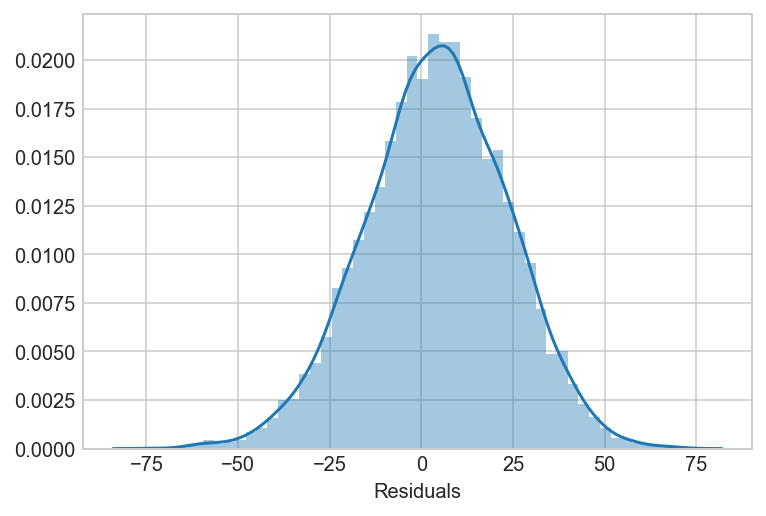

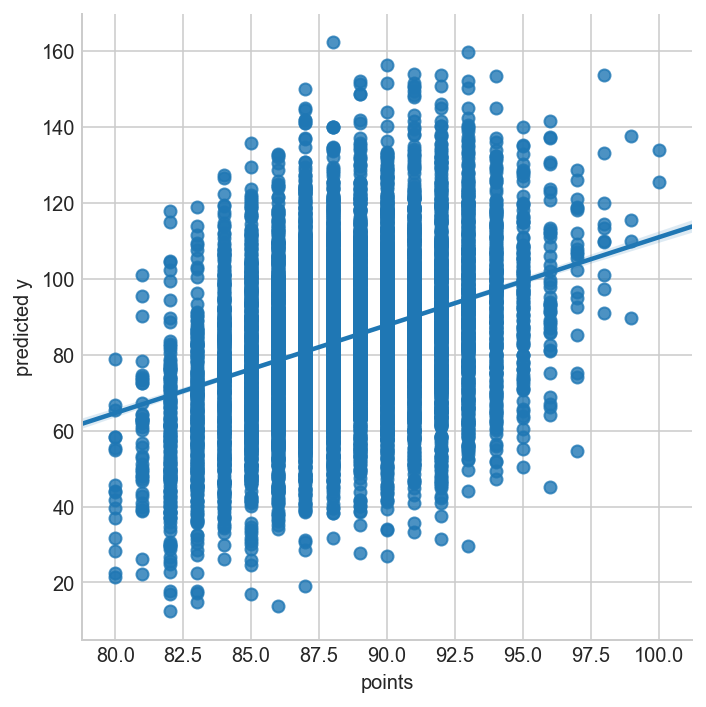

In [52]:
# Run linear regression of words vectoriser scores vs Points 
# choose X and Y for linear regression 

nameX1=input("X feature eg bag of words from vectorizer: ")
namey1 = input('y to be predicted eg points : ')

dataX1 = dfwinerate2.values
datay1 = yy

lregress(dataX1,datay1,nameX1,namey1)


X feature eg bag of words from vectorizer: words
y to be predicted eg price : price


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.623
 Model:                            OLS   Adj. R-squared:                  0.602
 Method:                 Least Squares   F-statistic:                     28.71
 Date:                Sun, 27 May 2018   Prob (F-statistic):               0.00
 Time:                        18:24:50   Log-Likelihood:                -44604.
 No. Observations:                9178   AIC:                         9.021e+04
 Df Residuals:                    8678   BIC:                         9.377e+04
 Df Model:                         500                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

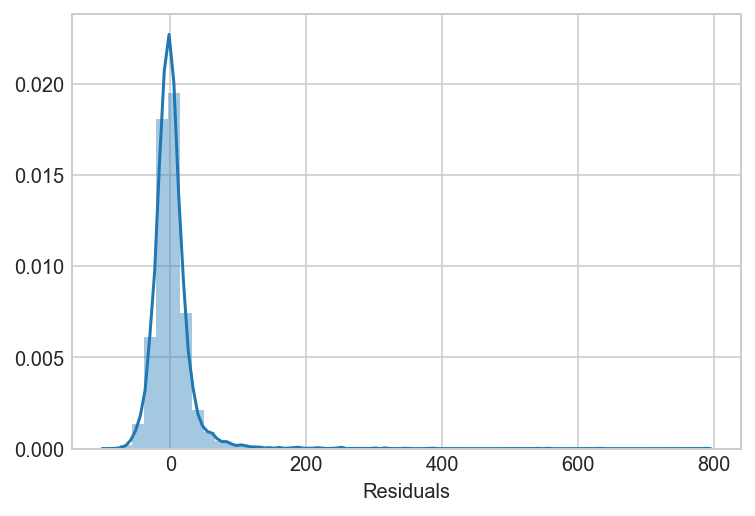

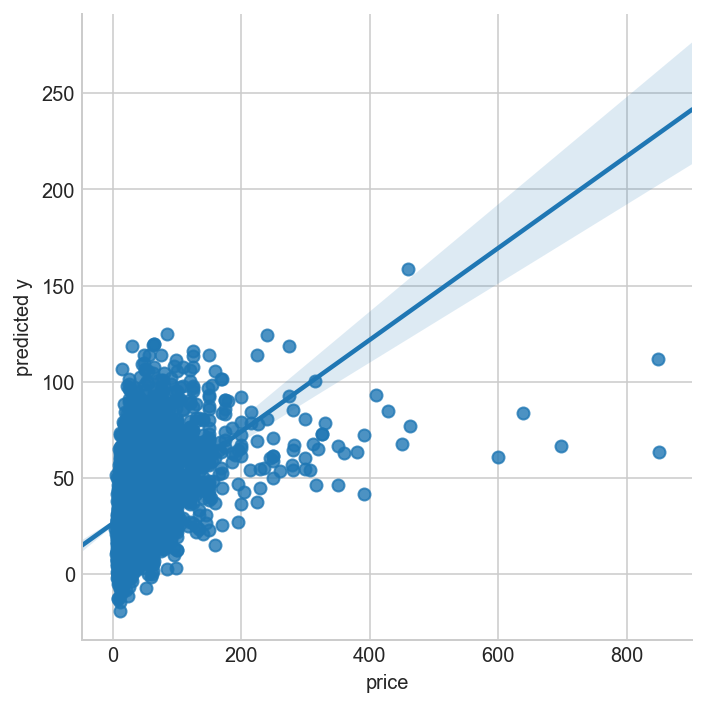

In [53]:
# Run linear regression of words vectoriser scores vs Price 
# choose X and Y for linear regression 

nameX1=input("X feature eg bag of words from vectorizer: ")
namey1 = input('y to be predicted eg price : ')

dataX1 = dfwinerate2.values
datay1 = zz

lregress(dataX1,datay1,nameX1,namey1)


In [58]:
# set up OVR logit regression for wine varieties using the word counts 

def logregress(grape_variety):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    # split data into Train and Test for  X and y_
    X = dfwinerate2.values  # array of 16345 rows x 500 words 
    # y = winevariety[u'grapevar__Barbera'] #array of  16345 rows x 1 for points 
    y = winevariety[grape_variety].values #array of  16345 rows x 1 for points 

    # split the new DataFrame into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,train_size=0.5)

    # Run Multinomial  Logit regression to check if description  terms can be used to predict variety  

#     model=LogisticRegression(multi_class='ovr',solver ='newton-cg').fit(X_train,y_train)
    model=LogisticRegressionCV(multi_class='ovr',solver ='liblinear',penalty='l1',Cs=100,cv=5).fit(X_train,y_train)
    # print model.summary()
    yhat = model.predict(X_test)  # will output array with integer values.

#     print (yhat, model.coef_,model.score, accuracy_score(y_test, yhat))
    
    # change the array into a list 
    import numpy as np
    modelcoef=np.array(model.coef_).tolist()
    len(modelcoef)
    len(countfeatures)
    
    # split the list into individual items
    import itertools
    words = list(itertools.chain(*modelcoef))
#     words
    
#     setup a dictionary with word counts and word labels
    varietydict = dict(zip(countfeatures,words))
#     varietydict

# add accuracy score and wine variety to dictionary
    varietydict['0Accuracy'] = accuracy_score(y_test, yhat)*100
   
#     varietydict
# sort the words with largest word counts first 
    sorted_d = sorted(varietydict.items(), key=lambda x: x[1],reverse=True)
#     sorted_d
    varietydict['0Grape'] = grape_variety

    # Calculate the confusion matrix metrics for your model below.¶
    from sklearn.metrics import classification_report
    print(grape_variety,'\n',classification_report(y_test, yhat))
    

#     get top 50 words scores 
    results=[grape_variety]+sorted_d[:500]
    return results

In [ ]:
# Run logit regression of words vectoriser scores vs variety of grapes for all grapes variety

# choose X and Y for linear regression 
dfwinefinal= pd.DataFrame()

for w in winevariety:
    #     print(w)
    # grapename = input('enter grape variety:')
#     ugrape='grapevar__'+grapename
    ugrape=w

    dfwinefinal[ugrape]=logregress(ugrape)
dfwinefinal

X feature eg words: words
y to be predicted eg price: price


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                  price   R-squared:                       0.623
 Model:                            OLS   Adj. R-squared:                  0.602
 Method:                 Least Squares   F-statistic:                     28.71
 Date:                Sun, 27 May 2018   Prob (F-statistic):               0.00
 Time:                        21:19:32   Log-Likelihood:                -44604.
 No. Observations:                9178   AIC:                         9.021e+04
 Df Residuals:                    8678   BIC:                         9.377e+04
 Df Model:                         500                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

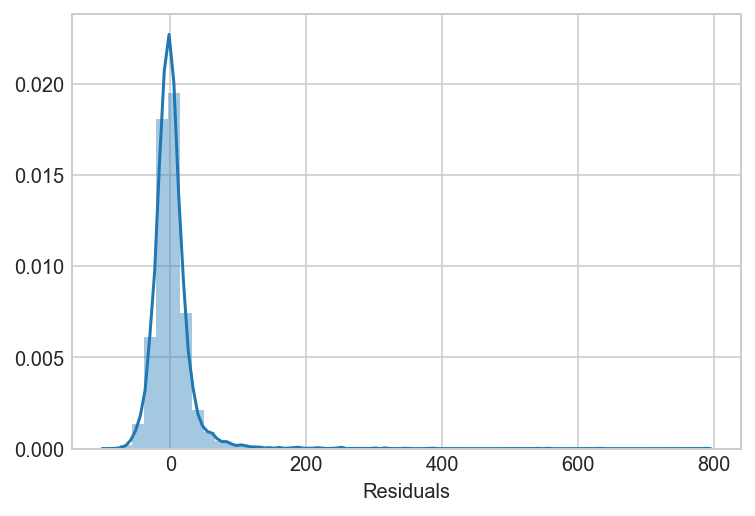

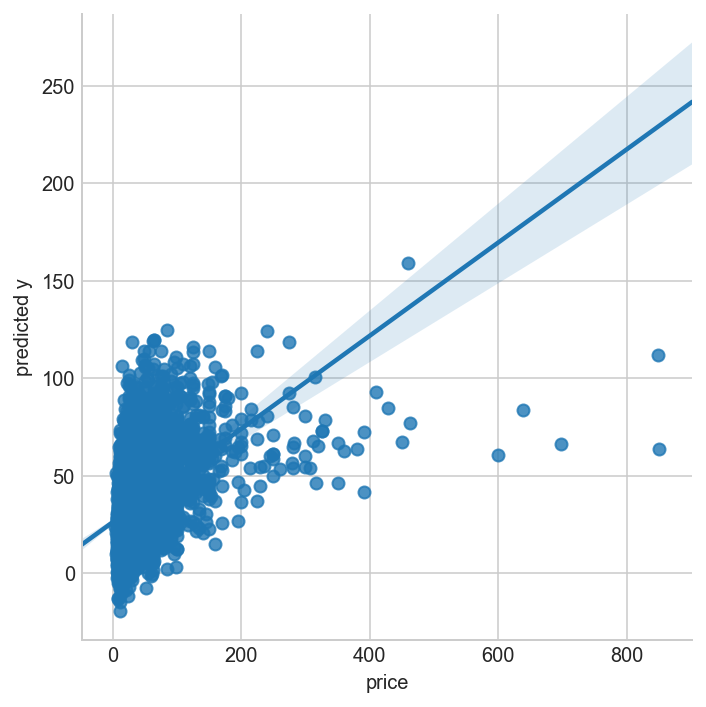

In [61]:
# choose X and Y for linear regression using price and words 

nameX=input("X feature eg words: ")
namey = input('y to be predicted eg price: ')

# dataX = winetrim[nameX]
dataX=dfwinerate2.values
datay = winetrim[namey]

lregress(dataX,datay,nameX,namey)

In [62]:
# find number of counst of each variety

pd.value_counts(winetrim['variety'].values, sort=True)

Pinot Noir                    2697
Chardonnay                    2014
Cabernet Sauvignon            1755
Red Blend                     1624
Riesling                      1051
Bordeaux-style Red Blend       911
Syrah                          896
Sauvignon Blanc                877
Rosé                           666
Merlot                         601
Malbec                         558
Zinfandel                      508
Sangiovese                     495
Portuguese Red                 379
Nebbiolo                       303
Sangiovese Grosso              291
Pinot Gris                     283
Rhône-style Red Blend          279
Sparkling Blend                236
Cabernet Franc                 201
Viognier                       200
Grüner Veltliner               194
Shiraz                         178
Portuguese White               145
Pinot Grigio                   132
Tempranillo Blend              131
Grenache                       130
Bordeaux-style White Blend     122
Chenin Blanc        

In [63]:
# setup wine types based on the grape variety 

winetrim.loc[(winetrim['variety'] == u'Champagne Blend') | (winetrim['variety'] == u'Sparkling Blend'),'sparkling_wine']=1 

winetrim.loc[(winetrim['variety'] == u'Chardonnay') |  (winetrim['variety'] == u'Sauvignon Blanc') | (winetrim['variety'] == u'Riesling')
         | (winetrim['variety'] == u'Zinfandel') |  (winetrim['variety'] == u'Grüner Veltliner') |  (winetrim['variety'] == u'Pinot Gris')
         |  (winetrim['variety'] == u'Pinot Grigio')|  (winetrim['variety'] == u'Viognier')|  (winetrim['variety'] == u'Portuguese White')
         |  (winetrim['variety']==  u'Gewurztraminer') |  (winetrim['variety'] ==  u'Bordeaux-style White Blend')
         |  (winetrim['variety'] ==  u'Chenin Blanc'),'white_wine']=1
# #       
winetrim.loc[(winetrim['variety'] == u'Pinot Noir') |  (winetrim['variety'] == u'Cabernet Sauvignon') | (winetrim['variety'] == u'Red Blend')
         |  (winetrim['variety'] == u'Bordeaux-style Red Blend') | (winetrim['variety'] == u'Syrah') | (winetrim['variety'] == u'Merlot')
         |  (winetrim['variety'] ==  u'Rosé')|  (winetrim['variety'] == u'Malbec') | (winetrim['variety'] == u'Nebbiolo')       
        |  (winetrim['variety'] ==  u'Portuguese Red') |  (winetrim['variety'] ==  u'Sangiovese') |  (winetrim['variety'] ==  u'Rhône-style Red Blend') 
        |  (winetrim['variety'] ==  u'Cabernet Franc')|  (winetrim['variety'] ==  u'Gamay')         |  (winetrim['variety'] ==  u'Petite Sirah')| (winetrim['variety'] ==  u'Carmenère') 
        |  (winetrim['variety'] ==  u'Barbera') |  (winetrim['variety'] ==  u'Shiraz') |  (winetrim['variety'] ==  u'Grenache')|  (winetrim['variety'] ==  u'Sangiovese Grosso')
         |  (winetrim['variety'] ==  u'Tempranillo Blend'),'red_wine']=1


In [64]:
winetrim['red_wine'].fillna(0,inplace=True)
winetrim['white_wine'].fillna(0,inplace=True)
winetrim['sparkling_wine'].fillna(0,inplace=True)
winetrim[['red_wine','white_wine','sparkling_wine']]

red_wine  white_wine  sparkling_wine
0           1.0         0.0             0.0
1           0.0         1.0             0.0
2           1.0         0.0             0.0
3           1.0         0.0             0.0
4           1.0         0.0             0.0
5           1.0         0.0             0.0
6           1.0         0.0             0.0
7           1.0         0.0             0.0
8           0.0         1.0             0.0
9           1.0         0.0             0.0
10          1.0         0.0             0.0
11          1.0         0.0             0.0
12          1.0         0.0             0.0
13          1.0         0.0             0.0
14          0.0         1.0             0.0
15          1.0         0.0             0.0
16          0.0         1.0             0.0
17          1.0         0.0             0.0
18          1.0         0.0             0.0
19          1.0         0.0             0.0
20          1.0         0.0             0.0
21          0.0         1.0             0.0
22          0.0         0.0             1.0
23          0.0         1.0             0.0
24          1.0         0.0             0.0
25          1.0         0.0             0.0
26          1.0         0.0             0.0
27          1.0         0.0             0.0
28          1.0         0.0             0.0
29          1.0         0.0             0.0
30          1.0         0.0             0.0
31          1.0         0.0             0.0
32          1.0         0.0             0.0
33          1.0         0.0             0.0
34          1.0         0.0             0.0
35          1.0         0.0             0.0
36          1.0         0.0             0.0
37          0.0         1.0             0.0
38          0.0         1.0             0.0
39          1.0         0.0             0.0
40          0.0         1.0             0.0
41          1.0         0.0             0.0
42          0.0         1.0             0.0
43          1.0         0.0             0.0
44          1.0         0.0             0.0
45          1.0         0.0             0.0
46          1.0         0.0             0.0
47          0.0         1.0             0.0
48          1.0         0.0             0.0
49          1.0         0.0             0.0
50          0.0         1.0             0.0
51          1.0         0.0             0.0
52          1.0         0.0             0.0
53          1.0         0.0             0.0
54          1.0         0.0             0.0
55          1.0         0.0             0.0
56          0.0         1.0             0.0
57          1.0         0.0             0.0
58          1.0         0.0             0.0
59          0.0         1.0             0.0
60          0.0         1.0             0.0
61          1.0         0.0             0.0
62          1.0         0.0             0.0
63          1.0         0.0             0.0
64          1.0         0.0             0.0
65          1.0         0.0             0.0
66          1.0         0.0             0.0
67          1.0         0.0             0.0
68          0.0         1.0             0.0
69          1.0         0.0             0.0
70          1.0         0.0             0.0
71          1.0         0.0             0.0
72          0.0         1.0             0.0
73          1.0         0.0             0.0
74          0.0         1.0             0.0
75          1.0         0.0             0.0
76          0.0         1.0             0.0
77          1.0         0.0             0.0
78          1.0         0.0             0.0
79          0.0         1.0             0.0
80          1.0         0.0             0.0
81          0.0         1.0             0.0
82          0.0         1.0             0.0
83          1.0         0.0             0.0
84          1.0         0.0             0.0
85          1.0         0.0             0.0
86          0.0         1.0             0.0
87          0.0         1.0             0.0
88          1.0         0.0             0.0
89          1.0         0.0             0.0
90 

In [66]:
# define logistic regressor 
def logregress2(winetype):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    import itertools
    
    # split data into Train and Test for  X and y_
    X = dfwinerate2.values  # array of 16345 rows x 500 words 
    # y = winevariety[u'grapevar__Barbera'] #array of  16345 rows x 1 for points 
    y = winetrim[winetype].values #array of  16345 rows x 1 for points 

    # split the new DataFrame into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,train_size=0.5)

    # Run Multinomial  Logit regression to check if description  terms can be used to predict variety  

#     model=LogisticRegression(multi_class='ovr',solver ='newton-cg').fit(X_train,y_train)
    
    model=LogisticRegressionCV(multi_class='ovr',solver ='liblinear',penalty='l1',Cs=100, 
                                 cv=5).fit(X_train,y_train)
    # print model.summary()
    yhat = model.predict(X_test)  # will output array with integer values.

    

    
    # What if we just use logistic regression without doing anything?
    logistic = linear_model.LogisticRegression()
    scoreaccur=cross_val_score(logistic, X_train, y_train, cv=5, scoring='accuracy').mean()
#     check accuracy for cross validation 
    print('accuracy',scoreaccur)
    
    #     print (yhat, model.coef_,model.score, accuracy_score(y_test, yhat))

    # change the array into a list 

    modelcoef=np.array(model.coef_).tolist()
    len(modelcoef)
    len(countfeatures)

    # split the list into individual items
   
    words = list(itertools.chain(*modelcoef))
    #     words

    #     setup a dictionary with word counts and word labels
    typedict = dict(zip(countfeatures,words))
    #     varietydict

    # add accuracy score and wine variety to dictionary
    typedict['0Accuracy'] = accuracy_score(y_test, yhat)*100

    #     varietydict
    # sort the words with largest word counts first 
    sorted_d = sorted(typedict.items(), key=lambda x: x[1],reverse=True)
    #     sorted_d
    typedict['0type'] = winetype

    # Calculate the confusion matrix metrics for your model below.¶
    from sklearn.metrics import classification_report
    print(winetype,'\n',classification_report(y_test, yhat))


    #     get top 50 words scores 
    results=[winetype]+sorted_d[:500]
    #     return results
    
#     get top 50 words scores 
    results=[winetype]+sorted_d[:500]
    return results


In [67]:
# Run logit regression of words vectoriser scores vs variety of grapes for all grapes variety
types=['red_wine','white_wine','sparkling_wine']
winetypes=winetrim[types]
# choose X and Y for logistic  regression 
dfwinefinal2= pd.DataFrame()

for w in winetypes:
    print(w)
    dfwinefinal2[w]=logregress2(w)
dfwinefinal2

red_wine


C:\Users\bless\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


accuracy 0.9413807945040592
red_wine 
              precision    recall  f1-score   support

        0.0       0.94      0.89      0.91      2993
        1.0       0.95      0.97      0.96      6186

avg / total       0.95      0.95      0.95      9179

white_wine


C:\Users\bless\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


accuracy 0.9349534215721912
white_wine 
              precision    recall  f1-score   support

        0.0       0.95      0.97      0.96      6346
        1.0       0.92      0.88      0.90      2833

avg / total       0.94      0.94      0.94      9179

sparkling_wine


C:\Users\bless\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


accuracy 0.9819132911247127
sparkling_wine 
              precision    recall  f1-score   support

        0.0       0.98      1.00      0.99      9019
        1.0       0.77      0.06      0.12       160

avg / total       0.98      0.98      0.98      9179



red_wine  \
0                                   red_wine   
1             (0Accuracy, 94.56367796056216)   
2              (cabernet, 2.419510908373285)   
3                (syrah, 2.1559582901152377)   
4             (cranberry, 1.997740226189096)   
5                 (rosé, 1.7755129060014885)   
6           (red fruits, 1.7424590384927099)   
7               (merlot, 1.6382017464022456)   
8               (tannins, 1.390088366902582)   
9                (berry, 1.3793370382031223)   
10                (cherry, 1.24313845779062)   
11            (cherries, 1.1299292550174047)   
12          (strawberry, 1.1265867549746282)   
13              (cassis, 1.1088115193058838)   
14                  (cab, 1.097488926549198)   
15        (black fruits, 1.0933969041366571)   
16               (blend, 1.0442670034184418)   
17                 (red, 1.0170359857243887)   
18            (grenache, 1.0078943816418449)   
19                (plum, 0.9836517356541674)   
20               (dense, 0.9647617885155398)   
21          (sangiovese, 0.9481204280381772)   
22              (tannic, 0.9295215869767613)   
23              (malbec, 0.8887549541125486)   
24               (pinot, 0.8315630813700652)   
25             (tobacco, 0.6773545744914096)   
26                (black, 0.675616973818198)   
27                (dark, 0.6655069444626268)   
28         (raspberries, 0.6637317685317276)   
29              (herbal, 0.6478478458886654)   
30               (silky, 0.6324608280712364)   
31                (herb, 0.6322538380010927)   
32                (meat, 0.6294900891959566)   
33             (vintage, 0.5977879761302254)   
34        (white pepper, 0.5923174025676322)   
35           (raspberry, 0.5646901416913679)   
36              (coffee, 0.5573229647248938)   
37              (bitter, 0.5562012156683548)   
38              (forest, 0.5545688249208367)   
39               (fruit, 0.5116476219307352)   
40               (candy, 0.5112230776095448)   
41              (currant, 0.502185192742201)   
42        (pomegranate, 0.48031265241334514)   
43         (blackberry, 0.47656048870300965)   
44        (blackberries, 0.4668938095370144)   
45             (berries, 0.4446994628803894)   
46             (aromas, 0.42496260845718636)   
47             (bottle, 0.41374677328721726)   
48               (feels, 0.4062179443719072)   
49              (pretty, 0.3763670410244624)   
50                (noir, 0.3742173823807217)   
51                (firm, 0.3612611404006877)   
52              (drink, 0.35921100362252295)   
53              (tannin, 0.3485395506365162)   
54              (solid, 0.33401480586890636)   
55             (earthy, 0.32933870550252287)   
56               (food, 0.32405501017826627)   
57              (scents, 0.3161667262262599)   
58              (earth, 0.31028642901433545)   
59              (espresso, 0.30323093656076)   
60            (blueberry, 0.301672023940503)   
61              (clove, 0.30119967803632447)   
62               (herbs, 0.2965669620304103)   
63                (warm, 0.2916706201967574)   
64               (open, 0.29029714672882756)   
65               (light, 0.2851288195885998)   
66                (rose, 0.2850288125545293)   
67          (delicious, 0.27117655089273424)   
68           (red fruit, 0.2519888959469753)   
69              (forward, 0.248560319059422)   
70               (cola, 0.24817083365733167)   
71         (complexity, 0.24328744929991142)   
72                (make, 0.2429422332073676)   
73               (pink, 0.23543914260238952)   
74               (bold, 0.22706597966678105)   
75             (chocolate, 0.22107512320341)   
76              (depth, 0.18957730059475641)   
77                (oak, 0.18092944057202254)   
78            (caramel, 0.18020225326952702)   
79               (prune, 0.1800950913693991)   
80          (mouthfeel, 0.17192926460414704)   
81             (bright, 0.16735992828841903)   
82            (quality, 0.16224015734629132)   
83  

In [68]:
# compare with SVM results 

def svm(winetype):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    import itertools
    from sklearn.svm import SVC

    from sklearn.model_selection import GridSearchCV
    clf = SVC()
    
    # split data into Train and Test for  X and y_
    X = dfwinerate2.values  # array of 16345 rows x 500 words 
    # y = winevariety[u'grapevar__Barbera'] #array of  16345 rows x 1 for points 
    y = winetrim[winetype].values #array of  16345 rows x 1 for points 
#     y = winevariety[grape_variety].values 

    # split the new DataFrame into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,train_size=0.5)

    # Run Multinomial  Logit regression to check if description  terms can be used to predict variety  

#     model=LogisticRegression(multi_class='ovr',solver ='newton-cg').fit(X_train,y_train)
    model=LogisticRegressionCV(multi_class='ovr',solver ='newton-cg',Cs=100, 
                                 cv=5).fit(X_train,y_train)
    # print model.summary()
    yhat = model.predict(X_test)  # will output array with integer values.

    
    
    # let's try to check accuracy for each kernel 
    logreg = LogisticRegression()
    print (cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy').mean(),'LogReg')

    clf = SVC(kernel = 'linear')        # I like lines
    print (cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean(), "SVM linear")


    clf = SVC(kernel = 'poly', degree = 3)        # I like 3rd degree polys
    print (cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean(), "SVM 3rd degree polynomials")

    clf = SVC(kernel = 'rbf')           # I like circles
    print (cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean(), "SVM rbf circles")


    return print('done')

In [70]:
# compare logit and SVM using words vectoriser scores vs variety of grapes for all grapes variety
types=['red_wine','white_wine','sparkling_wine']
winetypes=winetrim[types]
# choose X and Y for linear regression 
dfwinefinal2= pd.DataFrame()

for w in winetypes:
    print(w)
    dfwinefinal2[w]=svm(w)
dfwinefinal2

red_wine


C:\Users\bless\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.9413807945040592 LogReg
0.939093983628489 SVM linear
0.6768359336606301 SVM 3rd degree polynomials
0.9369124258263083 SVM rbf circles
done
white_wine


C:\Users\bless\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.9349534215721912 LogReg
0.9353887950430384 SVM linear
0.6944868532654792 SVM 3rd degree polynomials
0.9276515016523996 SVM rbf circles
done
sparkling_wine


C:\Users\bless\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.9819132911247127 LogReg
0.9772281263936804 SVM linear
0.9823491991280567 SVM 3rd degree polynomials
0.9823491991280567 SVM rbf circles
done


Empty DataFrame
Columns: [red_wine, white_wine, sparkling_wine]
Index: []

In [ ]:
# apply SVM to prices 
ylabel='price'
svm(ylabel)

In [ ]:
# try SVM with winevariety
ylabel='variety'
svm(ylabel)


In [77]:
# Run linear regression of words vectoriser scores vs Price 
# choose X and Y for linear regression 

# nameX1=input("X feature eg bag of words from vectorizer")
# namey1 = input('y to be predicted eg price')

dataX1 = dfwinerate2.values
datay1 = winetrim['price']

# lregress(dataX1,datay1,nameX1,namey1)


In [78]:
# Use SGDRegressor
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Xscores = dfwinerate2.values
ypr = winetrim['price']


# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xscores, ypr, random_state=1,train_size=0.5)

clf = linear_model.SGDRegressor()
clf.fit(X_train, y_train)
# clf.summary()

y_predicted = clf.predict(X_test)


prediction_error = y_test - y_predicted
prediction_error

df2 = pd.DataFrame()

df2['actual price']=y_test
df2['predicted price']=y_predicted
df2['Residuals'] = df2['actual price'] -df2['predicted price']
df2['predicted price'].dropna()
df2['Residuals'].dropna()
df2    

# Calculate the absolute errors
errors = abs(df2.Residuals)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

    
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


C:\Users\bless\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\bless\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Mean Absolute Error: 16.51 degrees.
Accuracy: 45.21 %.


In [79]:
joindf=pd.merge(df2,winetrim, left_index=True, right_index=True)
joindf

actual price  predicted price   Residuals       country  \
11814          11.0        17.986722   -6.986722     Australia   
6270           13.0        10.885396    2.114604            US   
201            56.0        64.527079   -8.527079         Italy   
9177           10.0        11.535449   -1.535449         Italy   
12981          16.0        48.170482  -32.170482         Italy   
8958           25.0        32.528380   -7.528380            US   
3248           30.0        26.894819    3.105181         Italy   
6926           89.0        75.301035   13.698965         Italy   
14634          18.0        30.235949  -12.235949            US   
8928           19.0        26.255311   -7.255311            US   
15398          45.0        63.264025  -18.264025            US   
16612         120.0        31.185993   88.814007        France   
6353           19.0        19.276414   -0.276414            US   
9232           47.0        57.063971  -10.063971            US   
8530           20.0        52.573742  -32.573742      Portugal   
5258           50.0        29.097697   20.902303            US   
3736           13.0        17.455312   -4.455312       Germany   
2311           95.0        74.968422   20.031578     Australia   
8259           87.0        36.128078   50.871922        France   
14707          19.0        37.336888  -18.336888            US   
2621           43.0        30.833231   12.166769        France   
7432           11.0        17.556022   -6.556022     Argentina   
7596           30.0        22.780598    7.219402            US   
4424           24.0        25.905307   -1.905307         Spain   
575            28.0        52.779727  -24.779727         Italy   
10405          25.0        29.467962   -4.467962            US   
3600           30.0        57.966387  -27.966387        France   
14046          25.0        52.027626  -27.027626            US   
17592          16.0        16.784690   -0.784690            US   
8119           45.0        50.839894   -5.839894            US   
4442           38.0        50.367530  -12.367530            US   
13876          85.0        50.688298   34.311702            US   
16061          65.0        84.234190  -19.234190            US   
9587           18.0        35.482552  -17.482552         Italy   
6505           17.0        22.052954   -5.052954            US   
8009           22.0        36.276115  -14.276115            US   
3301           35.0        47.314472  -12.314472            US   
12848          16.0        30.015298  -14.015298            US   
4839           14.0         9.694701    4.305299        France   
4993           24.0        27.900584   -3.900584       Germany   
13096          10.0        26.925155  -16.925155         Italy   
6866           65.0        70.097827   -5.097827         Italy   
7849           16.0        11.314265    4.685735            US   
17903          25.0        16.263888    8.736112            US   
16410          45.0        34.506464   10.493536     Argentina   
13598          19.0        20.765903   -1.765903            US   
324            32.0        27.807075    4.192925            US   
10515          19.0        32.648667  -13.648667        France   
5570            9.0        11.147874   -2.147874         Italy   
13870         150.0        50.309652   99.690348         Chile   
3191           18.0        21.662209   -3.662209            US   
4036           14.0         9.231100    4.768900   New Zealand   
1544           99.0        45.931373   53.068627         Italy   
8096          106.0        58.711149   47.288851            US   
17371          70.0        33.014619   36.985381         Italy   
2605           50.0        32.101913   17.898087            US   
7554           19.0        25.464046   -6.464046            US   
1638           23.0        18.968768    4.031232     Argentina   
13508          14.0        17.735771   -3.735771  South Africa   
4              60.0        43.667865   16.33213

In [80]:
# Compute prediction of prices use SGRegressor outputs
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
# print str(list_of_ints).strip('[]')
count=0
#select max records to be used for checking 
maxcount=100
diff=0
cumdiff=0
for i in joindf.index:
        print(joindf.loc[[i],['description']])
        a=joindf.loc[[i],['predicted price']].values
        b=joindf.loc[[i],['price']].values
        diff = a-b
        cumdiff += abs(a-b)
    #         print('a',a,'b',b,a-b)
        print(joindf.loc[[i],['predicted price']],joindf.loc[[i],['price']])
        print('difference in price :' ,str(diff).strip('[]'))
        count += 1
        print('count',count)
        if count>= maxcount:
            break        
# Compare the average difference between actual price and the model's predicted price
print('Average prediction difference in predicted $: ', str(cumdiff / count).strip('[]'))

                                             description
11814  Smells like Brazil nuts and talc powder. On th...
       predicted price
11814        17.986722        price
11814   11.0
difference in price : 6.98672218
count 1
                                            description
6270  A little oak, brisk acidity and good flavors o...
      predicted price
6270        10.885396       price
6270   13.0
difference in price : -2.11460438
count 2
                                           description
201  This opens with aromas of black plum, oak, esp...
     predicted price
201        64.527079      price
201   56.0
difference in price : 8.52707882
count 3
                                            description
9177  Here's a steady value wine from Northern Italy...
      predicted price
9177        11.535449       price
9177   10.0
difference in price : 1.53544907
count 4
                                             description
12981  Lots of oak, but with tons of fruit and excell...
 

13870        50.309652        price
13870  150.0
difference in price : -99.69034822
count 50
                                            description
3191  Pink lemonade and cherry pie mesh together int...
      predicted price
3191        21.662209       price
3191   18.0
difference in price : 3.66220863
count 51
                                            description
4036  A consistent standard-bearer for the variety a...
      predicted price
4036           9.2311       price
4036   14.0
difference in price : -4.76889999
count 52
                                            description
1544  This Barolo has a somewhat raw quality, delive...
      predicted price
1544        45.931373       price
1544   99.0
difference in price : -53.0686267
count 53
                                            description
8096  Massive fruity extract characterizes this Cabe...
      predicted price
8096        58.711149       price
8096  106.0
difference in price : -47.28885074
count 54
               

In [81]:
# Check accuracy of report above
winetrim.loc[6290]

country                                                          US
description       Subtle green-apple aromas and rich, ripe pear ...
designation                                                     NaN
points                                                           86
price                                                            15
province                                                 California
region_1                                                       Lodi
region_2                                             Central Valley
variety                                                  Chardonnay
winery                                                Twisted Cedar
sparkling_wine                                                    0
white_wine                                                        1
red_wine                                                          0
Name: 6290, dtype: object

In [82]:
# Use Random Forest Regressor
def RFRegres(X,y,yname):
#     features = dfwinerate2
#     ypr = np.array(winetrim['points'])


    # Example code for running RF regressor 
    # Use numpy to convert to arrays
    import numpy as np
    # Labels are the values we want to predict y
    labels = y
    # Remove the labels from the features
    # axis 1 refers to the columns

    # Saving feature names for later use
    feature_list = list(X.columns)
    # Convert to numpy array
    features = np.array(X)


    # Using Skicit-learn to split data into training and testing sets
    from sklearn.model_selection import train_test_split
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                                random_state = 1)

    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape)


   
    # Import the RF regressor  model we are using
    from sklearn.ensemble import RandomForestRegressor
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
    # Train the model on training data
    rf.fit(train_features, train_labels)


    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    # Calculate the absolute errors
    errors = abs(predictions - test_labels)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / test_labels)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')


    prediction_error = test_labels - predictions
    prediction_error

    df4 = pd.DataFrame()
    actualname ='actual'+yname
    predictname='predicted'+yname

    df4[actualname]=test_labels
    df4[predictname]=predictions
    df4['Residuals'] = df4[actualname] -df4[predictname]
    df4[predictname].dropna()
    df4['Residuals'].dropna()
    
    return df4    

In [83]:
# Apply RF regressor for Words vs Price, Points
yname=input("enter y to be predicted ie price or points: ")
Xfeat = dfwinerate2
ypr = np.array(winetrim[yname])
RFRegres(Xfeat,ypr,yname)

enter y to be predicted ie price or points: points
Training Features Shape: (13767, 500)
Training Labels Shape: (13767,)
Testing Features Shape: (4590, 500)
Testing Labels Shape: (4590,)
Mean Absolute Error: 1.69 degrees.
Accuracy: 98.1 %.


actualpoints  predictedpoints  Residuals
0               86            88.63      -2.63
1               86            86.04      -0.04
2               88            88.15      -0.15
3               84            87.97      -3.97
4               90            89.22       0.78
5               90            89.54       0.46
6               88            88.41      -0.41
7               91            91.44      -0.44
8               87            88.87      -1.87
9               84            87.95      -3.95
10              95            91.14       3.86
11              88            88.04      -0.04
12              86            87.29      -1.29
13              91            90.68       0.32
14              92            92.04      -0.04
15              90            86.19       3.81
16              87            88.01      -1.01
17              95            90.51       4.49
18              91            90.23       0.77
19              87            88.26      -1.26
20              89            87.10       1.90
21              85            84.19       0.81
22              86            88.60      -2.60
23              88            87.19       0.81
24              89            89.74      -0.74
25              90            91.93      -1.93
26              93            90.33       2.67
27              91            90.95       0.05
28              90            88.70       1.30
29              87            89.15      -2.15
30              89            88.20       0.80
31              92            89.69       2.31
32              92            92.31      -0.31
33              91            91.37      -0.37
34              86            88.03      -2.03
35              91            87.36       3.64
36              91            89.17       1.83
37              86            88.89      -2.89
38              85            86.86      -1.86
39              88            88.20      -0.20
40              90            85.68       4.32
41              84            87.41      -3.41
42              87            88.02      -1.02
43              88            87.02       0.98
44              90            90.66      -0.66
45              87            83.77       3.23
46              87            87.75      -0.75
47              88            88.40      -0.40
48              87            86.76       0.24
49              93            90.53       2.47
50              86            85.92       0.08
51              90            85.43       4.57
52              88            89.14      -1.14
53              93            91.58       1.42
54              94            87.26       6.74
55              91            88.69       2.31
56              85            89.07      -4.07
57              83            84.53      -1.53
58              85            86.25      -1.25
59              95            91.39       3.61
60              91            88.45       2.55
61              92            91.65       0.35
62              87            85.30       1.70
63              91            89.13       1.87
64              89            87.50       1.50
65              89            88.83       0.17
66              87            88.03      -1.03
67              87            87.84      -0.84
68              86            87.81      -1.81
69              89            88.66       0.34
70              86            86.37      -0.37
71              85            87.40      -2.40
72              87            86.69       0.31
73              90            89.39       0.61
74              88            88.31      -0.31
75              88            87.50       0.50
76              87            88.77      -1.77
77              86            85.65       0.35
78              87            88.38      -1.38
79              82            86.23      -4.23
80              85            86.79      -1.79
81              91            89.53       1.47
82              89            89.02      -0.02
83              95            91.08       3.92
84         

In [84]:
# Use decision tree classifier to determine fit 
def computedectree(variety):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    # rf = RandomForest(n_estimators=1000, max_depth=None, max_features='auto')

    Xf = dfwinerate2

#     print(variety)
#     print(winevariety[variety])
    yvar=np.array(winevariety[variety]) #varieties of wine
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(Xf, yvar, test_size=0.33)

    dtc = DecisionTreeClassifier(max_depth=None, max_features='auto')
    dtc.fit(Xtrain, ytrain)
    return print('dtc acc:', dtc.score(Xtest, ytest))


In [85]:
variety=winevariety.columns.tolist()
variety

['grapevar__Barbera',
 'grapevar__Bordeaux-style Red Blend',
 'grapevar__Bordeaux-style White Blend',
 'grapevar__Cabernet Franc',
 'grapevar__Cabernet Sauvignon',
 'grapevar__Carmenère',
 'grapevar__Champagne Blend',
 'grapevar__Chardonnay',
 'grapevar__Chenin Blanc',
 'grapevar__Grenache',
 'grapevar__Grüner Veltliner',
 'grapevar__Malbec',
 'grapevar__Merlot',
 'grapevar__Nebbiolo',
 'grapevar__Petite Sirah',
 'grapevar__Pinot Grigio',
 'grapevar__Pinot Gris',
 'grapevar__Pinot Noir',
 'grapevar__Portuguese Red',
 'grapevar__Portuguese White',
 'grapevar__Red Blend',
 'grapevar__Rhône-style Red Blend',
 'grapevar__Riesling',
 'grapevar__Rosé',
 'grapevar__Sangiovese',
 'grapevar__Sangiovese Grosso',
 'grapevar__Sauvignon Blanc',
 'grapevar__Shiraz',
 'grapevar__Sparkling Blend',
 'grapevar__Syrah',
 'grapevar__Tempranillo Blend',
 'grapevar__Viognier',
 'grapevar__Zinfandel']

In [86]:
for w in variety:
#     var=list(w)
    print('Variety is : ',w)
    computedectree(w)

Variety is :  grapevar__Barbera
dtc acc: 0.9917464509739188
Variety is :  grapevar__Bordeaux-style Red Blend
dtc acc: 0.9417299438758666
Variety is :  grapevar__Bordeaux-style White Blend
dtc acc: 0.9914163090128756
Variety is :  grapevar__Cabernet Franc
dtc acc: 0.979366127434797
Variety is :  grapevar__Cabernet Sauvignon
dtc acc: 0.8889072301089469
Variety is :  grapevar__Carmenère
dtc acc: 0.9919115219544404
Variety is :  grapevar__Champagne Blend
dtc acc: 0.9909210960713106
Variety is :  grapevar__Chardonnay
dtc acc: 0.8981512050181578
Variety is :  grapevar__Chenin Blanc
dtc acc: 0.9904258831297458
Variety is :  grapevar__Grenache
dtc acc: 0.9909210960713106
Variety is :  grapevar__Grüner Veltliner
dtc acc: 0.9831627599867944
Variety is :  grapevar__Malbec
dtc acc: 0.9470122152525586
Variety is :  grapevar__Merlot
dtc acc: 0.9562561901617695
Variety is :  grapevar__Nebbiolo
dtc acc: 0.9768900627269727
Variety is :  grapevar__Petite Sirah
dtc acc: 0.9891053152855728
Variety is :  g

In [87]:
joinwine=pd.merge(dfwinerate2,winevariety, left_index=True, right_index=True)
joinwine.shape

(18357, 533)

In [88]:
wineprice2=winetrim[['price']]
wineprice2.shape

(18357, 1)

In [89]:
joinwinefinal=pd.DataFrame()

In [90]:
joinwinefinal=pd.merge(joinwine,wineprice2, left_index=True,right_index=True)

In [91]:
# rename column price_y to price
joinwinefinal.rename({'price_y':'price'}, axis=1,inplace=True)

In [92]:
# Apply RF regressor for Words+variety as features  vs Price, Points
yname=input('enter predictor y : eg price ')
Xfeat=joinwinefinal[[i for i in list(joinwinefinal.columns) if i != yname]]
ylist=list(yname)
ypr = np.array(joinwinefinal[yname])
# len(ypr), Xfeat.shape
# print(ypr)
RFRegres(Xfeat,ypr,yname)

enter predictor y : eg price price
Training Features Shape: (13767, 533)
Training Labels Shape: (13767,)
Testing Features Shape: (4590, 533)
Testing Labels Shape: (4590,)
Mean Absolute Error: 14.51 degrees.
Accuracy: 54.61 %.


actualprice  predictedprice  Residuals
0            11.0           20.99      -9.99
1            13.0           24.92     -11.92
2            56.0           69.38     -13.38
3            10.0           17.54      -7.54
4            16.0           35.60     -19.60
5            25.0           31.87      -6.87
6            30.0           33.37      -3.37
7            89.0           65.78      23.22
8            18.0           51.99     -33.99
9            19.0           38.01     -19.01
10           45.0           63.00     -18.00
11          120.0           49.21      70.79
12           19.0           17.89       1.11
13           47.0           58.76     -11.76
14           20.0           44.66     -24.66
15           50.0           29.21      20.79
16           13.0           19.19      -6.19
17           95.0           51.18      43.82
18           87.0           44.88      42.12
19           19.0           28.31      -9.31
20           43.0           35.83       7.17
21           11.0           15.79      -4.79
22           30.0           31.89      -1.89
23           24.0           23.82       0.18
24           28.0           48.61     -20.61
25           25.0           30.86      -5.86
26           30.0           52.26     -22.26
27           25.0           43.26     -18.26
28           16.0           26.44     -10.44
29           45.0           51.15      -6.15
30           38.0           36.12       1.88
31           85.0           45.42      39.58
32           65.0           81.21     -16.21
33           18.0           50.55     -32.55
34           17.0           29.70     -12.70
35           22.0           25.10      -3.10
36           35.0           33.72       1.28
37           16.0           25.10      -9.10
38           14.0           19.47      -5.47
39           24.0           26.51      -2.51
40           10.0           25.43     -15.43
41           65.0           56.92       8.08
42           16.0           19.80      -3.80
43           25.0           27.65      -2.65
44           45.0           34.46      10.54
45           19.0           21.02      -2.02
46           32.0           29.77       2.23
47           19.0           23.03      -4.03
48            9.0           16.51      -7.51
49          150.0           59.96      90.04
50           18.0           29.37     -11.37
51           14.0           16.60      -2.60
52           99.0           47.90      51.10
53          106.0           68.91      37.09
54           70.0           41.83      28.17
55           50.0           39.54      10.46
56           19.0           44.88     -25.88
57           23.0           18.49       4.51
58           14.0           20.22      -6.22
59           60.0           58.30       1.70
60           50.0           26.86      23.14
61           65.0           37.26      27.74
62           23.0           31.62      -8.62
63           40.0           36.73       3.27
64           18.0           35.31     -17.31
65           28.0           26.56       1.44
66           30.0           27.87       2.13
67           12.0           34.60     -22.60
68           11.0           21.74     -10.74
69           29.0           46.00     -17.00
70           20.0           22.51      -2.51
71           20.0           20.47      -0.47
72           38.0           20.73      17.27
73           25.0           30.10      -5.10
74           22.0           28.78      -6.78
75           20.0           23.41      -3.41
76           14.0           20.18      -6.18
77           14.0           14.33      -0.33
78           32.0           32.95      -0.95
79            9.0           25.18     -16.18
80           32.0           22.79       9.21
81           17.0           21.98      -4.98
82           35.0           44.76      -9.76
83           39.0           47.89      -8.89
84           18.0           28.98     -10.98
85           20.0           21.05      -1.05
86           15.0           21.15      -6.15
87           50.0           49.47       0.53
8

In [ ]:
#setup flask for web site 

from flask import Flask
app = Flask(__name__)

@app.route("/")
# choose flavour, price range  
def selectwine():
    pd.options.display.max_colwidth = 100
    print('Enter your wine preference:')
    Flavour=input('Enter Flavour: eg. Cherry, Plum, Apricot, Peach: ')
    Taste=input('Enter Taste: eg Woody, Oaky: ')
    Price=input('Price Budget: ')
    Budget=int(Price)
    combined=Flavour+'|'+Taste
    # Price = input('Enter Price range: ')

    results=joindf[(joindf['description'].str.contains(Flavour)) & (joindf['description'].str.contains(Taste)) & (joindf['price']<= Budget)]

    show=results[['description','price','points','variety']]

    for (idx, row) in show.iterrows():
        print(row.loc['description'])
        print('Variety',row.variety)
        print('Price: ',row.price,'--------   Points:',row.points,'\n','\n')
        done='completed'
    return done

if __name__ == "__main__":
    app.run()
# set host IP where necessary
#     app.run(host='0.0.0.0', port=8080, debug=True)
    

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


Enter your wine preference:
Enter Flavour: eg. Cherry, Plum, Apricot, Peach: plum 
Enter Taste: eg Woody, Oaky: oaky
Price Budget: 50


127.0.0.1 - - [28/May/2018 13:13:59] "GET / HTTP/1.1" 200 -


This varietal Garnacha is chunky and heavily oaked on the nose, with woody aromas of vanilla and plastic. An overtly oaky, awkward feeling palate tastes of resin on top of plum and blackberry, while the finish shows more resin mixed with mint.
Variety Grenache
Price:  21.0 --------   Points: 84 
 

Spiced cherry, plum and dry oak aromas drive the nose. The palate is plump, fruity and creamy feeling, with woody, resiny flavors of plum and raspberry. The finish is oaky and a bit hot, with mint and pepper notes.
Variety Pinot Noir
Price:  20.0 --------   Points: 88 
 

Starts with light tomato leaf and herbal red fruit aromas. The palate is tight and fresh, with juicy acidity propelling roasted, oaky plum flavors. Finishes with a mix of herbal fruit and barrel toast.
Variety Merlot
Price:  18.0 --------   Points: 87 
 

Blackberry and cassis aromas show earthy and herbaceous hints, with coconut and vanilla tones coming on late. The acid-driven palate meets oaky flavors of coconut and vani

In [93]:
def ROCAUC(variety):
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.model_selection import cross_val_score

    lr = LogisticRegression()
    
    Xf = dfwinerate2
    yvar=np.array(winevariety[variety]) #varieties of wine
    
    print('setup LR')
    X_train, X_test, y_train, y_test = train_test_split(Xf, yvar, test_size=0.50)

    # using a 25-fold cross-val for fun
    scores = cross_val_score(lr, Xf, yvar, cv=25)
    print(scores)
    print(np.mean(scores))
  
    lr.fit(X_train, y_train)
    
    yhat = lr.predict(X_test)
    yhat_pp = lr.predict_proba(X_test)

# show confusion matrix 
    conmat = np.array(confusion_matrix(y_test, yhat, labels=[1,0]))

    confusion = pd.DataFrame(conmat, index=['Variety', 'Not Variety'],
                         columns=['predicted_Yes','predicted_No'])
    print(confusion)

# plot ROC and AUC curves without lasso and ridge 
    fpr, tpr, _ = roc_curve(y_test, yhat_pp[:,1])
    roc_auc = auc(fpr, tpr)

#     plt.figure(figsize=[8,8])
#     plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
#     plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
#     plt.xlim([-0.05, 1.0])
#     plt.ylim([-0.05, 1.05])
#     plt.xlabel('False Positive Rate', fontsize=18)
#     plt.ylabel('True Positive Rate', fontsize=18)
#     plt.title('Receiver operating characteristic: Is Variety', fontsize=18)
#     plt.legend(loc="lower right")
#     plt.show()

#   now use Ridge 
    lr_ridge = LogisticRegressionCV(penalty='l2', Cs=20, cv=20) #l2= Ridge, L1=Lasso
    lr_ridge.fit(X_train, y_train)

    yhat_ridge = lr_ridge.predict(X_test)
    yhat_ridge_pp = lr_ridge.predict_proba(X_test)

    fpr_ridge, tpr_ridge, _ = roc_curve(y_test, yhat_ridge_pp[:,1])
    roc_auc_ridge = auc(fpr_ridge, tpr_ridge)

#   now use Lasso     
    lr_lasso = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=100, cv=10)
    lr_lasso.fit(X_train, y_train)

    yhat_lasso = lr_lasso.predict(X_test)
    yhat_lasso_pp = lr_lasso.predict_proba(X_test)

    fpr_lasso, tpr_lasso, _ = roc_curve(y_test, yhat_lasso_pp[:,1])
    roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

# plot ROC and AUC graphs

    plt.figure(figsize=[8,8])

    plt.plot(fpr, tpr, label='Original (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot(fpr_ridge, tpr_ridge, label='Ridge (area = %0.2f)' % roc_auc_ridge, 
             linewidth=4, color='darkred')
    plt.plot(fpr_lasso, tpr_lasso, label='Lasso (area = %0.2f)' % roc_auc_lasso, 
             linewidth=4, color='darkgoldenrod')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic: is Variety', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    
    return print('done')

Variety is :  grapevar__Barbera
setup LR
[0.99319728 0.99455782 0.99319728 0.99047619 0.99319728 0.99319728
 0.99319728 0.99591281 0.99591281 0.9986376  0.99455041 0.99455041
 0.99591281 0.99591281 0.99455041 0.99591281 0.99455041 0.99318801
 0.99591281 0.99455041 0.99455041 0.99455041 0.99455041 0.99455041
 0.99455041]
0.9945530779069119
             predicted_Yes  predicted_No
Variety                 10            38
Not Variety              4          9127


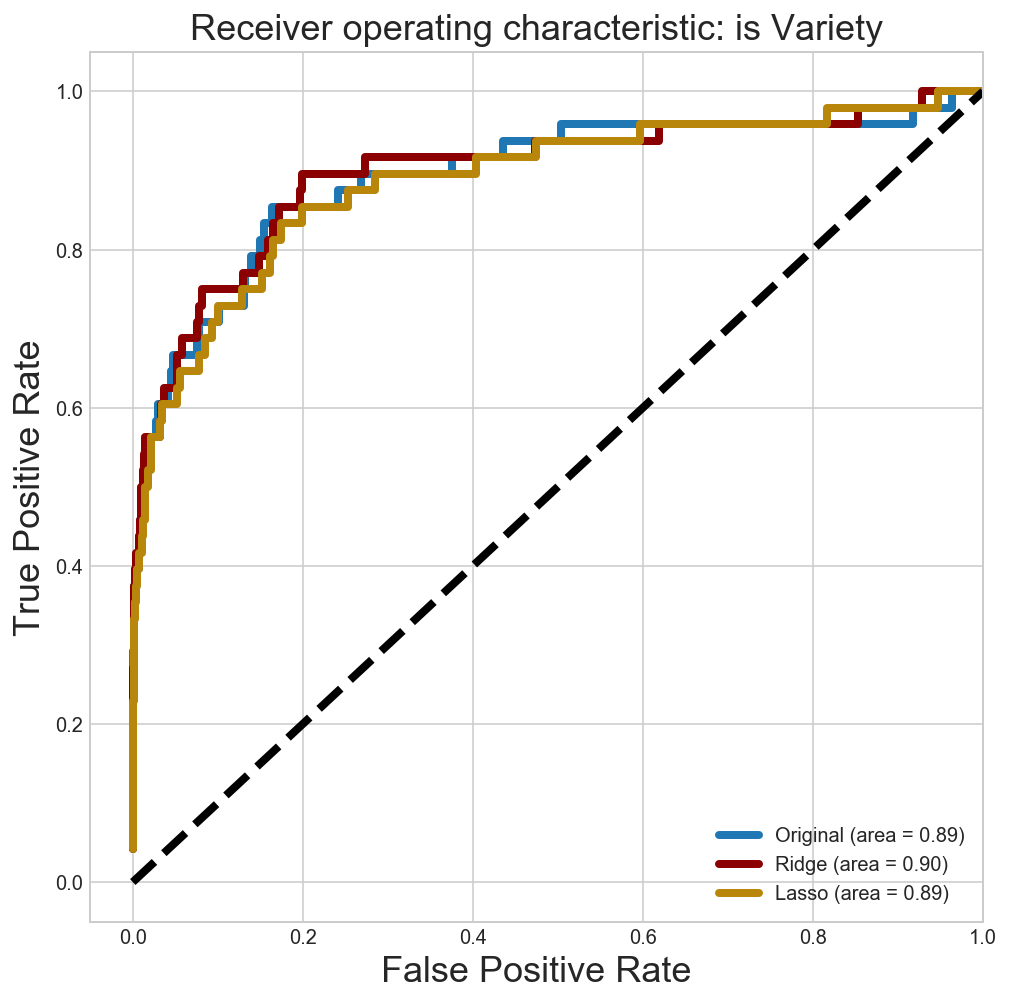

done
Variety is :  grapevar__Bordeaux-style Red Blend
setup LR
[0.96462585 0.96734694 0.94965986 0.95646259 0.96326531 0.95646259
 0.96190476 0.96190476 0.95102041 0.96326531 0.96054422 0.96866485
 0.95776567 0.96730245 0.96049046 0.96866485 0.96866485 0.96321526
 0.96457766 0.95095368 0.96185286 0.95361528 0.95907231 0.95088677
 0.94952251]
0.9600684814319986
             predicted_Yes  predicted_No
Variety                183           291
Not Variety            102          8603


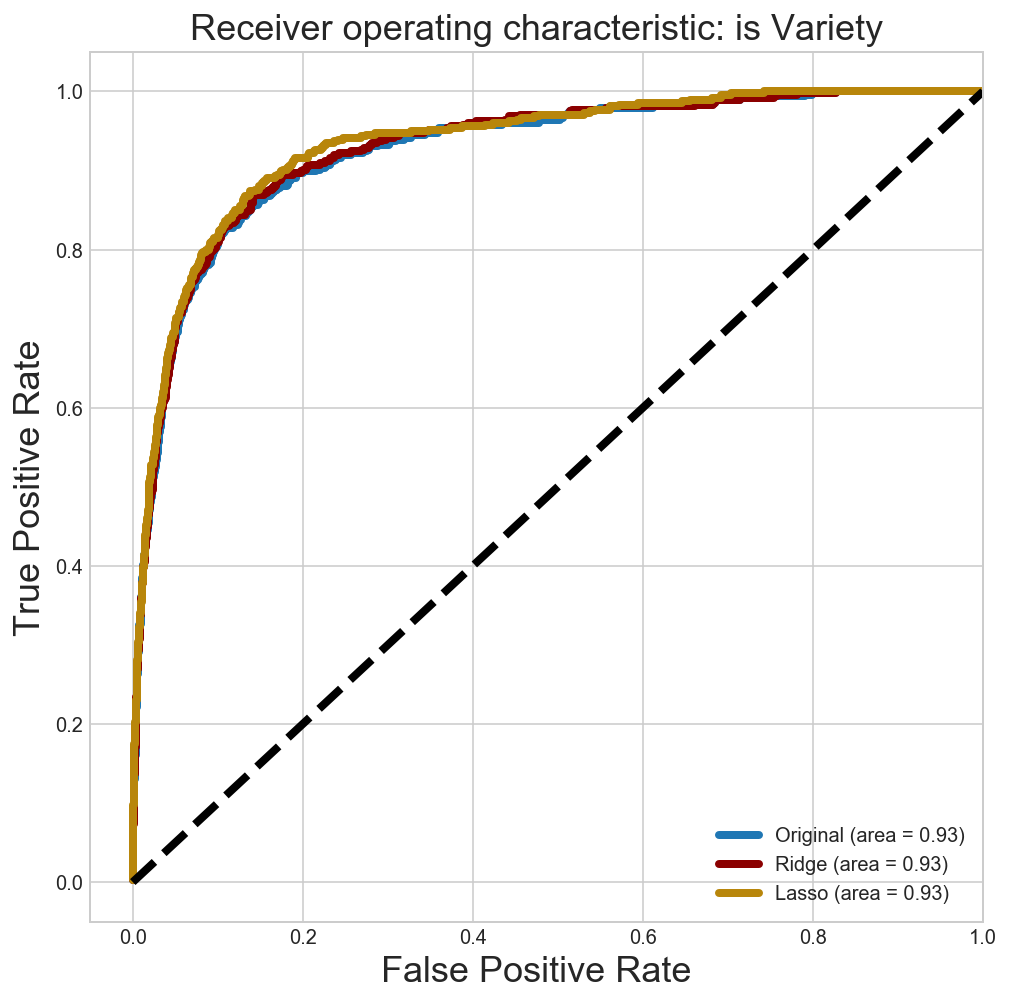

done
Variety is :  grapevar__Bordeaux-style White Blend
setup LR
[0.99183673 0.99319728 0.99183673 0.99319728 0.99183673 0.99319728
 0.99183673 0.99183673 0.99319728 0.99047619 0.99318801 0.99591281
 0.99455041 0.99318801 0.99318801 0.99182561 0.99455041 0.99318801
 0.99318801 0.99318801 0.99455041 0.99455041 0.99454297 0.99454297
 0.99454297]
0.9932458408688091
             predicted_Yes  predicted_No
Variety                  4            67
Not Variety              4          9104


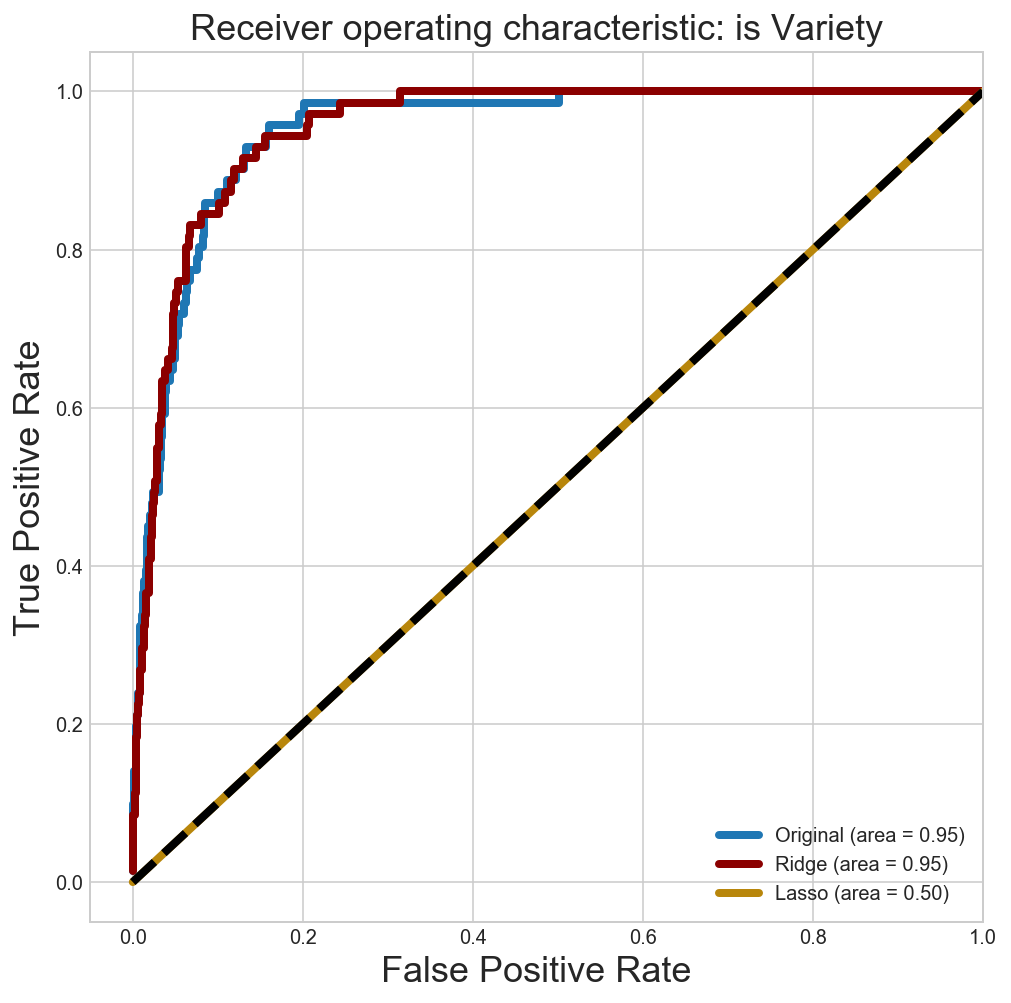

done
Variety is :  grapevar__Cabernet Franc
setup LR
[0.98505435 0.9877551  0.99319728 0.99047619 0.9877551  0.99047619
 0.98773842 0.99046322 0.98910082 0.98773842 0.98773842 0.99046322
 0.98637602 0.98910082 0.99318801 0.99182561 0.99046322 0.99046322
 0.98910082 0.99046322 0.99046322 0.99318801 0.99318801 0.99182561
 0.99182561]
0.9899771243291773
             predicted_Yes  predicted_No
Variety                 16            78
Not Variety             12          9073


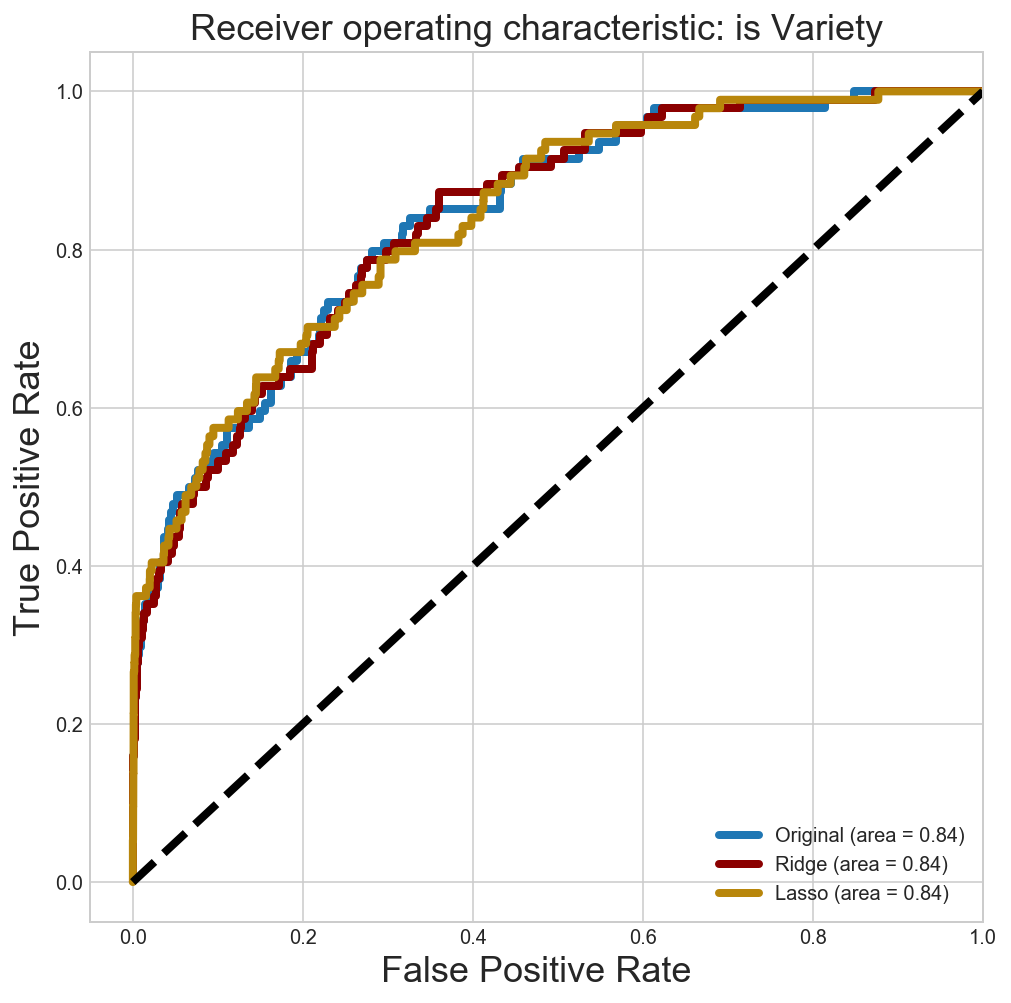

done
Variety is :  grapevar__Cabernet Sauvignon
setup LR
[0.92663043 0.92527174 0.92244898 0.9170068  0.92517007 0.93051771
 0.9346049  0.92506812 0.91416894 0.9400545  0.9346049  0.94141689
 0.95231608 0.9373297  0.94414169 0.9386921  0.9373297  0.93324251
 0.95367847 0.94822888 0.95640327 0.9346049  0.93324251 0.9373297
 0.95095368]
0.9357782871826612
             predicted_Yes  predicted_No
Variety                431           406
Not Variety            172          8170


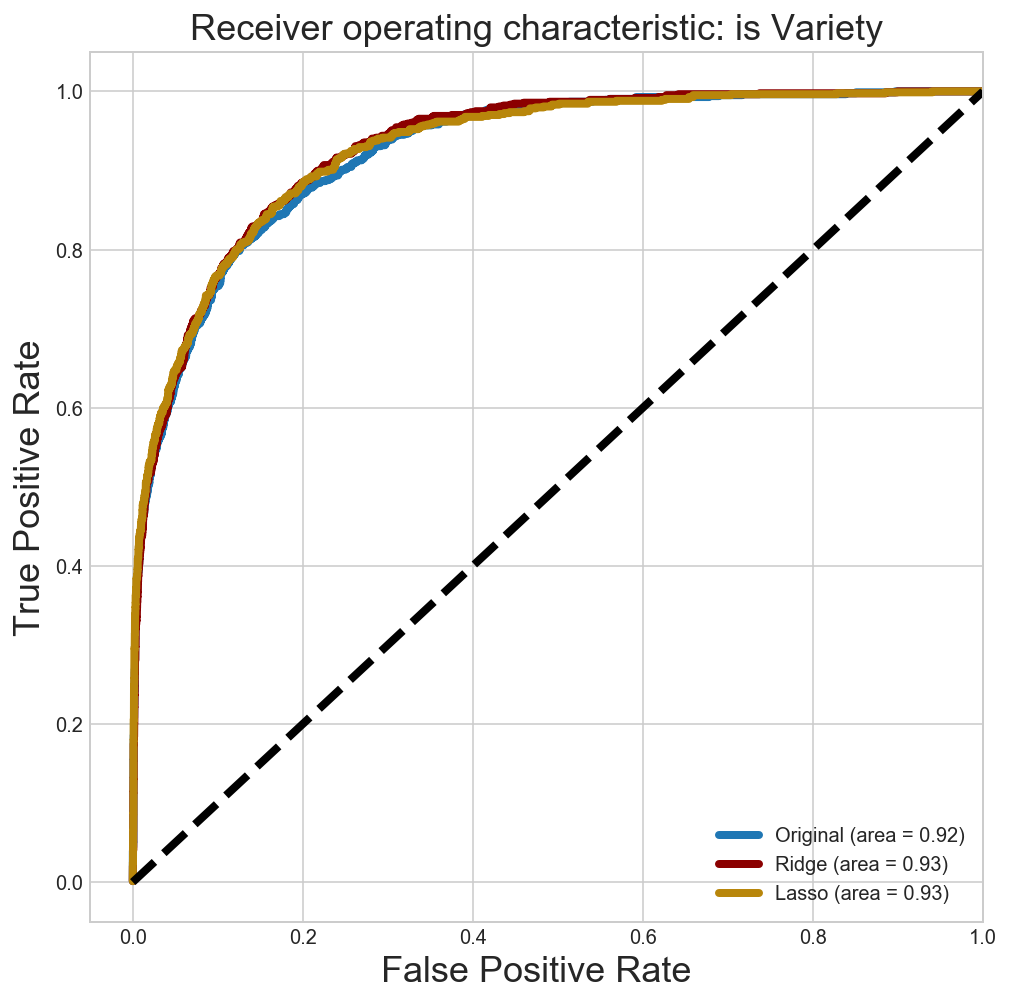

done
Variety is :  grapevar__Carmenère
setup LR
[0.99455782 0.99727891 0.99591837 0.99591837 0.99455782 0.99455782
 0.99727891 0.99183673 0.99455782 0.99455782 0.99591837 0.99591837
 0.99455782 0.99727891 0.99591837 0.99591837 0.99590723 0.99590723
 0.99454297 0.98772169 0.99181446 0.99727149 0.99317872 0.99317872
 0.99590723]
0.9948784141214466
             predicted_Yes  predicted_No
Variety                  2            36
Not Variety              3          9138


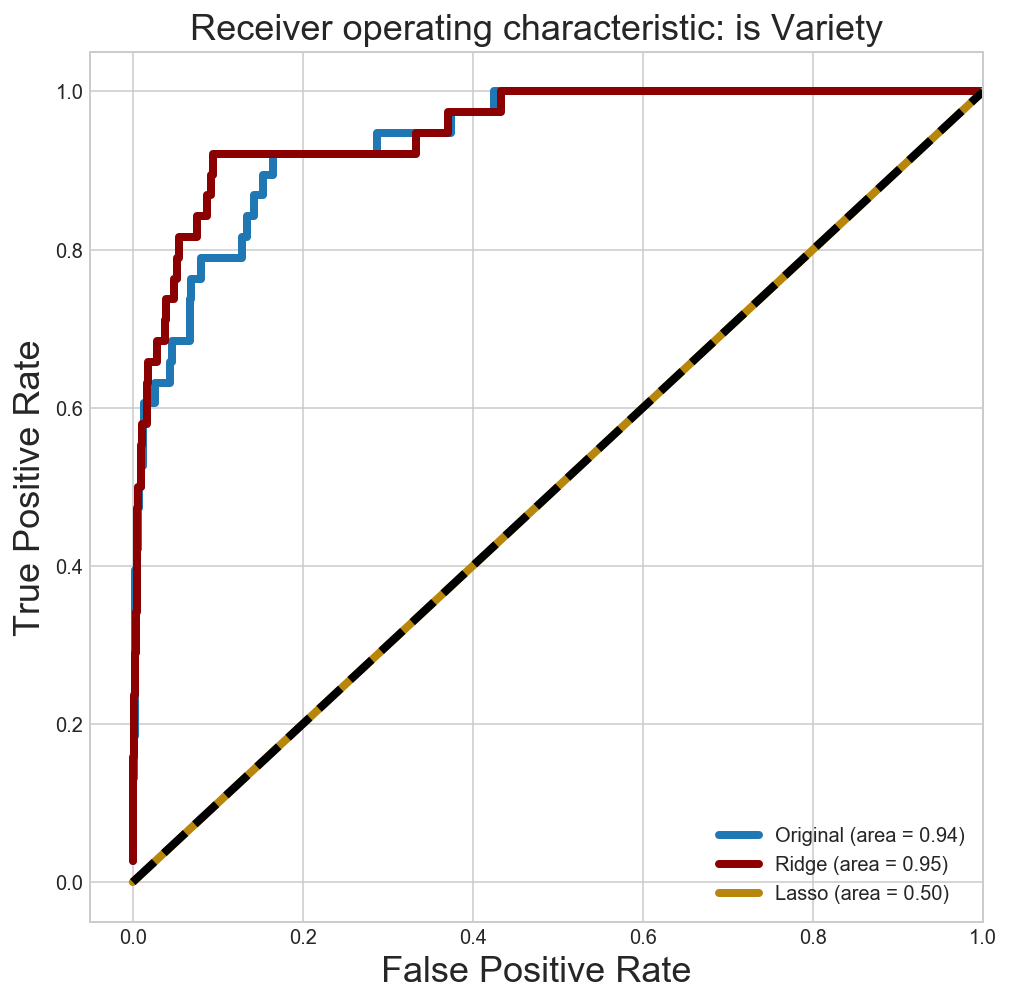

done
Variety is :  grapevar__Champagne Blend
setup LR
[0.99319728 0.99591837 0.99591837 0.99591837 0.99319728 0.99591837
 0.99455782 0.99455782 0.99455782 0.99455782 0.99319728 0.9972752
 0.99591281 0.99591281 0.99591281 0.99455041 0.99318801 0.99455041
 0.99591281 0.99591281 0.99455041 0.99590723 0.99590723 0.99454297
 0.99454297]
0.9950430192812337
             predicted_Yes  predicted_No
Variety                  2            40
Not Variety              0          9137


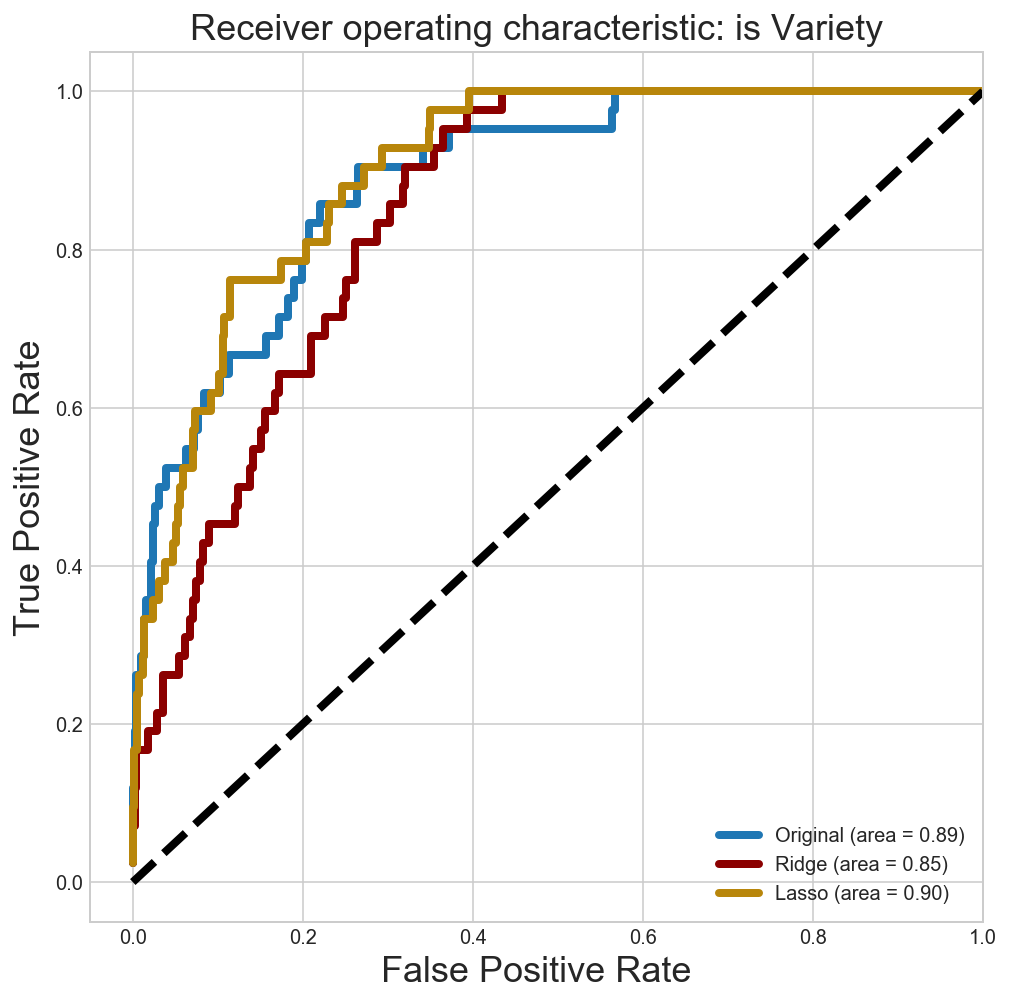

done
Variety is :  grapevar__Chardonnay
setup LR
[0.93333333 0.92108844 0.92789116 0.93197279 0.94557823 0.93605442
 0.93197279 0.9292517  0.9292517  0.94421769 0.93333333 0.93605442
 0.9537415  0.95646259 0.94550409 0.92506812 0.92779292 0.92915531
 0.95225102 0.95770805 0.95225102 0.95770805 0.9686221  0.94270123
 0.95634379]
0.9410123913451988
             predicted_Yes  predicted_No
Variety                646           367
Not Variety            200          7966


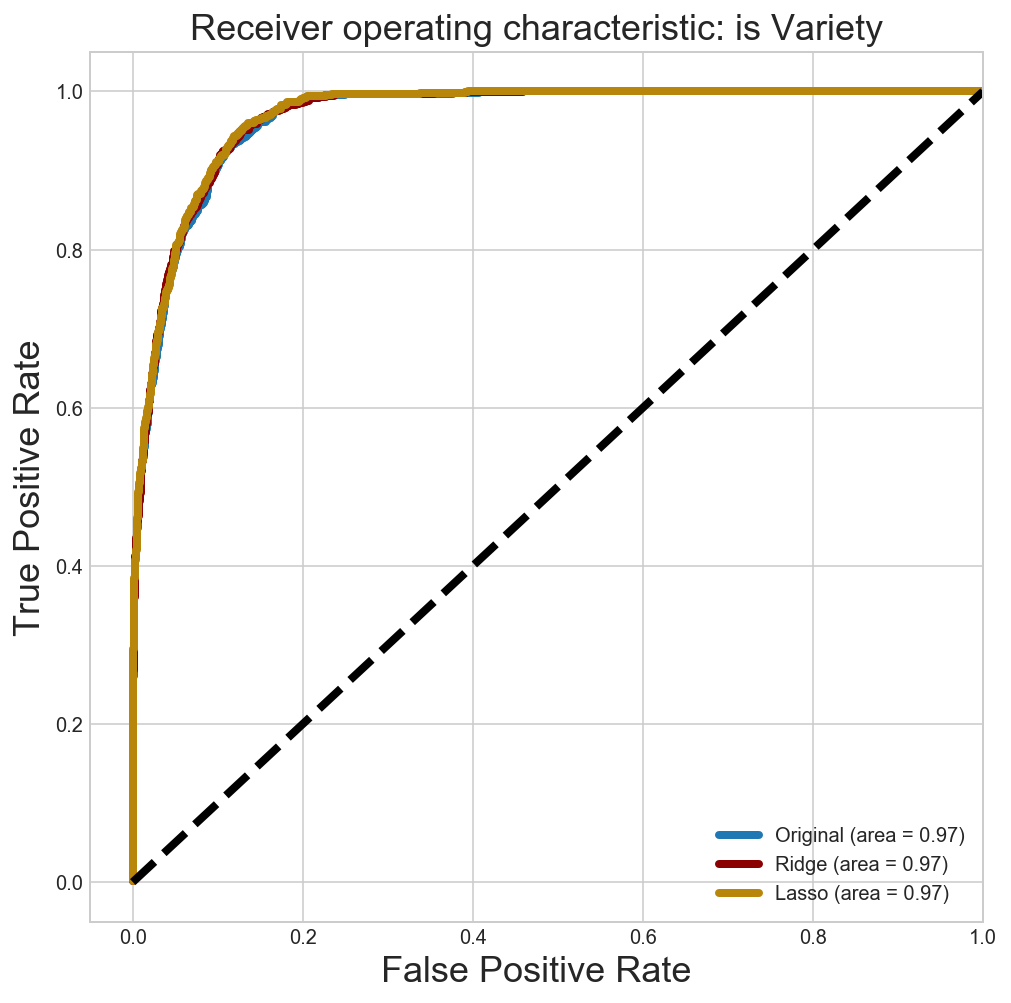

done
Variety is :  grapevar__Chenin Blanc
setup LR
[0.99183673 0.99319728 0.99319728 0.99319728 0.99455782 0.99319728
 0.99319728 0.99319728 0.99183673 0.99455782 0.99319728 0.99591281
 0.99318801 0.99455041 0.99318801 0.99591281 0.99318801 0.99455041
 0.99318801 0.99318801 0.99318801 0.99181446 0.99181446 0.99590723
 0.99181446]
0.9934630071142173
             predicted_Yes  predicted_No
Variety                  0            56
Not Variety              3          9120


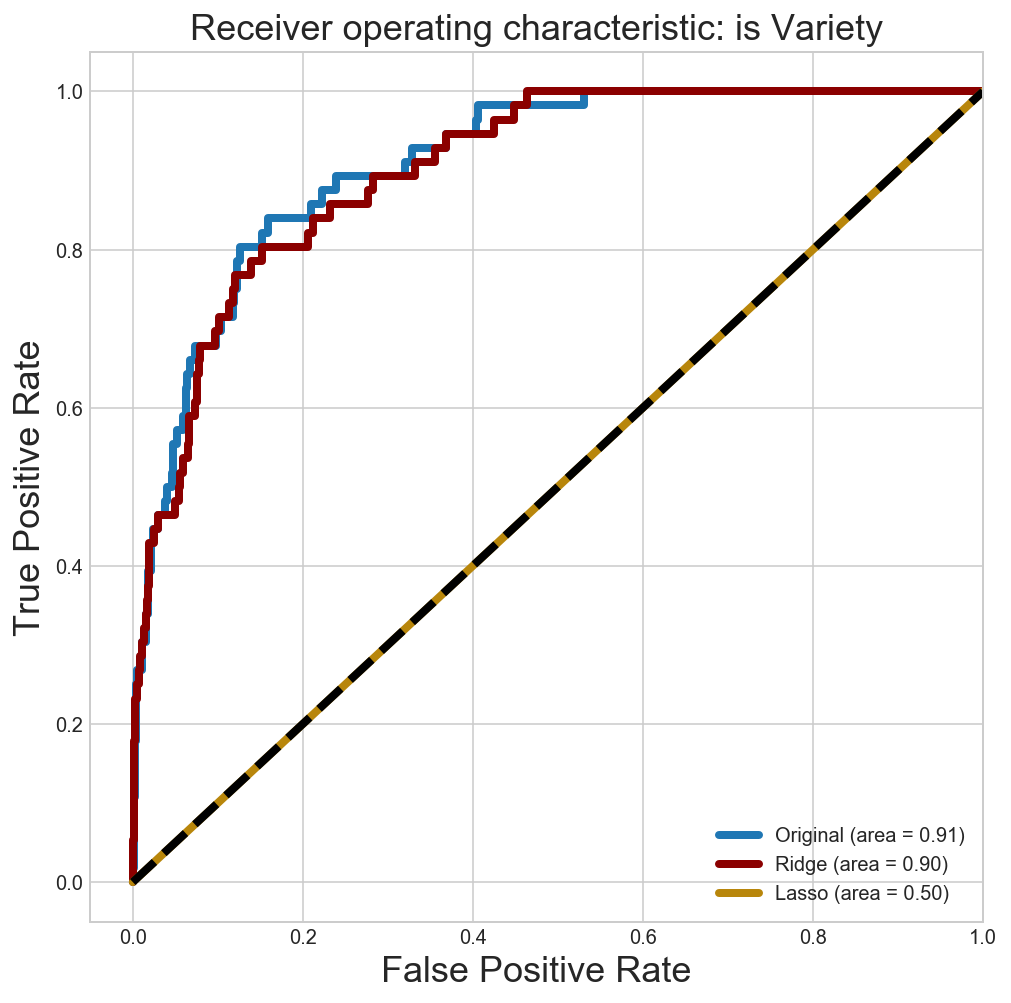

done
Variety is :  grapevar__Grenache
setup LR
[0.99048913 0.99320652 0.99319728 0.99319728 0.99183673 0.99182561
 0.99318801 0.99182561 0.99318801 0.99318801 0.99318801 0.99182561
 0.98773842 0.99455041 0.99318801 0.99318801 0.99455041 0.99318801
 0.99318801 0.99182561 0.99455041 0.99182561 0.99046322 0.99182561
 0.99318801]
0.992537023291724
             predicted_Yes  predicted_No
Variety                  1            64
Not Variety              6          9108


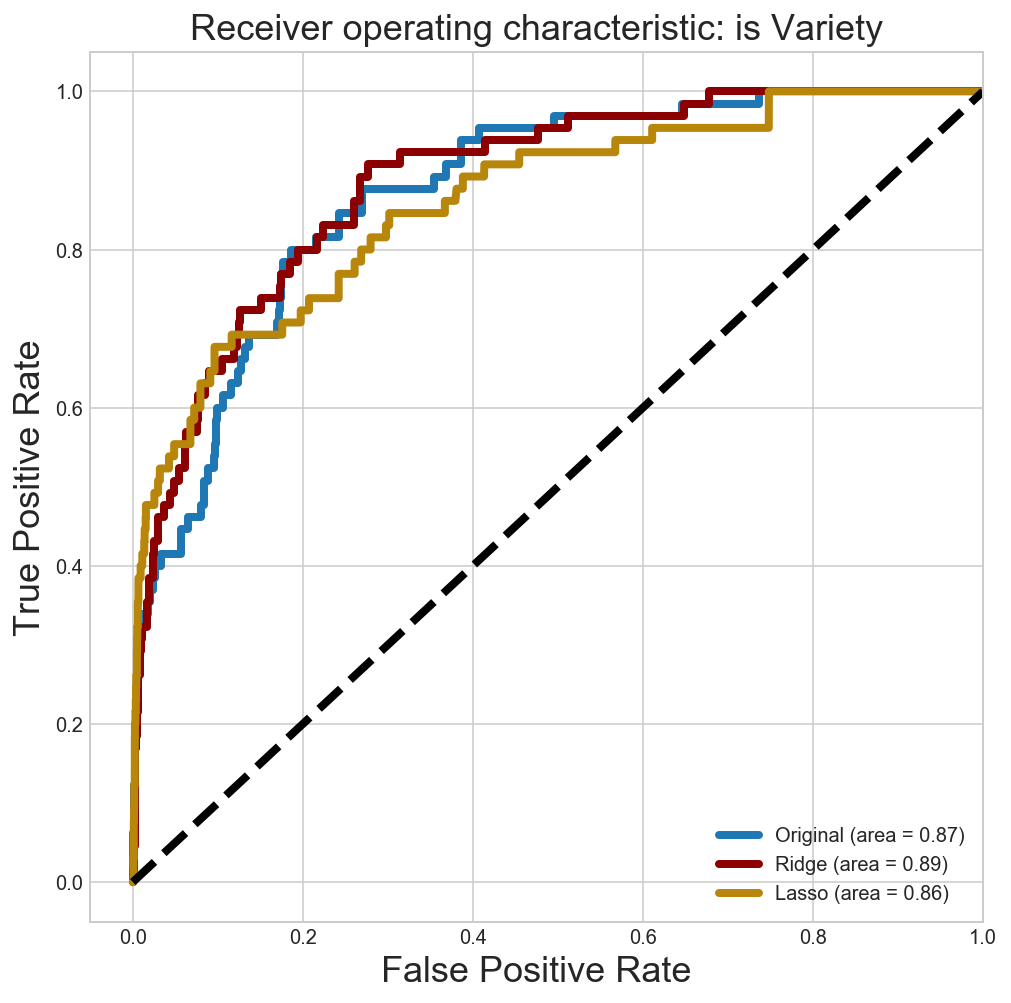

done
Variety is :  grapevar__Grüner Veltliner
setup LR
[0.99455782 0.99319728 0.99183673 0.9877551  0.99183673 0.99319728
 0.99455782 0.99047619 0.99183673 0.9877551  0.99183673 0.99319728
 0.98503401 0.99046322 0.98773842 0.99182561 0.98773842 0.98773842
 0.99182561 0.98908595 0.9904502  0.9904502  0.99181446 0.99181446
 0.9904502 ]
0.99073880058062
             predicted_Yes  predicted_No
Variety                 25            69
Not Variety              9          9076


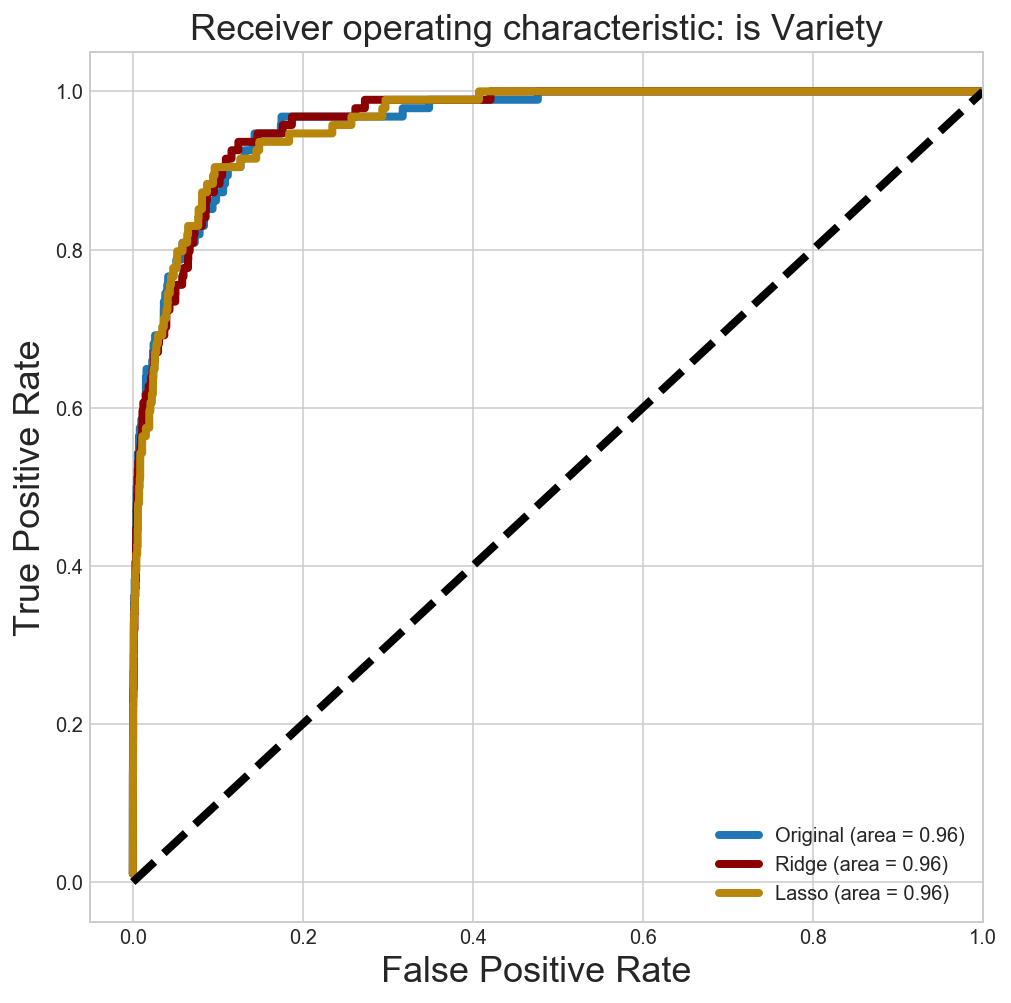

done
Variety is :  grapevar__Malbec
setup LR
[0.97278912 0.97823129 0.96734694 0.96598639 0.97823129 0.9755102
 0.9755102  0.97823129 0.97956403 0.97411444 0.97820163 0.98365123
 0.97820163 0.97820163 0.97411444 0.97820163 0.97547684 0.97275204
 0.97275204 0.96321526 0.97002725 0.97275204 0.97683924 0.97275204
 0.97407913]
0.9746693320104732
             predicted_Yes  predicted_No
Variety                 92           196
Not Variety             45          8846


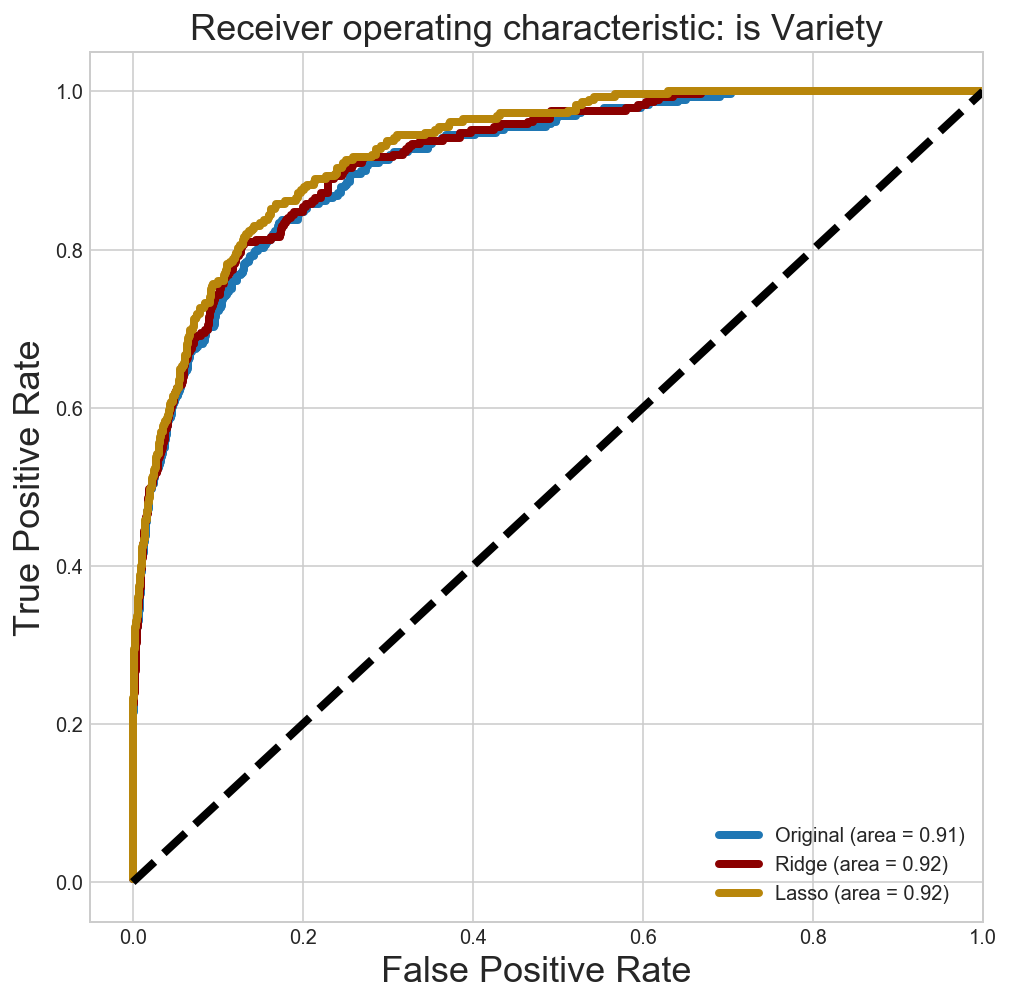

done
Variety is :  grapevar__Merlot
setup LR
[0.9673913  0.96598639 0.97006803 0.96598639 0.97142857 0.96734694
 0.97683924 0.97683924 0.98092643 0.97138965 0.97547684 0.98092643
 0.97411444 0.97683924 0.98365123 0.97956403 0.98228883 0.97683924
 0.98092643 0.97820163 0.97820163 0.98501362 0.97956403 0.98228883
 0.97820163]
0.9762520109572084
             predicted_Yes  predicted_No
Variety                104           189
Not Variety             43          8843


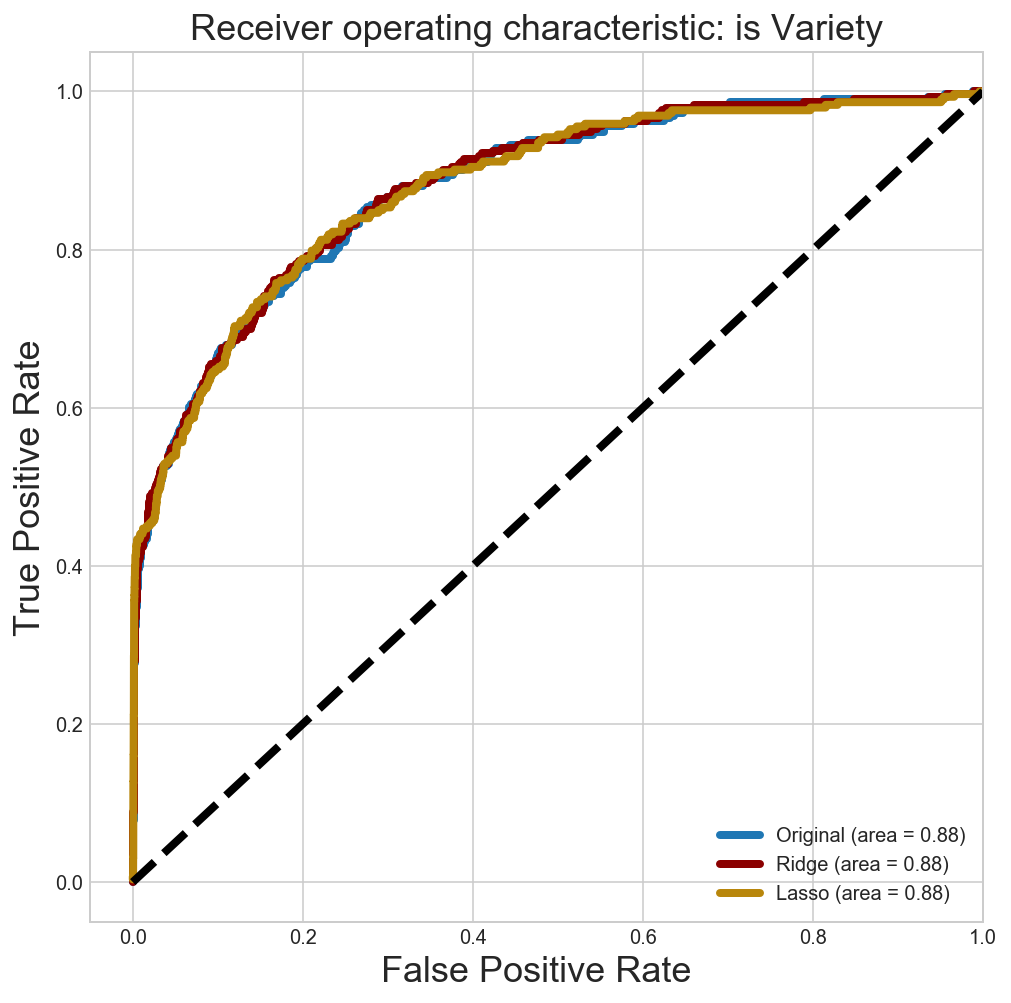

done
Variety is :  grapevar__Nebbiolo
setup LR
[0.97961957 0.98233696 0.98505435 0.98639456 0.98910082 0.98637602
 0.98637602 0.98501362 0.99318801 0.99318801 0.99046322 0.99046322
 0.98910082 0.99046322 0.99455041 0.98910082 0.99046322 0.99182561
 0.99318801 0.99455041 0.99182561 0.98910082 0.98365123 0.98365123
 0.98365123]
0.9885078792208745
             predicted_Yes  predicted_No
Variety                 76            74
Not Variety             28          9001


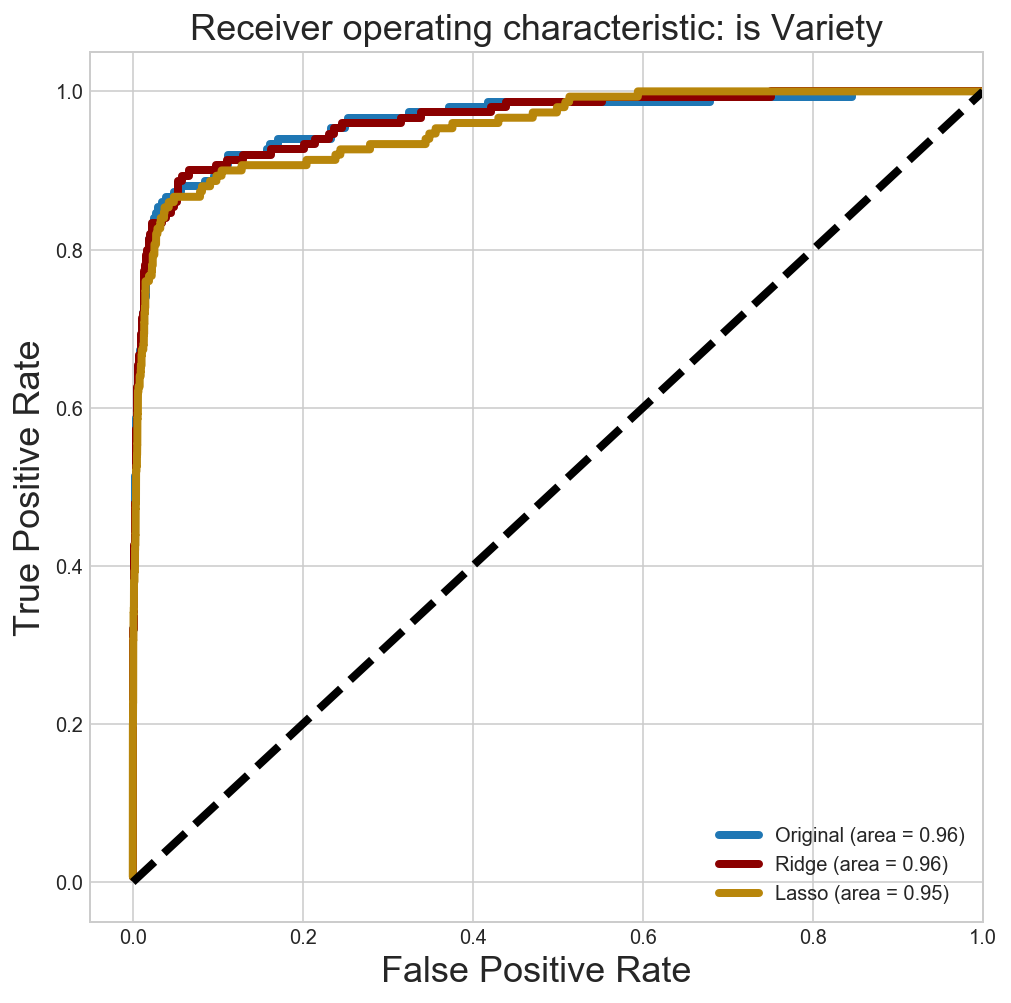

done
Variety is :  grapevar__Petite Sirah
setup LR
[0.99320652 0.99184783 0.99455782 0.99183673 0.99455782 0.99455041
 0.99591281 0.99591281 0.99318801 0.99318801 0.9986376  0.99046322
 0.99455041 0.9972752  0.99455041 0.99591281 0.99455041 0.99591281
 0.99591281 0.9972752  0.99455041 0.99591281 0.99182561 0.99318801
 0.99455041]
0.9945530756906483
             predicted_Yes  predicted_No
Variety                  6            44
Not Variety              3          9126


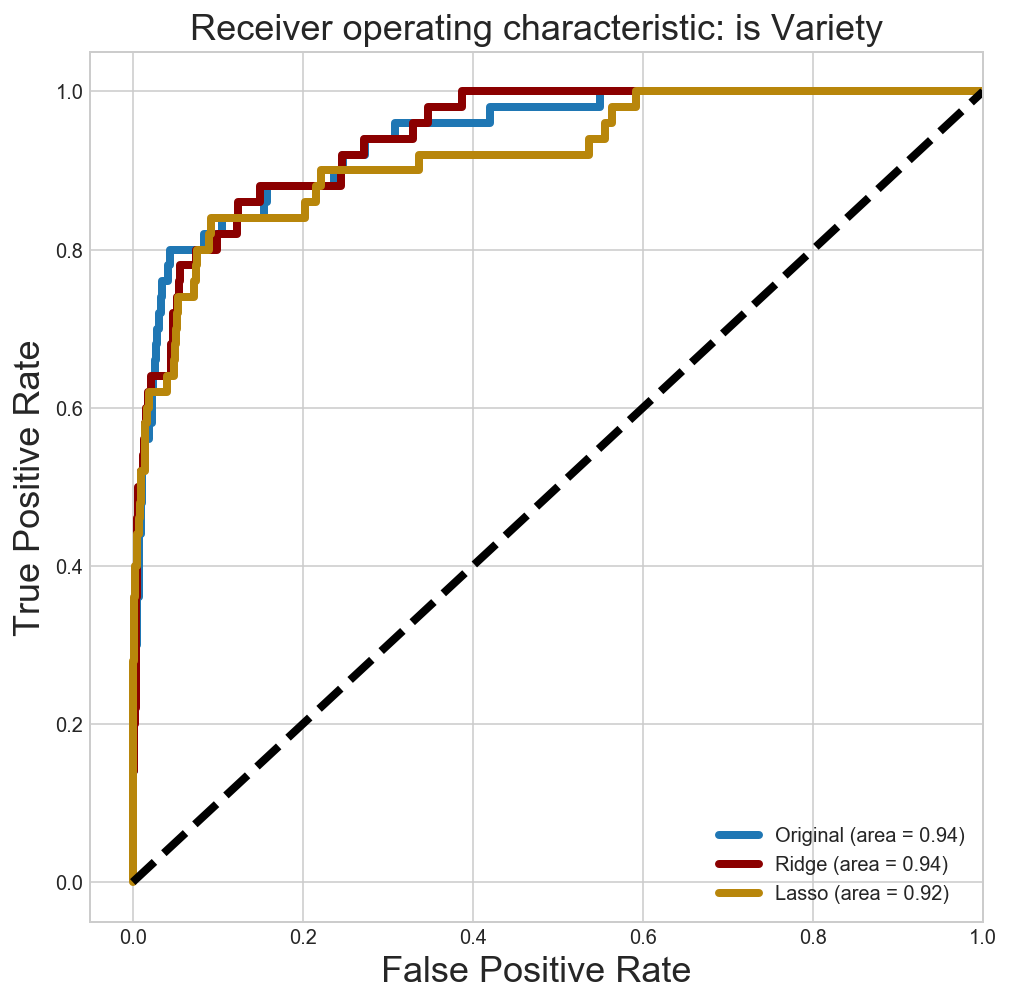

done
Variety is :  grapevar__Pinot Grigio
setup LR
[0.99183673 0.99591837 0.99319728 0.99319728 0.99455782 0.99319728
 0.99183673 0.99182561 0.99046322 0.9972752  0.99455041 0.99318801
 0.99318801 0.99318801 0.99318801 0.99182561 0.99318801 0.99046322
 0.99591281 0.99318801 0.99318801 0.99318801 0.99318801 0.99318801
 0.99182561]
0.9931905317985504
             predicted_Yes  predicted_No
Variety                  7            66
Not Variety              3          9103


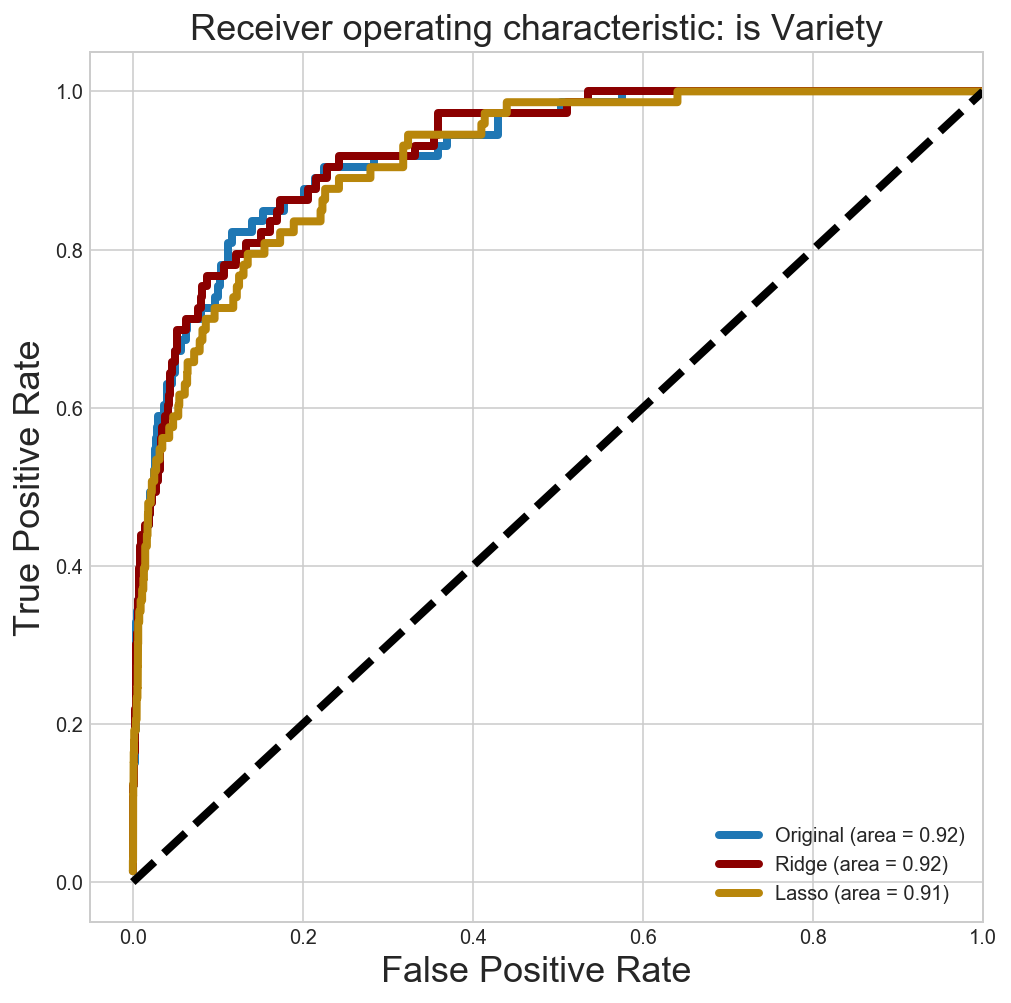

done
Variety is :  grapevar__Pinot Gris
setup LR
[0.9877551  0.99047619 0.98639456 0.99183673 0.98911565 0.98231293
 0.98095238 0.98231293 0.98773842 0.98637602 0.98365123 0.98365123
 0.98501362 0.98637602 0.98637602 0.98501362 0.97683924 0.99046322
 0.98365123 0.98501362 0.98501362 0.98501362 0.98092643 0.98773842
 0.98908595]
0.9855639198629741
             predicted_Yes  predicted_No
Variety                 16           131
Not Variety             15          9017


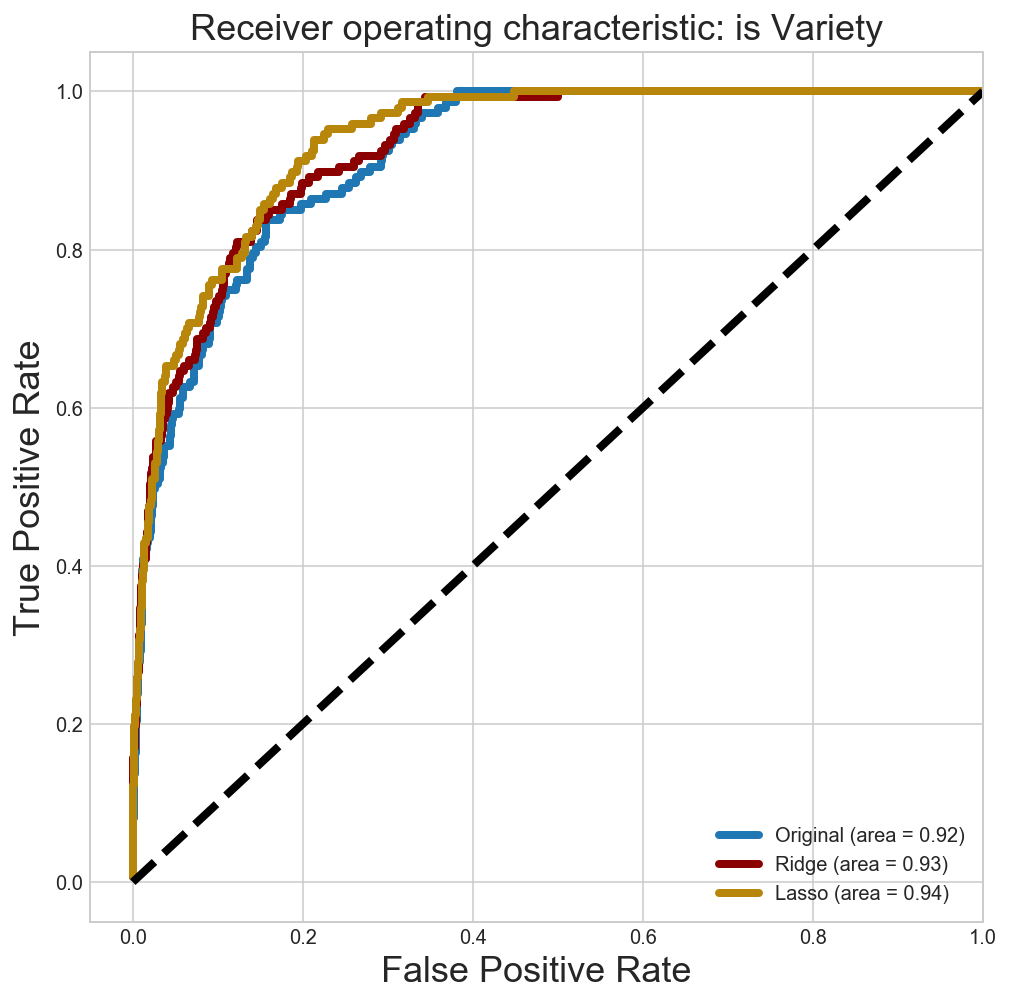

done
Variety is :  grapevar__Pinot Noir
setup LR
[0.90340136 0.90612245 0.92517007 0.92653061 0.91156463 0.93061224
 0.90612245 0.90340136 0.90068027 0.90068027 0.90599455 0.92098093
 0.91961853 0.92643052 0.92915531 0.91689373 0.9346049  0.92370572
 0.9359673  0.92370572 0.92779292 0.91144414 0.9372442  0.92905866
 0.94542974]
0.92009250391779
             predicted_Yes  predicted_No
Variety                821           540
Not Variety            217          7601


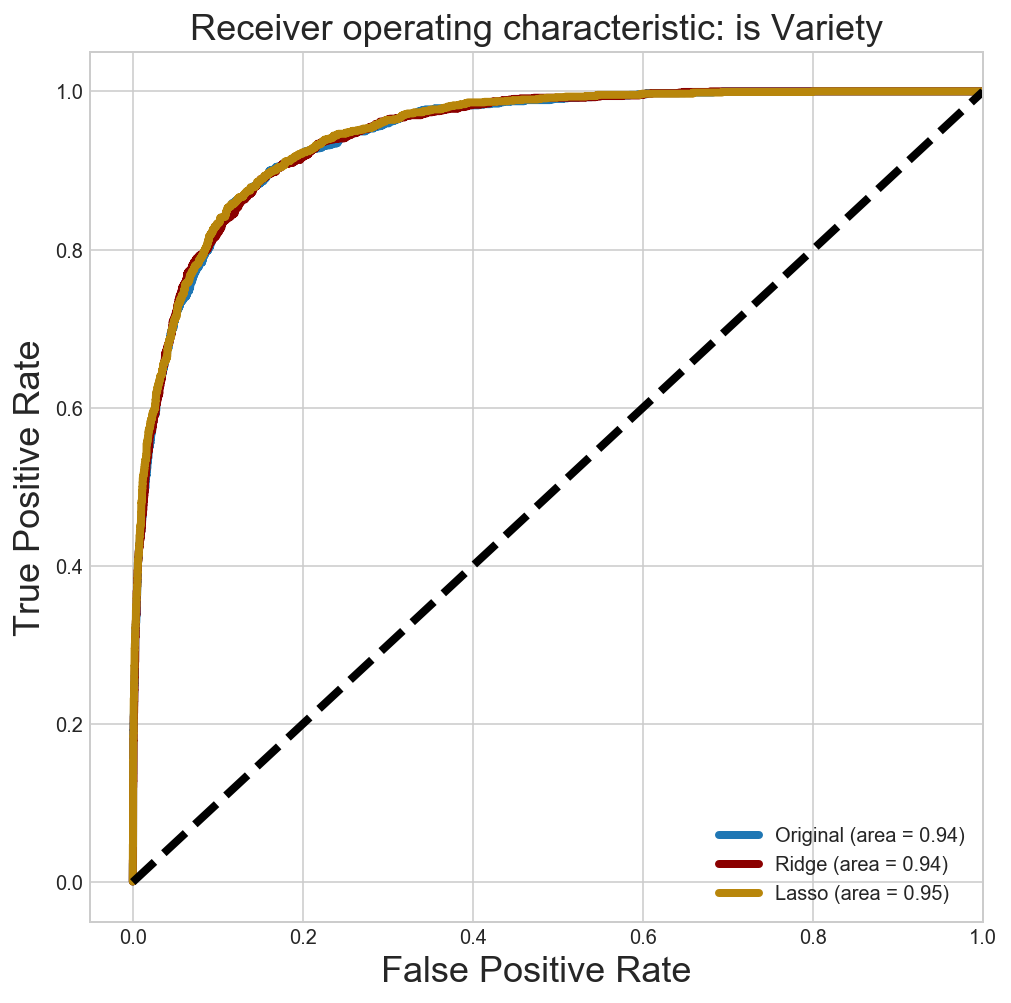

done
Variety is :  grapevar__Portuguese Red
setup LR
[0.98233696 0.97690217 0.97282609 0.97006803 0.98773842 0.97683924
 0.98092643 0.98092643 0.97547684 0.98092643 0.98092643 0.98501362
 0.98365123 0.98228883 0.98501362 0.98637602 0.98092643 0.98637602
 0.98092643 0.97820163 0.97956403 0.98092643 0.97547684 0.98228883
 0.97683924]
0.9803905068958042
             predicted_Yes  predicted_No
Variety                 61           127
Not Variety             49          8942


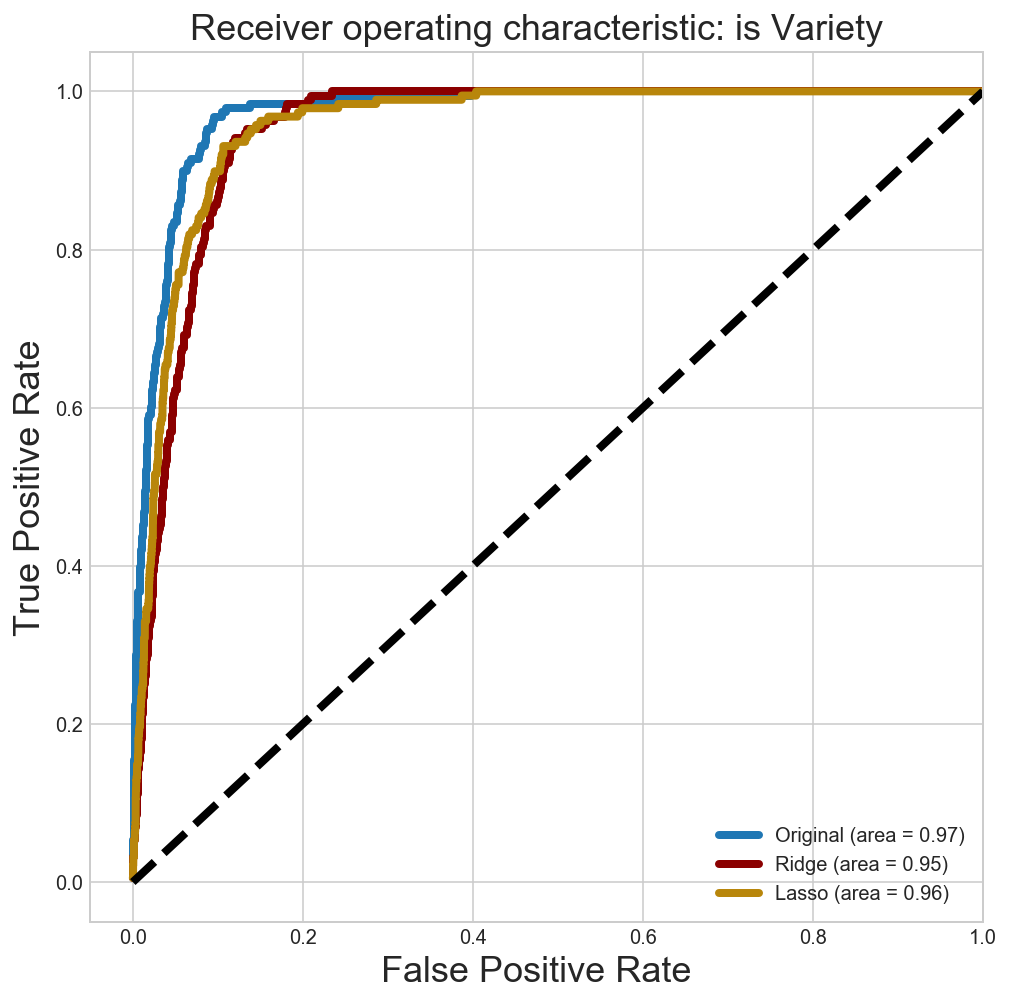

done
Variety is :  grapevar__Portuguese White
setup LR
[0.99047619 0.99183673 0.99047619 0.99183673 0.98911565 0.99319728
 0.99319728 0.99047619 0.99047619 0.98639456 0.99047619 0.99183673
 0.99182561 0.98910082 0.99318801 0.99182561 0.99182561 0.99182561
 0.99318801 0.99318801 0.99317872 0.99181446 0.99317872 0.99317872
 0.99317872]
0.9916117020933595
             predicted_Yes  predicted_No
Variety                  6            59
Not Variety              9          9105


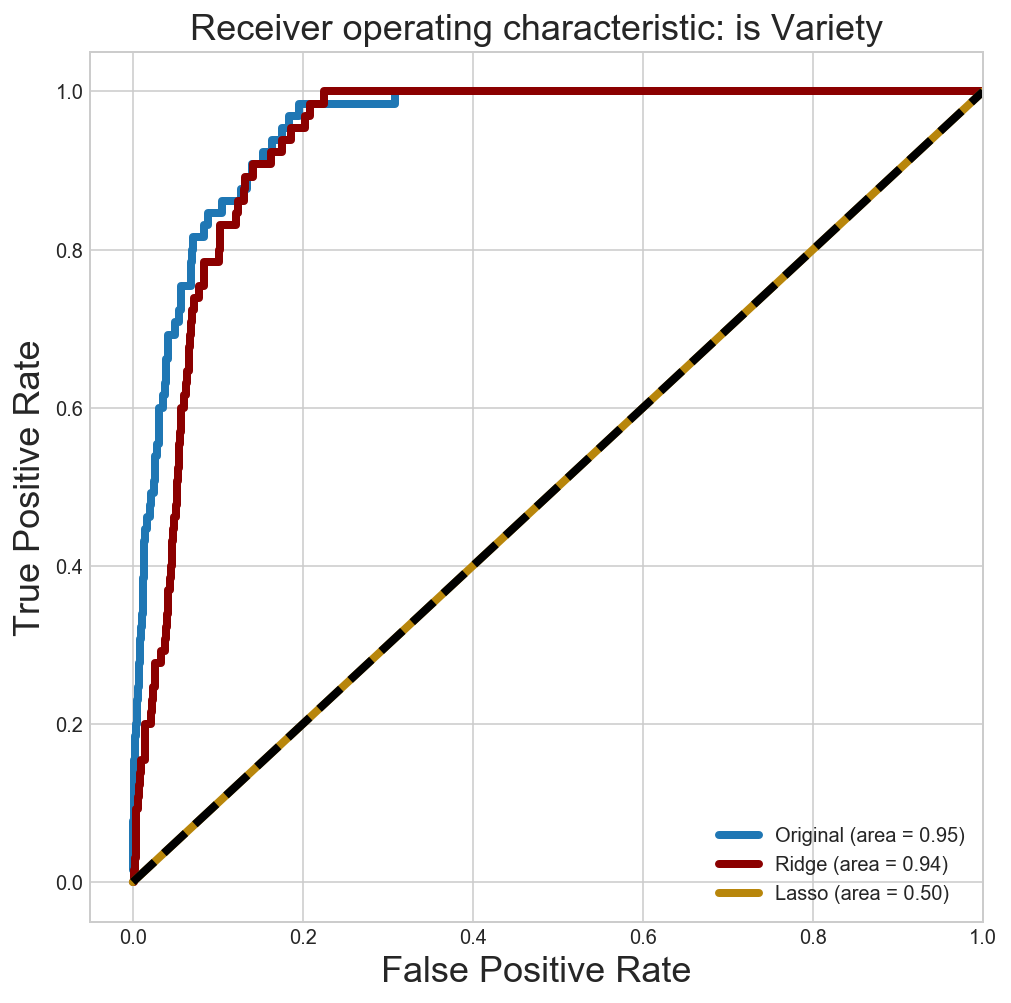

done
Variety is :  grapevar__Red Blend
setup LR
[0.9414966  0.93605442 0.92789116 0.94013605 0.93061224 0.94693878
 0.92789116 0.93197279 0.94414169 0.92915531 0.92098093 0.92098093
 0.92779292 0.92643052 0.9373297  0.93188011 0.9346049  0.93188011
 0.93324251 0.91280654 0.93188011 0.92643052 0.94959128 0.95504087
 0.94133697]
0.9335399642383692
             predicted_Yes  predicted_No
Variety                331           474
Not Variety            137          8237


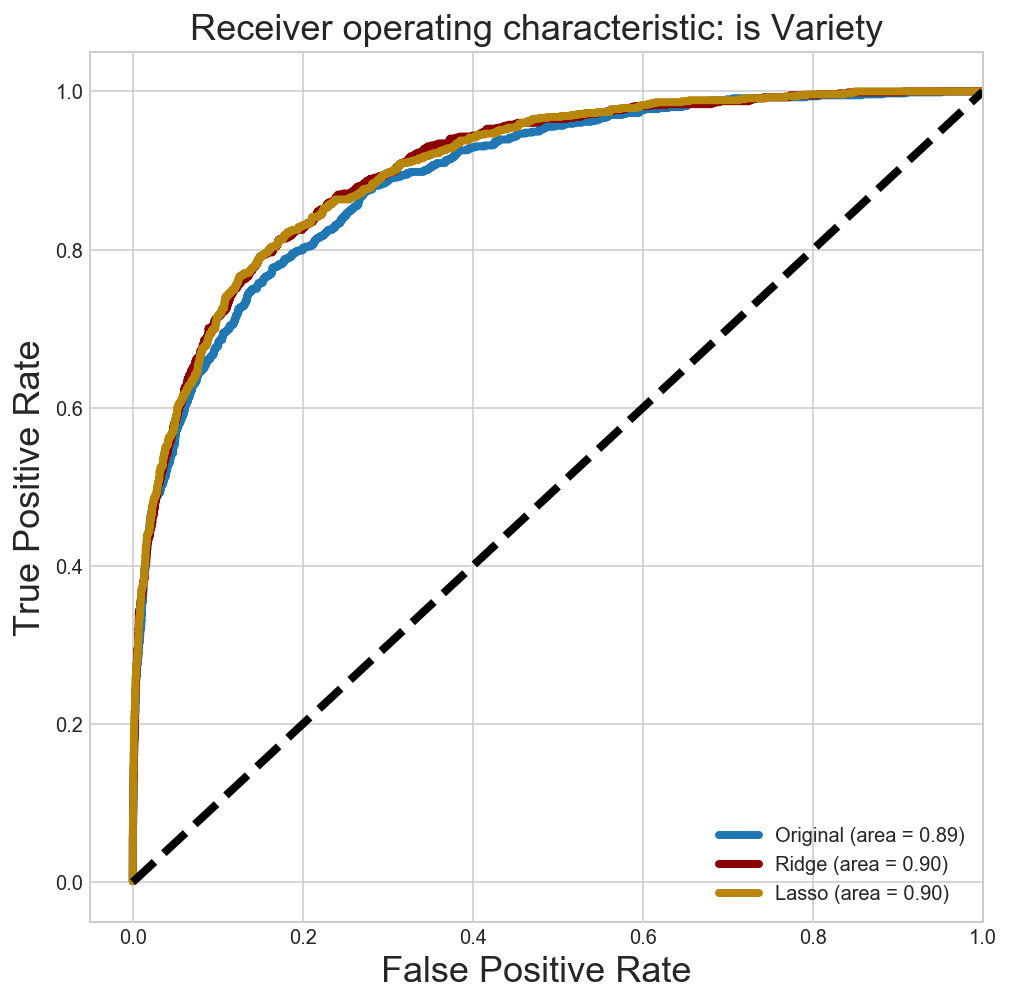

done
Variety is :  grapevar__Rhône-style Red Blend
setup LR
[0.98369565 0.99048913 0.99048913 0.9877551  0.99046322 0.98773842
 0.98637602 0.98501362 0.98637602 0.98773842 0.99046322 0.98365123
 0.98365123 0.98910082 0.98365123 0.98501362 0.98501362 0.98637602
 0.99046322 0.98773842 0.98773842 0.98228883 0.98228883 0.98365123
 0.98773842]
0.9865985230011921
             predicted_Yes  predicted_No
Variety                 37            87
Not Variety             25          9030


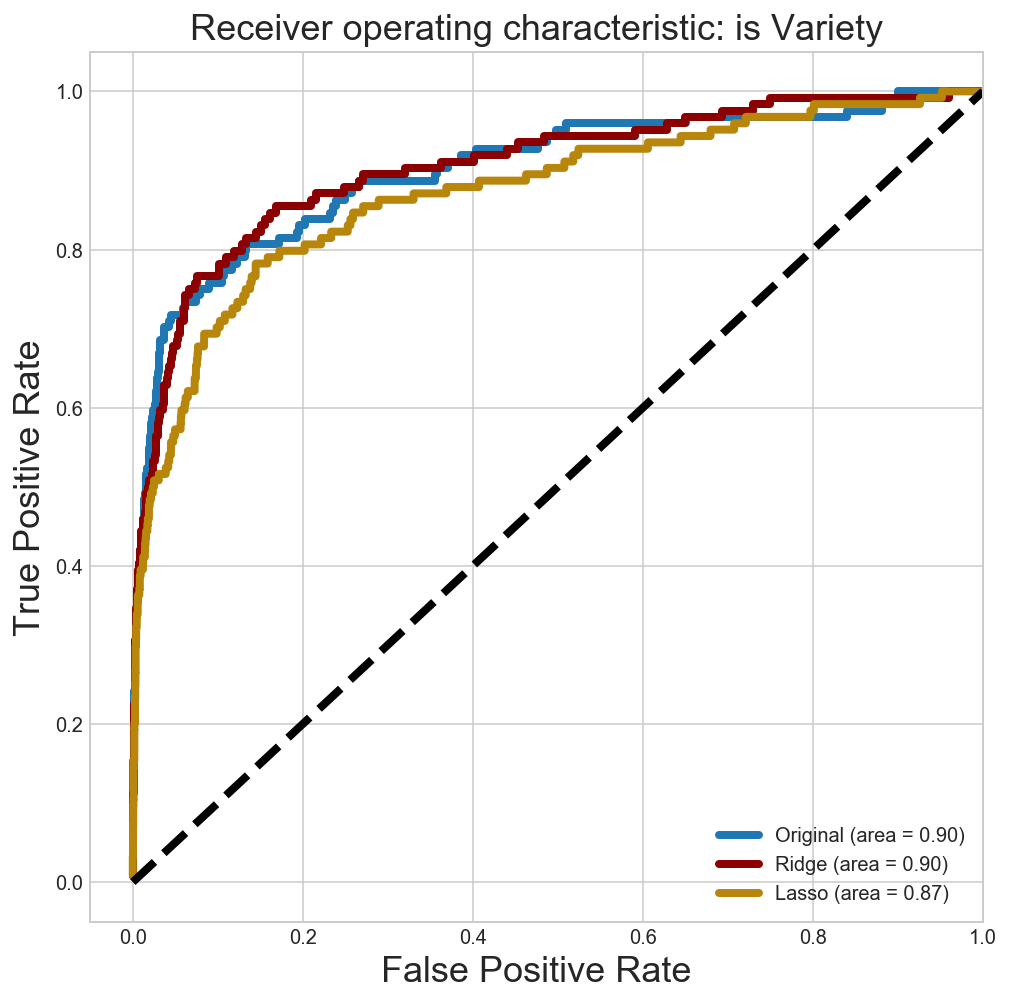

done
Variety is :  grapevar__Riesling
setup LR
[0.97554348 0.97278912 0.98367347 0.98095238 0.98911565 0.98503401
 0.98773842 0.98637602 0.97683924 0.98092643 0.97411444 0.97138965
 0.97956403 0.96457766 0.97411444 0.96730245 0.96321526 0.96457766
 0.96730245 0.96866485 0.96730245 0.97820163 0.98092643 0.97956403
 0.98773842]
0.9763017628565465
             predicted_Yes  predicted_No
Variety                351           190
Not Variety             38          8600


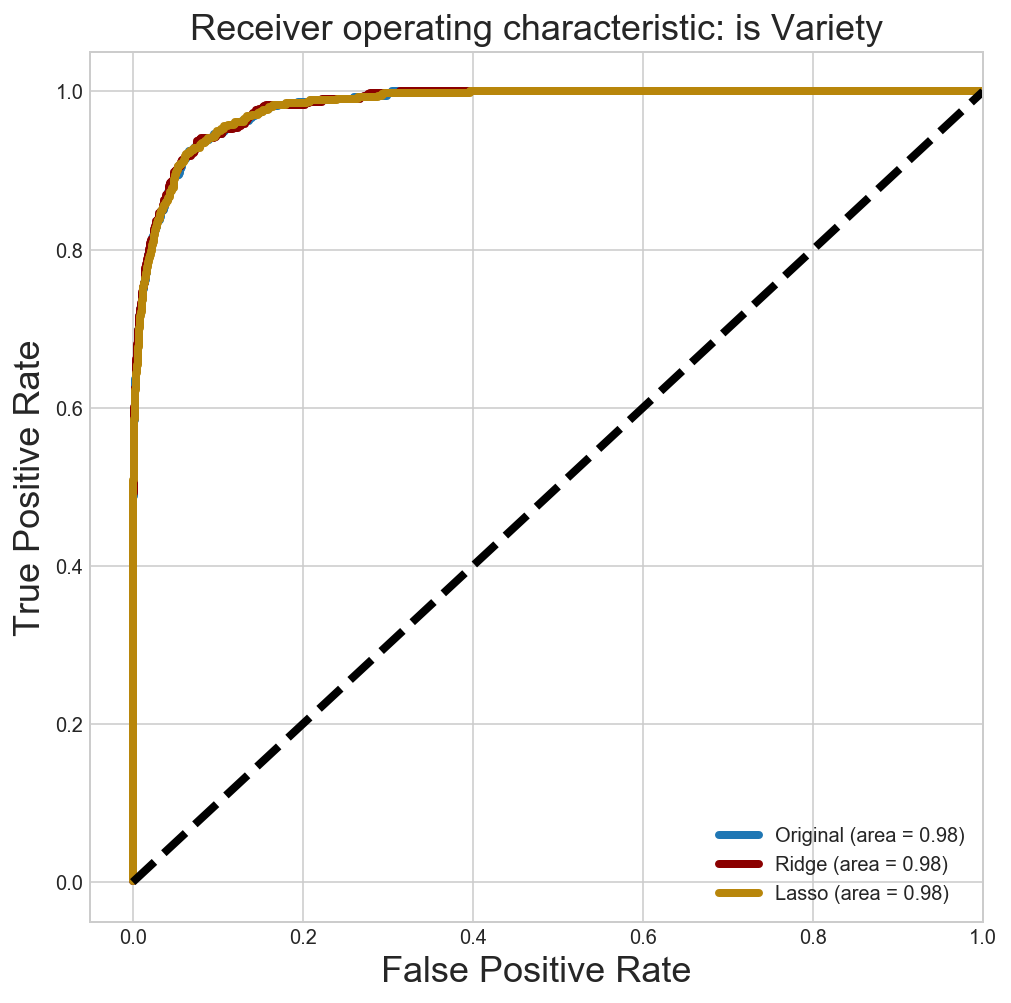

done
Variety is :  grapevar__Rosé
setup LR
[0.9755102  0.98095238 0.98367347 0.97959184 0.97823129 0.97959184
 0.97959184 0.98231293 0.99047619 0.98095238 0.98367347 0.98367347
 0.97414966 0.9755102  0.98095238 0.97823129 0.97680764 0.98635744
 0.98090041 0.9781719  0.97544338 0.96998636 0.98090041 0.98499318
 0.98499318]
0.9802251487225176
             predicted_Yes  predicted_No
Variety                194           133
Not Variety             34          8818


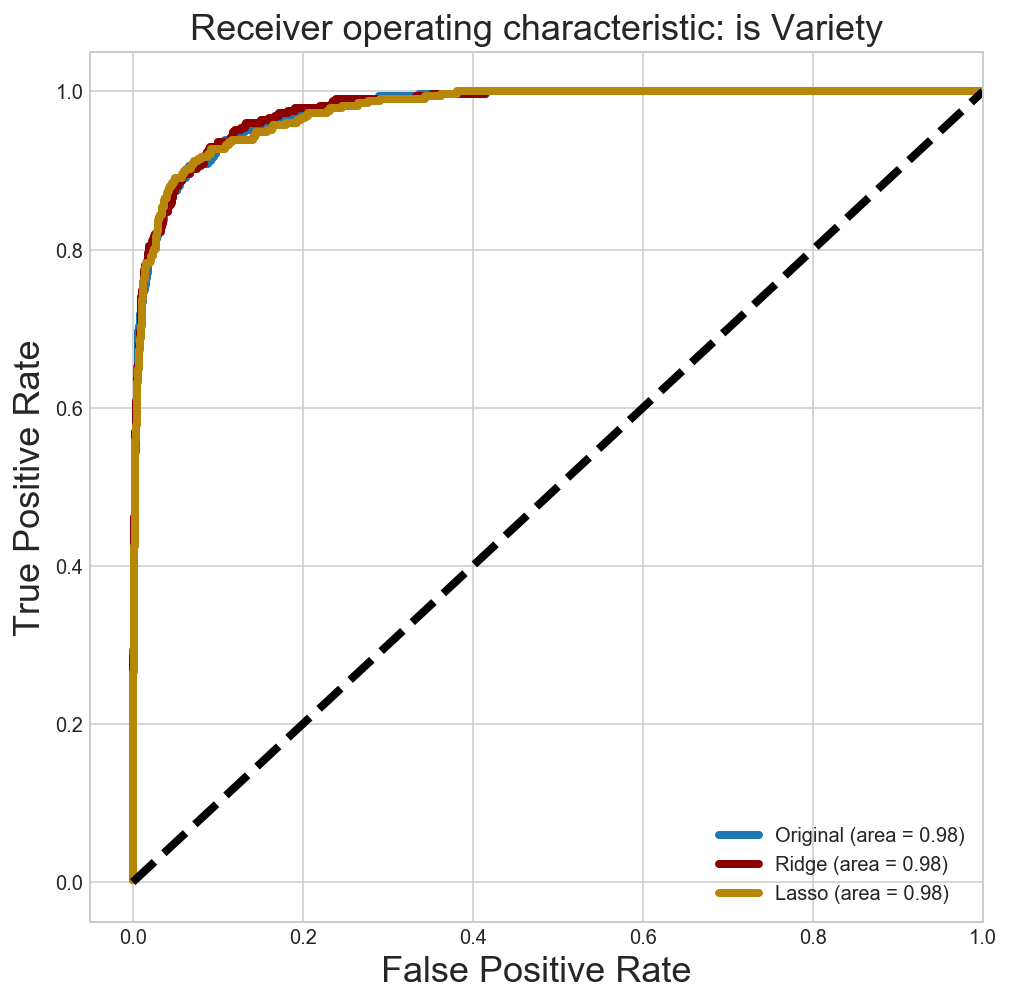

done
Variety is :  grapevar__Sangiovese
setup LR
[0.96326531 0.97414966 0.97142857 0.97687075 0.9755102  0.97687075
 0.97414966 0.9755102  0.98095238 0.98503401 0.96870748 0.98095238
 0.97411444 0.97275204 0.97956403 0.98365123 0.98092643 0.98365123
 0.97820163 0.97683924 0.97135061 0.95770805 0.96998636 0.98226467
 0.97407913]
0.9755396178448258
             predicted_Yes  predicted_No
Variety                 76           185
Not Variety             55          8863


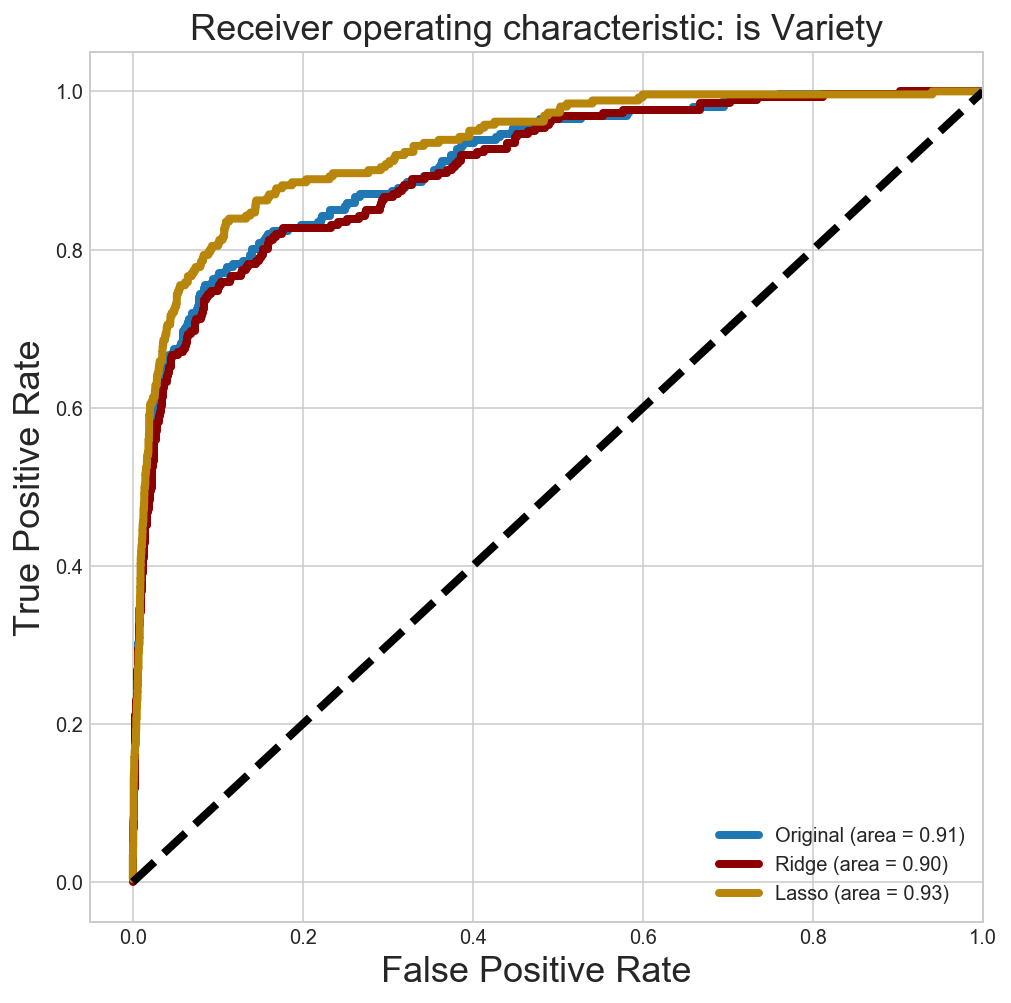

done
Variety is :  grapevar__Sangiovese Grosso
setup LR
[0.99183673 0.99727891 0.99727891 0.99863946 0.99727891 0.99319728
 0.99591837 0.99591837 0.99727891 0.99047619 0.98911565 0.99455782
 0.99183673 0.99455782 0.99455782 0.99455782 0.99317872 0.99181446
 0.98908595 0.99317872 0.99181446 0.98499318 0.9781719  0.97953615
 0.98226467]
0.9919329565386866
             predicted_Yes  predicted_No
Variety                 88            55
Not Variety             24          9012


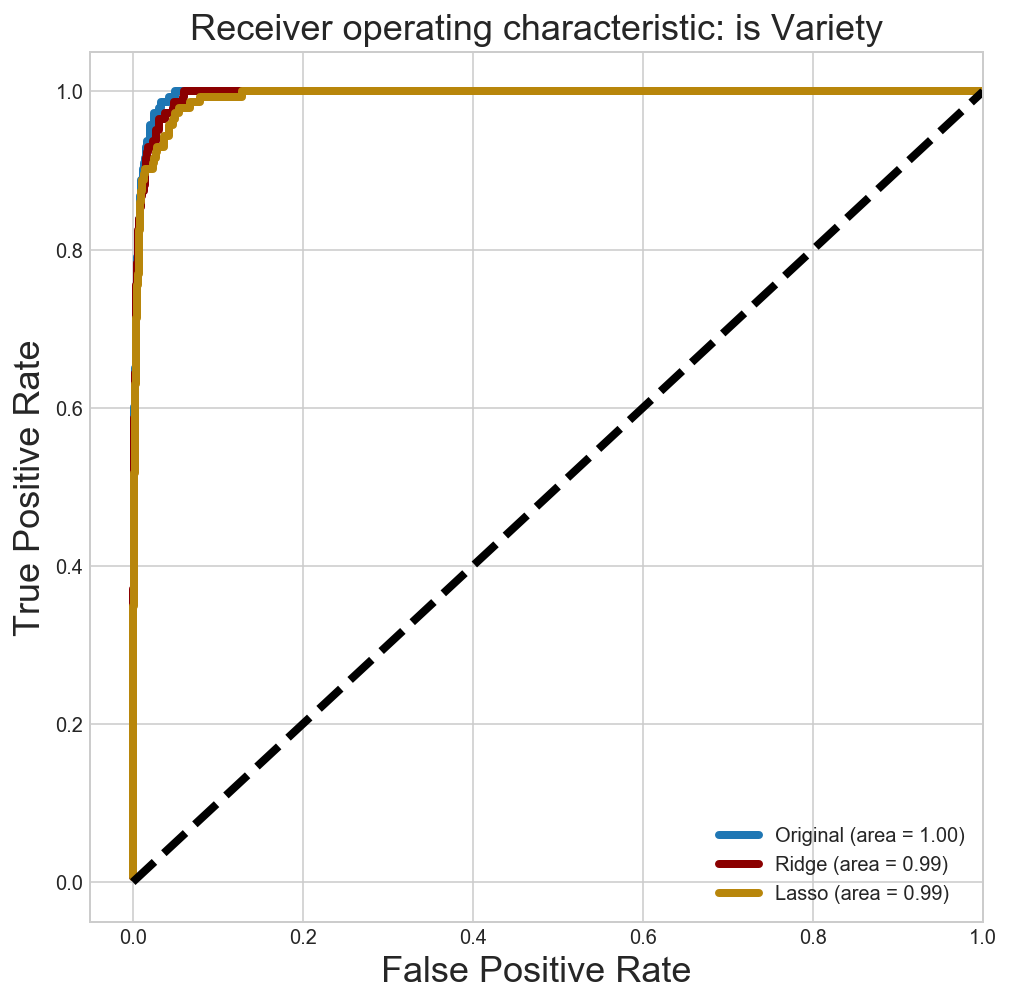

done
Variety is :  grapevar__Sauvignon Blanc
setup LR
[0.94701087 0.96195652 0.97142857 0.95782313 0.95782313 0.94822888
 0.96321526 0.95912807 0.95367847 0.94141689 0.96185286 0.97138965
 0.97275204 0.97956403 0.96457766 0.96049046 0.95504087 0.96457766
 0.97002725 0.96866485 0.97411444 0.97138965 0.97547684 0.96185286
 0.97411444]
0.9635038141900523
             predicted_Yes  predicted_No
Variety                179           257
Not Variety             90          8653


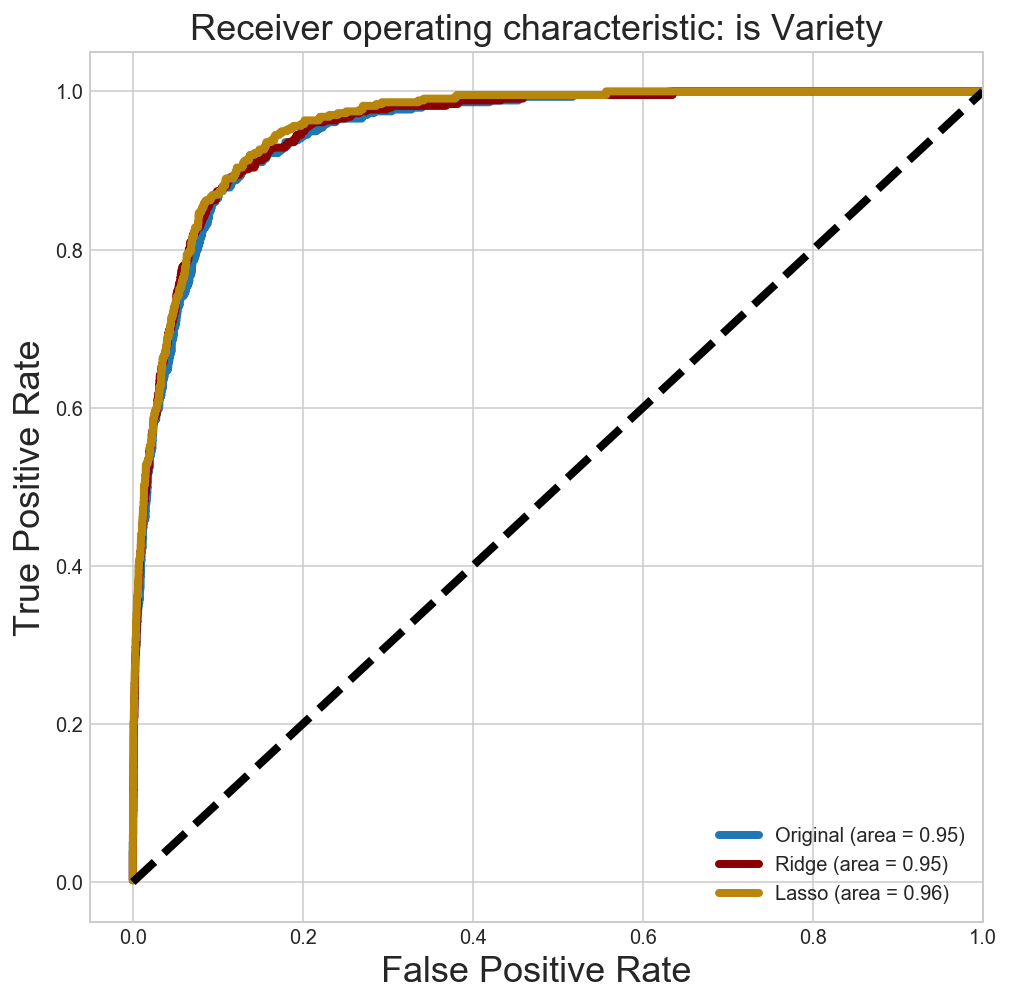

done
Variety is :  grapevar__Shiraz
setup LR
[0.98913043 0.98913043 0.99048913 0.99183673 0.99182561 0.99318801
 0.99455041 0.99318801 0.99455041 0.98637602 0.98773842 0.98773842
 0.99318801 0.98773842 0.98910082 0.98910082 0.98910082 0.99182561
 0.99046322 0.99182561 0.99046322 0.99455041 0.99046322 0.99182561
 0.98910082]
0.990739545682033
             predicted_Yes  predicted_No
Variety                 17            68
Not Variety             14          9080


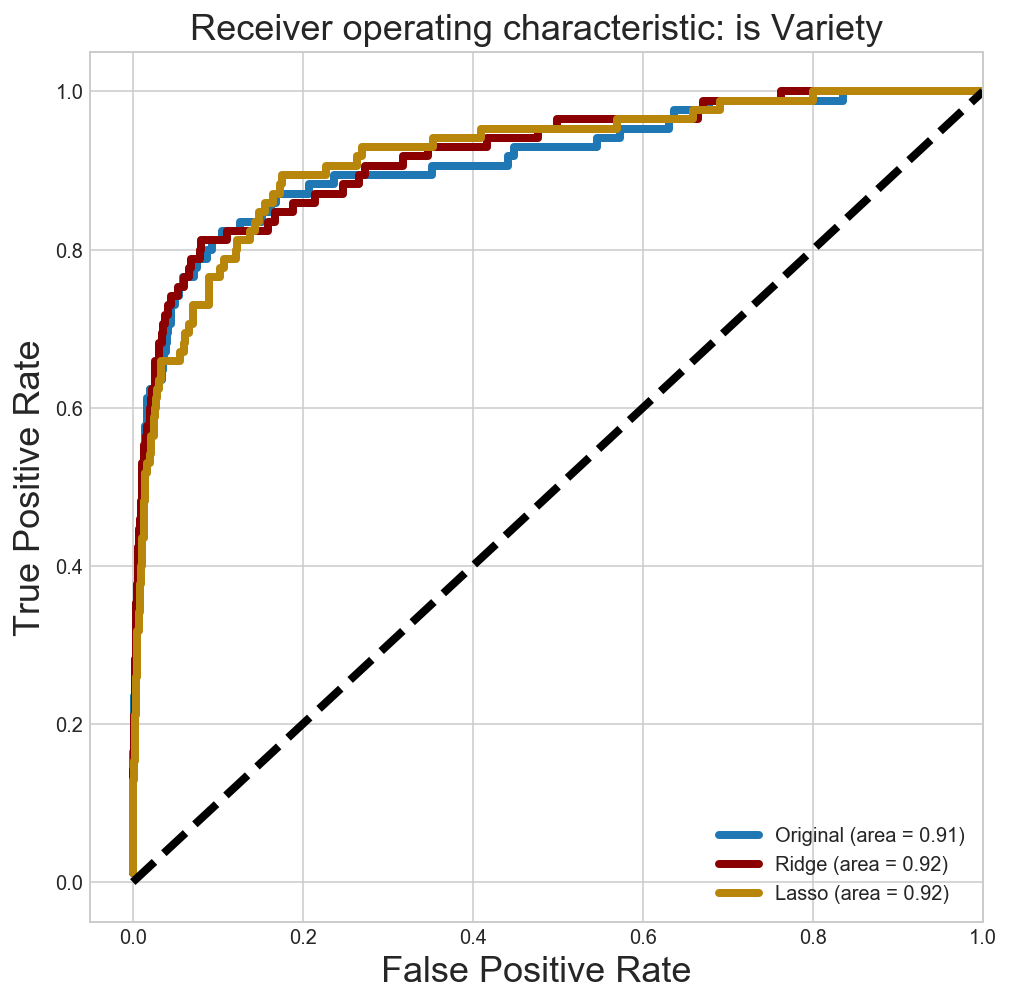

done
Variety is :  grapevar__Sparkling Blend
setup LR
[0.98639456 0.98639456 0.98639456 0.9877551  0.98503401 0.9877551
 0.9877551  0.98367347 0.9877551  0.9877551  0.98639456 0.98910082
 0.99182561 0.98910082 0.98910082 0.99318801 0.98637602 0.98501362
 0.98910082 0.98501362 0.98637602 0.98908595 0.98635744 0.98635744
 0.98772169]
0.987471196800313
             predicted_Yes  predicted_No
Variety                 20            95
Not Variety             15          9049


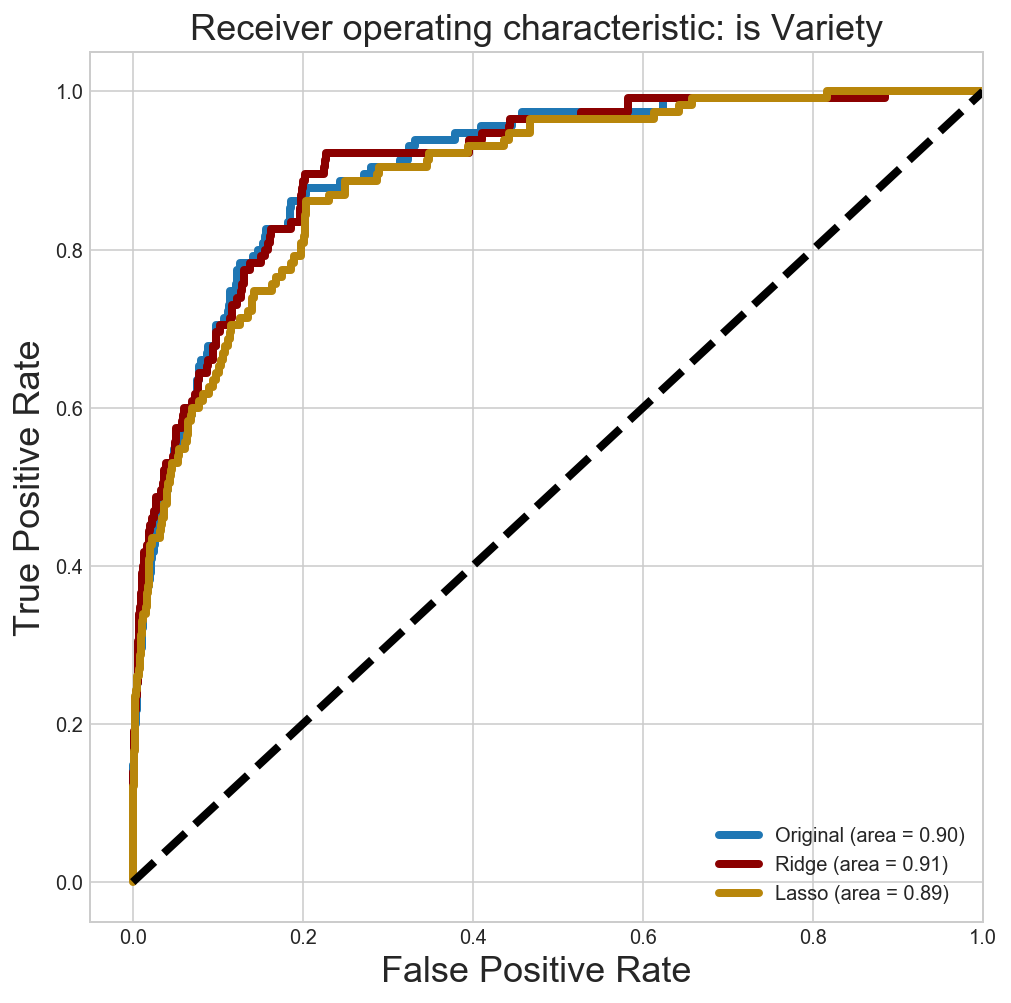

done
Variety is :  grapevar__Syrah
setup LR
[0.96870748 0.96054422 0.95918367 0.96734694 0.96734694 0.96190476
 0.95918367 0.95510204 0.96734694 0.96054422 0.96734694 0.96730245
 0.96594005 0.96321526 0.96866485 0.96185286 0.97002725 0.96594005
 0.97275204 0.96866485 0.96457766 0.97680764 0.96998636 0.97953615
 0.97407913]
0.9665561771909437
             predicted_Yes  predicted_No
Variety                180           290
Not Variety             60          8649


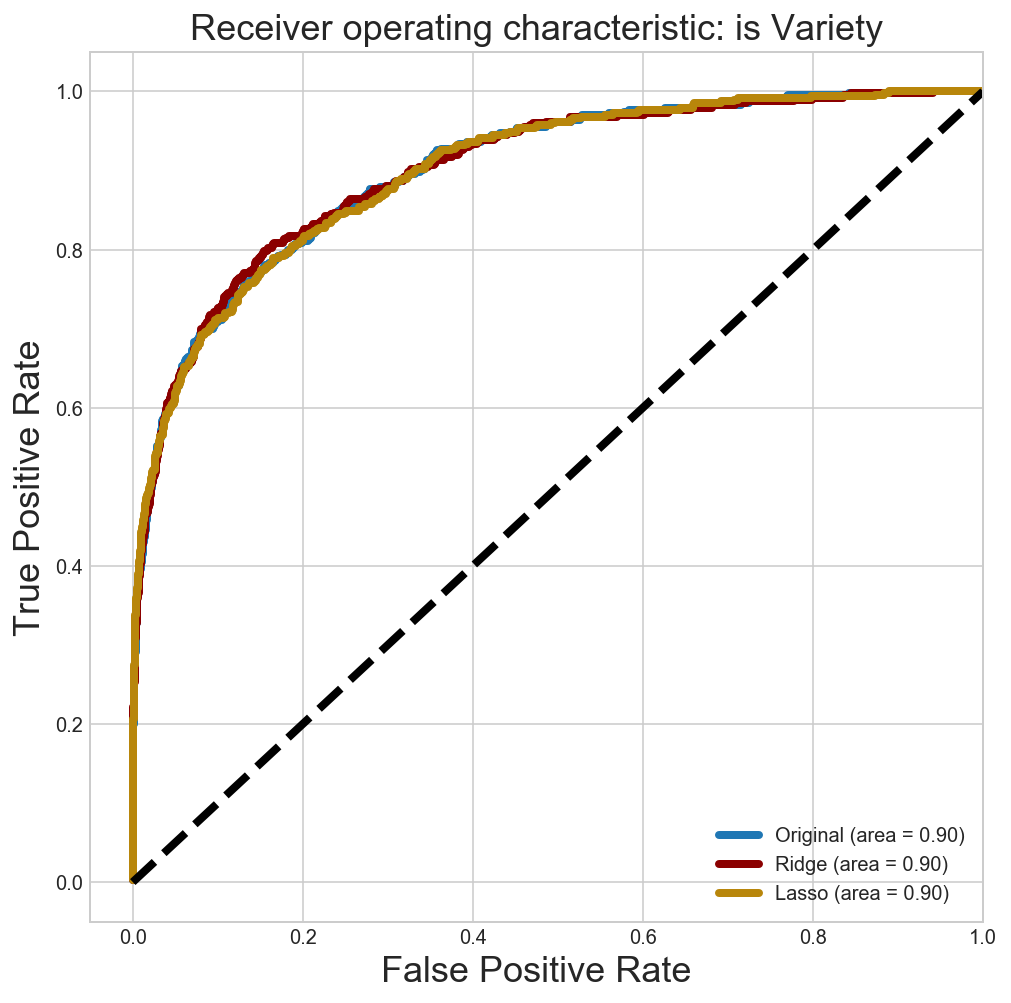

done
Variety is :  grapevar__Tempranillo Blend
setup LR
[0.99184783 0.99319728 0.99455782 0.99183673 0.98911565 0.99183673
 0.99182561 0.99455041 0.99046322 0.99455041 0.99182561 0.99182561
 0.99455041 0.99182561 0.99455041 0.99318801 0.99318801 0.99318801
 0.99182561 0.99046322 0.99455041 0.99318801 0.98910082 0.99455041
 0.99318801]
0.9925915945575008
             predicted_Yes  predicted_No
Variety                  6            56
Not Variety             11          9106


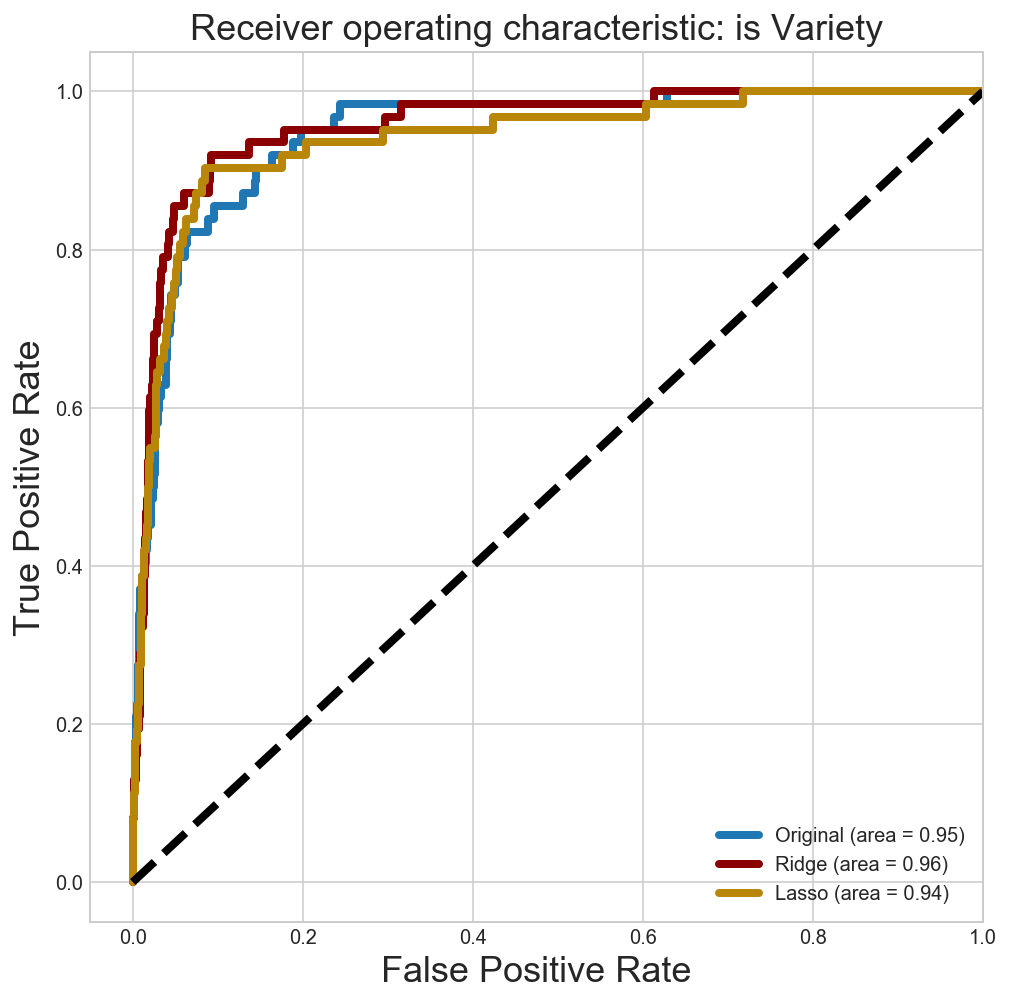

done
Variety is :  grapevar__Viognier
setup LR
[0.98639456 0.99047619 0.98911565 0.98639456 0.98911565 0.99047619
 0.98639456 0.98501362 0.98365123 0.98910082 0.98773842 0.98637602
 0.98773842 0.98637602 0.99046322 0.98910082 0.99046322 0.99182561
 0.98501362 0.98637602 0.98910082 0.98910082 0.99046322 0.99046322
 0.99046322]
0.9882878273925374
             predicted_Yes  predicted_No
Variety                  5            92
Not Variety             13          9069


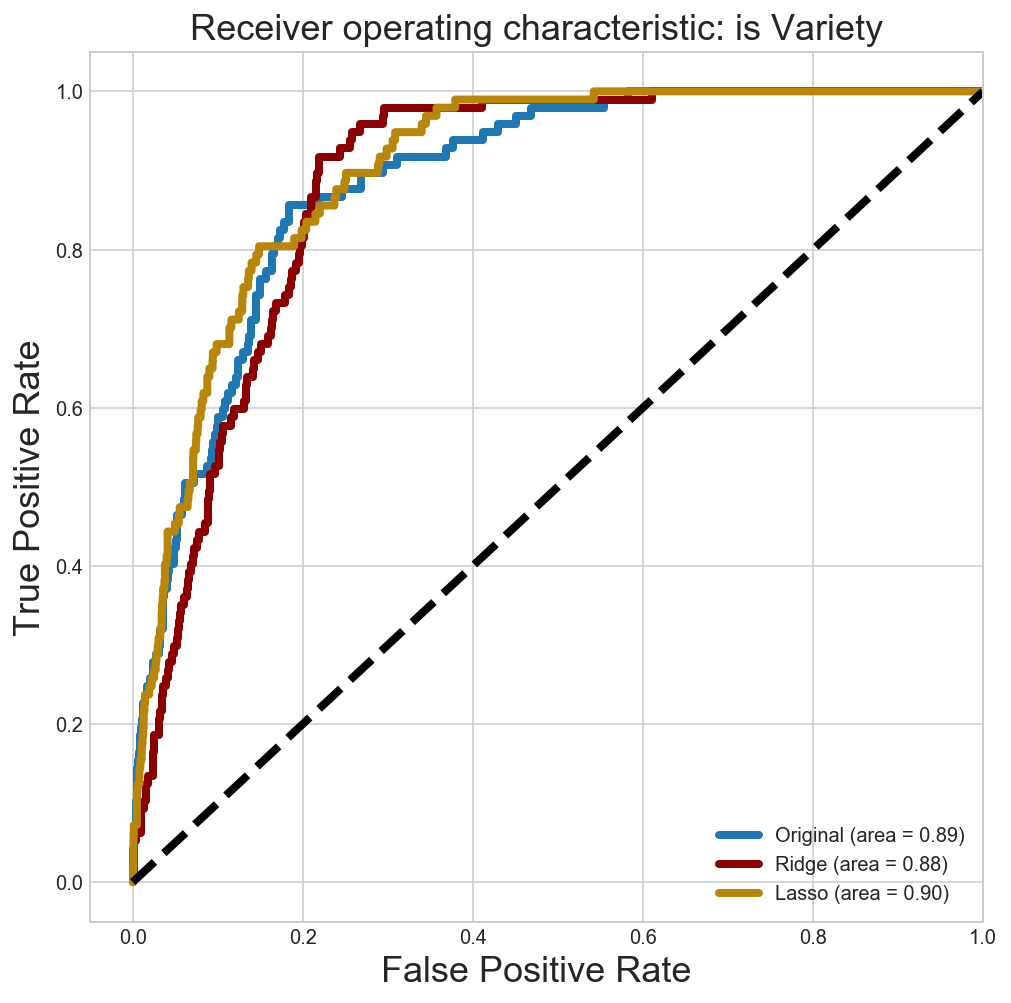

done
Variety is :  grapevar__Zinfandel
setup LR
[0.96462585 0.97414966 0.97823129 0.97006803 0.9755102  0.9755102
 0.97823129 0.97142857 0.97275204 0.97683924 0.98228883 0.97683924
 0.97683924 0.98092643 0.97002725 0.97547684 0.97683924 0.97820163
 0.97275204 0.98910082 0.98637602 0.97547684 0.98228883 0.97683924
 0.97953615]
0.9766862006022211
             predicted_Yes  predicted_No
Variety                 69           206
Not Variety             32          8872


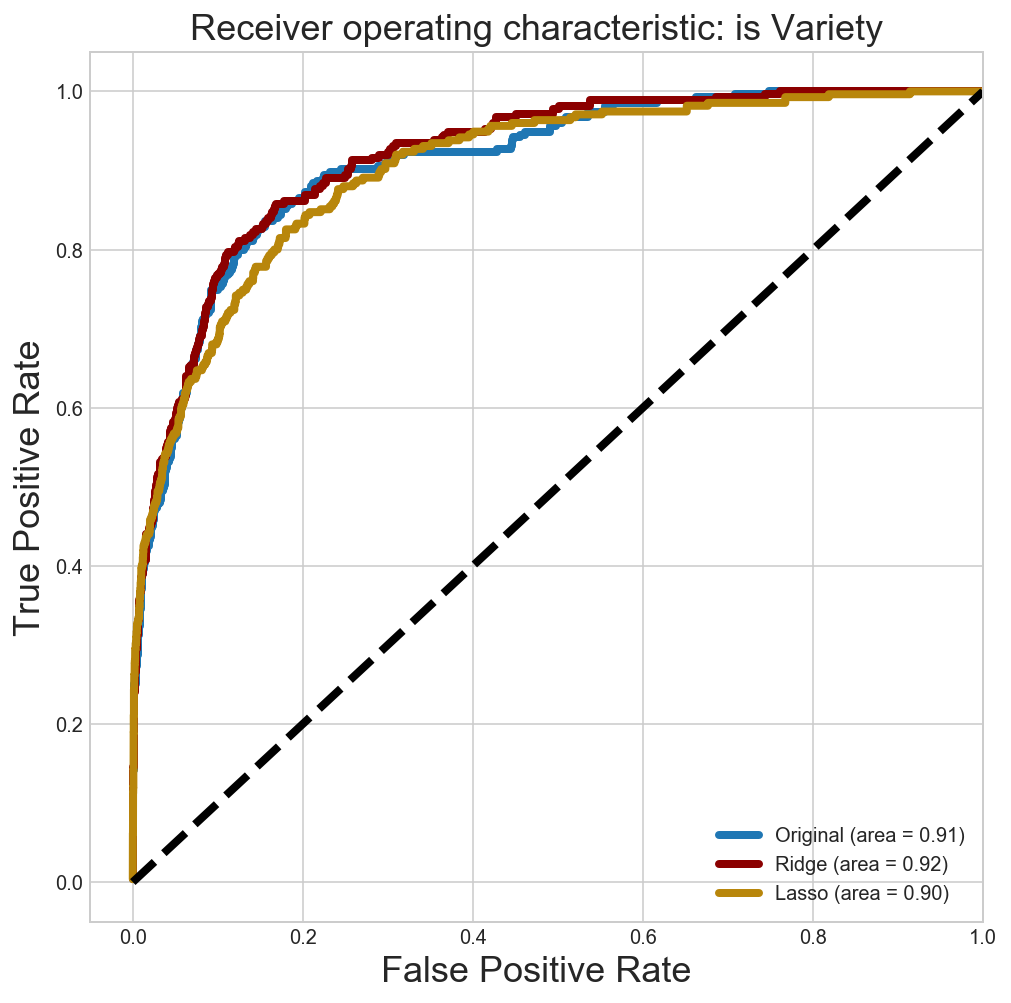

done


In [ ]:
for w in variety:
#     var=list(w)
    print('Variety is : ',w)
    ROCAUC(w)